In [ ]:
"""
3. Tareas Desglosadas:
Etapa 1: Preparación de Datos

Scraping y obtención de datos:
Usar la API de Riot para extraer datos de partidas clasificatorias de alto nivel.
Limitar los datos al último parche para mantener la relevancia.
Descargar datos adicionales para variables exógenas (clima en competencias, horarios de partidas, etc., si es relevante).
Limpieza y estructura:
Evaluar calidad de los datos: valores nulos, duplicados, inconsistencias.
Normalizar datos relevantes: daño por minuto, oro por minuto, etc.
Etapa 2: Análisis Exploratorio

Crear gráficos y tablas para visualizar:

Frecuencia de campeones, roles y objetos.
Relación entre KDA (Kills/Deaths/Assists) y victorias.
Eficiencia en objetivos (torretas, dragones, etc.) y resultados de partidas.
Realizar segmentaciones:

Por roles (jungla, mid, etc.).
Por regiones si los datos están disponibles.
Etapa 3: Análisis Avanzado

Series de tiempo:

Analizar cambios en la popularidad de campeones/estrategias a lo largo del parche.
Análisis de correlación:

Evaluar qué métricas tienen mayor correlación con la victoria.
Outliers:

Detectar jugadores, campeones o equipos con métricas anómalas (ejemplo: daño altísimo o tasas de victoria extremas).
Análisis de Cohortes:

Crear cohortes basadas en tiempo jugado, composición de equipo, o estrategias comunes.
Etapa 4: Modelado Predictivo

Clasificación:

Crear un modelo para predecir si un equipo ganará o no basado en:
Selección de campeones.
Composición de roles.
Estadísticas acumuladas.
Regresión:

Modelar el impacto de factores como "oro ganado por minuto" en la probabilidad de victoria.
Cumplimiento de Requisitos Mínimos
Scraping: La API de Riot proporcionará datos base.
EDA: Gráficos como histogramas, boxplots y diagramas de dispersión ayudarán a cumplir este punto.
Análisis de calidad: Puedes identificar datos faltantes o duplicados en las partidas.
Segmentación: Dividir datos por roles, regiones o niveles de habilidad.
Modelos predictivos: Usar clasificación y regresión regularizada (ej. Ridge o Lasso).
Análisis de tiempo: Detectar cambios en las tendencias del meta a lo largo del parche.
Correlaciones: Examinar qué métricas afectan más a la victoria.
Cohortes: Segmentar por estrategias o jugadores destacados.
Gráficos: Visualizar variables como daño, roles o victorias.
Outliers: Detectar partidas con resultados extremos para análisis adicional.
Viabilidad en Dos Semanas
Con tres horas al día, este proyecto es ambicioso, pero factible si te organizas bien. Sugiero:

Días 1-4: Obtención de datos y limpieza.
Días 5-7: Análisis exploratorio y gráfico.
Días 8-10: Modelos predictivos y validación.
Días 11-12: Análisis avanzado (cohortes, correlaciones, etc.).
Días 13-14: Refinamiento, documentación, y presentación en GitHub.
Si necesitas más ideas concretas o guía en alguna etapa, dime y profundizamos. ¡Adelante con el proyecto!
"""

In [ ]:
"""
Etapa 1: Preparación de Datos

Scraping y obtención de datos:
Usar la API de Riot para extraer datos de partidas clasificatorias de alto nivel.
Limitar los datos al último parche para mantener la relevancia.
Descargar datos adicionales para variables exógenas (clima en competencias, horarios de partidas, etc., si es relevante).
Limpieza y estructura:
Evaluar calidad de los datos: valores nulos, duplicados, inconsistencias.
Normalizar datos relevantes: daño por minuto, oro por minuto, etc.
"""

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import json
import csv
import time
import seaborn as sns


In [2]:

API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"

In [18]:
import requests
import time

# Configuración inicial
API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"
REGION = 'euw1'  # Cambia según la región deseada (e.g., na1, kr, etc.)
CHALLENGER_URL = f'https://{REGION}.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5'
SUMMONER_URL = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/'

HEADERS = {
    'X-Riot-Token': API_KEY
}

# Límites de tasa
RATE_LIMIT_SECOND = 20  # 20 requests por segundo
RATE_LIMIT_WINDOW = 120  # 100 requests por cada 2 minutos
RATE_LIMIT_REQUESTS = 99  # Límite de solicitudes por ventana

def get_challenger_players():
    """
    Obtiene la lista de jugadores en Challenger junto con sus summonerIds.
    """
    response = requests.get(CHALLENGER_URL, headers=HEADERS)
    if response.status_code == 200:
        challenger_data = response.json()
        return challenger_data['entries']  # Lista de LeagueItemDTO
    else:
        print(f"Error al obtener la lista de Challengers: {response.status_code}")
        return []

def get_puuid(summoner_id):
    """
    Obtiene el PUUID de un jugador a partir de su summonerId.
    """
    response = requests.get(SUMMONER_URL + summoner_id, headers=HEADERS)
    if response.status_code == 200:
        summoner_data = response.json()
        return summoner_data['puuid']
    else:
        print(f"Error al obtener PUUID para el summonerId {summoner_id}: {response.status_code}")
        return None

def rate_limited_request(requests_count, start_time):
    """
    Controla el límite de tasa para evitar exceder los límites de la API.
    """
    elapsed_time = time.time() - start_time

    # Pausar si excedemos los límites por segundo
    if requests_count % RATE_LIMIT_SECOND == 0:
        time.sleep(1)

    # Pausar si excedemos los límites de 2 minutos
    if requests_count >= RATE_LIMIT_REQUESTS and elapsed_time < RATE_LIMIT_WINDOW:
        sleep_time = RATE_LIMIT_WINDOW - elapsed_time
        print(f"Esperando {sleep_time:.2f} segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...")
        time.sleep(sleep_time)
        return 0, time.time()  # Reiniciar contador y tiempo de inicio
    return requests_count, start_time

def main():
    """
    Obtiene la lista completa de PUUIDs para jugadores Challenger.
    """
    # Obtener jugadores Challenger
    challengers = get_challenger_players()
    print(f"Se encontraron {len(challengers)} jugadores en Challenger.")

    # Extraer PUUIDs
    puuids = []
    requests_count = 0
    start_time = time.time()

    for player in challengers:
        summoner_id = player['summonerId']

        # Control de límite de tasa
        requests_count, start_time = rate_limited_request(requests_count, start_time)

        # Obtener el PUUID
        puuid = get_puuid(summoner_id)
        requests_count += 1  # Incrementar contador de solicitudes
        if puuid:
            puuids.append(puuid)

    print(f"Se obtuvieron {len(puuids)} PUUIDs.")
    return puuids

if __name__ == "__main__":
    puuids = main()


Error al obtener la lista de Challengers: 403
Se encontraron 0 jugadores en Challenger.
Se obtuvieron 0 PUUIDs.


In [19]:
import requests
import time

# Configuración inicial
API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"
REGION = 'europe'  # Para datos de partidas usa la región de clúster, no "euw1"
MATCH_URL = f'https://{REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/'
MATCH_DETAILS_URL = f'https://{REGION}.api.riotgames.com/lol/match/v5/matches/'

HEADERS = {
    'X-Riot-Token': API_KEY
}

# Límites de tasa
RATE_LIMIT_SECOND = 20  # 20 requests por segundo
RATE_LIMIT_WINDOW = 120  # 100 requests por cada 2 minutos
RATE_LIMIT_REQUESTS = 99  # Límite de solicitudes por ventana

def get_matches(puuid, start=0, count=20):
    """
    Obtiene una lista de IDs de partidas para un jugador dado su PUUID.
    """
    url = f"{MATCH_URL}{puuid}/ids?start={start}&count={count}"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json()  # Lista de IDs de partidas
    else:
        print(f"Error al obtener partidas para el PUUID {puuid}: {response.status_code}")
        return []

def get_match_details(match_id):
    """
    Obtiene los detalles de una partida dado su ID.
    """
    url = f"{MATCH_DETAILS_URL}{match_id}"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json()  # Detalles de la partida
    else:
        print(f"Error al obtener detalles para la partida {match_id}: {response.status_code}")
        return None

def rate_limited_request(requests_count, start_time):
    """
    Controla el límite de tasa para evitar exceder los límites de la API.
    """
    elapsed_time = time.time() - start_time

    # Pausar si excedemos los límites por segundo
    if requests_count % RATE_LIMIT_SECOND == 0:
        time.sleep(1)

    # Pausar si excedemos los límites de 2 minutos
    if requests_count >= RATE_LIMIT_REQUESTS and elapsed_time < RATE_LIMIT_WINDOW:
        sleep_time = RATE_LIMIT_WINDOW - elapsed_time
        print(f"Esperando {sleep_time:.2f} segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...")
        time.sleep(sleep_time)
        return 0, time.time()  # Reiniciar contador y tiempo de inicio
    return requests_count, start_time

def extract_match_data(puuids, matches_per_player=20):
    """
    Extrae datos de partidas para una lista de PUUIDs.
    """
    all_match_details = []
    requests_count = 0
    start_time = time.time()

    for puuid in puuids:
        print(f"Obteniendo partidas para PUUID: {puuid}")

        # Control de límite de tasa
        requests_count, start_time = rate_limited_request(requests_count, start_time)

        # Obtener IDs de partidas
        match_ids = get_matches(puuid, count=matches_per_player)
        requests_count += 1

        for match_id in match_ids:
            # Control de límite de tasa
            requests_count, start_time = rate_limited_request(requests_count, start_time)

            # Obtener detalles de la partida
            match_details = get_match_details(match_id)
            requests_count += 1

            if match_details:
                all_match_details.append(match_details)

    print(f"Se extrajeron datos de {len(all_match_details)} partidas.")
    return all_match_details

if __name__ == "__main__":
    # Lista de PUUIDs (puedes cargar esta lista desde tu script anterior)
    matches_per_player = 20  # Número de partidas a extraer por jugador

    match_data = extract_match_data(puuids, matches_per_player=matches_per_player)


Se extrajeron datos de 0 partidas.


In [3]:
import pandas as pd

def save_full_match_data_to_csv(match_data, filename="full_match_data.csv"):
    """
    Guarda todos los datos de las partidas en un archivo CSV.
    
    :param match_data: Lista de detalles completos de las partidas.
    :param filename: Nombre del archivo CSV de salida.
    """
    # Lista para almacenar los datos a guardar
    match_rows = []
    
    for match in match_data:
        # Extraer metadatos de la partida
        match_id = match.get("metadata", {}).get("matchId", "")
        data_version = match.get("metadata", {}).get("dataVersion", "")
        participants = match.get("metadata", {}).get("participants", [])
        
        # Extraer info de la partida
        game_creation = match.get("info", {}).get("gameCreation", "")
        game_duration = match.get("info", {}).get("gameDuration", "")
        game_end_timestamp = match.get("info", {}).get("gameEndTimestamp", "")
        game_start_timestamp = match.get("info", {}).get("gameStartTimestamp", "")
        game_mode = match.get("info", {}).get("gameMode", "")
        game_name = match.get("info", {}).get("gameName", "")
        game_type = match.get("info", {}).get("gameType", "")
        game_version = match.get("info", {}).get("gameVersion", "")
        map_id = match.get("info", {}).get("mapId", "")
        platform_id = match.get("info", {}).get("platformId", "")
        queue_id = match.get("info", {}).get("queueId", "")
        tournament_code = match.get("info", {}).get("tournamentCode", "")
        
        # Extraer equipos
        teams = match.get("info", {}).get("teams", [])
        
        # Iterar sobre cada participante en la partida
        for participant in match.get("info", {}).get("participants", []):
            # Extraer los datos del participante
            match_rows.append({
                "match_id": match_id,
                "data_version": data_version,
                "participants": participants,
                "game_creation": game_creation,
                "game_duration": game_duration,
                "game_end_timestamp": game_end_timestamp,
                "game_start_timestamp": game_start_timestamp,
                "game_mode": game_mode,
                "game_name": game_name,
                "game_type": game_type,
                "game_version": game_version,
                "map_id": map_id,
                "platform_id": platform_id,
                "queue_id": queue_id,
                "tournament_code": tournament_code,
                "team_id": participant.get("teamId", ""),
                "summoner_name": participant.get("summonerName", ""),
                "champion_name": participant.get("championName", ""),
                "champion_id": participant.get("championId", ""),
                "kills": participant.get("kills", 0),
                "deaths": participant.get("deaths", 0),
                "assists": participant.get("assists", 0),
                "total_damage_dealt": participant.get("totalDamageDealt", 0),
                "gold_earned": participant.get("goldEarned", 0),
                "win": participant.get("win", False),
                "lane": participant.get("lane", ""),
                "role": participant.get("role", ""),
                "vision_score": participant.get("visionScore", 0),
                "wards_placed": participant.get("wardsPlaced", 0),
                "wards_killed": participant.get("wardsKilled", 0),
                "total_heals_on_teammates": participant.get("totalHealsOnTeammates", 0),
                "total_minions_killed": participant.get("totalMinionsKilled", 0),
                "total_damage_taken": participant.get("totalDamageTaken", 0),
                "time_played": participant.get("timePlayed", 0),
                "total_ally_jungle_minions_killed": participant.get("totalAllyJungleMinionsKilled", 0),
                "total_damage_dealt_to_champions": participant.get("totalDamageDealtToChampions", 0),
                "total_heal": participant.get("totalHeal", 0),
                "total_damage_shielded_on_teammates": participant.get("totalDamageShieldedOnTeammates", 0),
                "total_enemy_jungle_minions_killed": participant.get("totalEnemyJungleMinionsKilled", 0),
                "time_ccing_others": participant.get("timeCCingOthers", 0),
                "total_units_healed": participant.get("totalUnitsHealed", 0),
                "total_kills": participant.get("kills", 0),
                "penta_kills": participant.get("pentaKills", 0),
                "quadra_kills": participant.get("quadraKills", 0),
                "triple_kills": participant.get("tripleKills", 0),
                "double_kills": participant.get("doubleKills", 0),
                "first_blood_kill": participant.get("firstBloodKill", False),
                "first_blood_assist": participant.get("firstBloodAssist", False),
                "first_tower_kill": participant.get("firstTowerKill", False),
                "first_tower_assist": participant.get("firstTowerAssist", False),
                "dragon_kills": participant.get("dragonKills", 0),
                "baron_kills": participant.get("baronKills", 0),
                "inhibitor_kills": participant.get("inhibitorKills", 0),
                "turret_kills": participant.get("turretKills", 0),
                "towers_lost": participant.get("turretsLost", 0),
                "nexus_kills": participant.get("nexusKills", 0),
                "nexus_takedowns": participant.get("nexusTakedowns", 0),
                "total_vision_cleared_pings": participant.get("visionClearedPings", 0),
                "summoner_id": participant.get("summonerId", ""),
                "summoner_level": participant.get("summonerLevel", 0),
                "summoner_name": participant.get("summonerName", ""),
                "profile_icon": participant.get("profileIcon", 0),
                "champ_experience": participant.get("champExperience", 0),
                "champ_level": participant.get("champLevel", 0),
                "role": participant.get("role", ""),
                "individual_position": participant.get("individualPosition", ""),
                "team_position": participant.get("teamPosition", ""),
                "player_augment_1": participant.get("playerAugment1", 0),
                "player_augment_2": participant.get("playerAugment2", 0),
                "player_augment_3": participant.get("playerAugment3", 0),
                "player_augment_4": participant.get("playerAugment4", 0),
                "mission": participant.get("missions", {}),
                "perks": participant.get("perks", {}),
                "total_damage_to_buildings": participant.get("damageDealtToBuildings", 0),
                "total_damage_to_objectives": participant.get("damageDealtToObjectives", 0),
                "damage_self_mitigated": participant.get("damageSelfMitigated", 0),
                "enemy_missing_pings": participant.get("enemyMissingPings", 0),
                "enemy_vision_pings": participant.get("enemyVisionPings", 0),
                "gold_spent": participant.get("goldSpent", 0),
                "hold_pings": participant.get("holdPings", 0),
                "get_back_pings": participant.get("getBackPings", 0),
                "total_units_healed": participant.get("totalUnitsHealed", 0),
                "longest_time_spent_living": participant.get("longestTimeSpentLiving", 0),
                "magic_damage_dealt": participant.get("magicDamageDealt", 0),
                "magic_damage_dealt_to_champions": participant.get("magicDamageDealtToChampions", 0),
                "magic_damage_taken": participant.get("magicDamageTaken", 0),
                "physical_damage_dealt": participant.get("physicalDamageDealt", 0),
                "physical_damage_dealt_to_champions": participant.get("physicalDamageDealtToChampions", 0),
                "physical_damage_taken": participant.get("physicalDamageTaken", 0),
                "true_damage_dealt": participant.get("trueDamageDealt", 0),
                "true_damage_dealt_to_champions": participant.get("trueDamageDealtToChampions", 0),
                "true_damage_taken": participant.get("trueDamageTaken", 0),
                "time_spent_dead": participant.get("totalTimeSpentDead", 0),
                "total_time_cc_dealt": participant.get("totalTimeCCDealt", 0),
                "vision_wards_bought_in_game": participant.get("visionWardsBoughtInGame", 0),
            })
    
    # Crear un DataFrame con los datos
    df = pd.DataFrame(match_rows)
    
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(filename, index=False)
    print(f"Datos guardados en el archivo {filename}")


In [4]:
# Llamar a la función de guardado
save_full_match_data_to_csv(match_data, filename="full_match_data.csv")


NameError: name 'match_data' is not defined

In [22]:
df.info()

NameError: name 'df' is not defined

In [4]:
# Mostrar la distribución de 'game_version'
distribution = df['game_version'].value_counts()

# Mostrar la distribución
print(distribution)


NameError: name 'df' is not defined

# LEER CSV

In [4]:
import pandas as pd
from io import StringIO

# Cargar el CSV en un DataFrame
df_ultimo_parche = pd.read_csv("merged_dataset_14.23.csv", low_memory=False)

# Ver las primeras filas del DataFrame filtrado
print(df_ultimo_parche.head())


          match_id  data_version  \
0  EUW1_7218125253             2   
1  EUW1_7218125253             2   
2  EUW1_7218125253             2   
3  EUW1_7218125253             2   
4  EUW1_7218125253             2   

                                        participants  game_creation  \
0  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   
1  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   
2  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   
3  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   
4  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   

   game_duration  game_end_timestamp  game_start_timestamp game_mode  \
0           1270       1733568798383         1733567527616      ARAM   
1           1270       1733568798383         1733567527616      ARAM   
2           1270       1733568798383         1733567527616      ARAM   
3           1270       1733568798383         1733567527616      ARAM

In [ ]:
## Juntar dtaframes y eliminar gold_spend



In [29]:
df_ultimo_parche.shape

(59360, 92)

In [31]:
df_ultimo_parche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59360 entries, 0 to 59359
Data columns (total 92 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   match_id                            59360 non-null  object
 1   data_version                        59360 non-null  int64 
 2   participants                        59360 non-null  object
 3   game_creation                       59360 non-null  int64 
 4   game_duration                       59360 non-null  int64 
 5   game_end_timestamp                  59360 non-null  int64 
 6   game_start_timestamp                59360 non-null  int64 
 7   game_mode                           59360 non-null  object
 8   game_name                           59360 non-null  object
 9   game_type                           59360 non-null  object
 10  game_version                        59360 non-null  object
 11  map_id                              59360 non-null  in

1. Definir los objetivos específicos
Antes de comenzar con el análisis, asegúrate de tener claros los objetivos que quieres lograr. Como el análisis debe guiar al coach del equipo en la estrategia, algunas áreas clave que podrían ser relevantes son:

Meta actual del juego:

*¿Qué campeones están ganando más partidas? ¿Qué campeones están en las mejores posiciones de win rate en las partidas clasificatorias?

*Posicionamiento de campeones: ¿Cuáles son los campeones más fuertes en cada rol (Top, Jungle, Mid, ADC, Support)?

*Tendencias de objetos: ¿Qué objetos están siendo más efectivos para ciertos campeones o roles?

*Impacto de los dragones, torres, y objetivos mayores: ¿Qué impacto tienen en el resultado final de las partidas las tomas de dragón, torres y barones?

*Composición de equipos: ¿Qué combinaciones de campeones son más exitosas en determinadas composiciones de equipo?


Análisis exploratorio de los datos (EDA)
El análisis exploratorio es clave para entender las características de las partidas y establecer patrones. Algunos análisis que puedes hacer son:

Distribución de los roles y campeones: Analiza qué campeones y roles predominan en las partidas de alto nivel. Esto podría ayudarte a identificar los "pick" más comunes en el meta actual.

Estudio de las estadísticas individuales de los jugadores:

KDA (Killer/Death/Assist): Este es un buen indicador para medir el rendimiento de los jugadores en las partidas.
Gold Earned y Items Comprados: Ver cómo los diferentes objetos se correlacionan con el desempeño del jugador.

In [44]:
# Ver las primeras filas del DataFrame filtrado
df_ultimo_parche.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50340 entries, 0 to 59359
Data columns (total 92 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   match_id                            50340 non-null  object
 1   data_version                        50340 non-null  int64 
 2   participants                        50340 non-null  object
 3   game_creation                       50340 non-null  int64 
 4   game_duration                       50340 non-null  int64 
 5   game_end_timestamp                  50340 non-null  int64 
 6   game_start_timestamp                50340 non-null  int64 
 7   game_mode                           50340 non-null  object
 8   game_name                           50340 non-null  object
 9   game_type                           50340 non-null  object
 10  game_version                        50340 non-null  object
 11  map_id                              50340 non-null  int64 


C:\Users\chris\AppData\Local\Temp\ipykernel_24088\2154288337.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=champion_counts.index, y=champion_counts.values, palette='viridis')


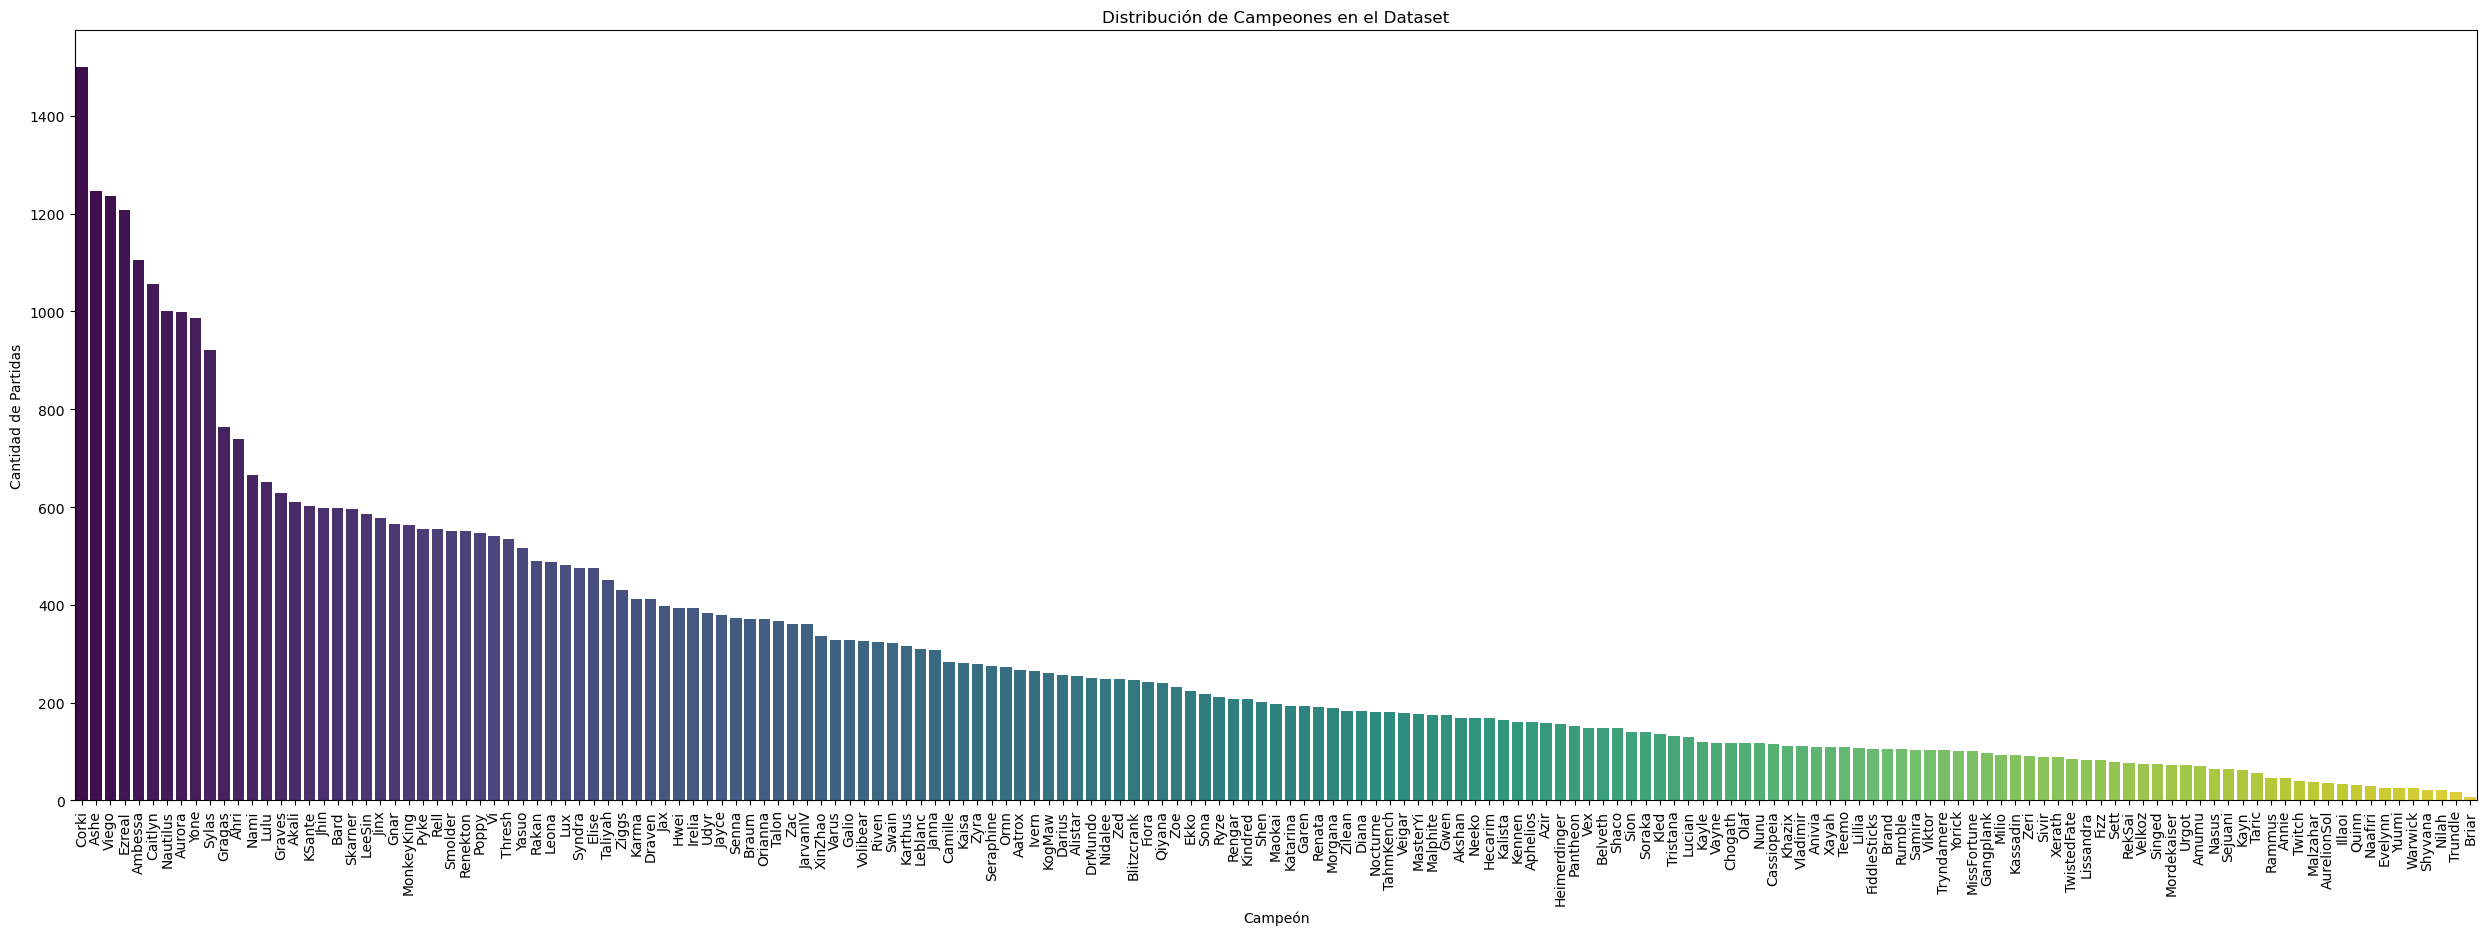

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de los campeones
champion_counts = df_ultimo_parche['champion_name'].value_counts()

# Graficar la distribución de campeones
plt.figure(figsize=(31, 10))
sns.barplot(x=champion_counts.index, y=champion_counts.values, palette='viridis')
plt.xticks(rotation=90)  # Para girar los nombres de los campeones si son largos
plt.xlabel('Campeón')
plt.ylabel('Cantidad de Partidas')
plt.title('Distribución de Campeones en el Dataset')
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_24088\3109230639.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_counts.index, y=role_counts.values, palette='Set2')


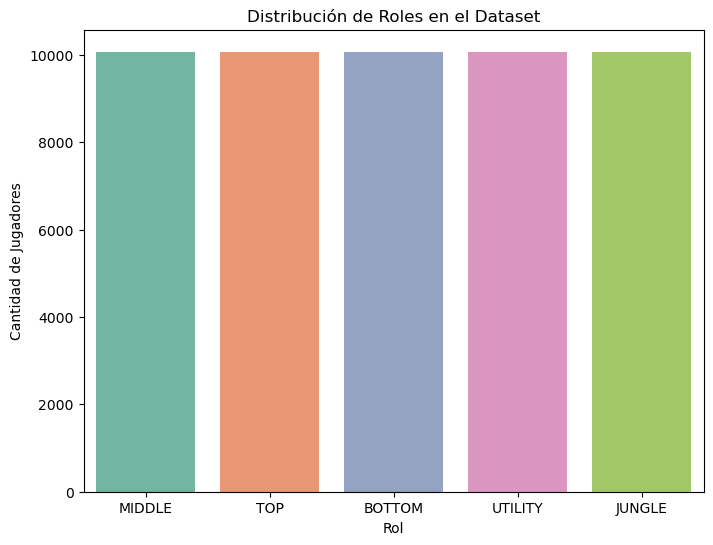

In [96]:
# Distribución de roles 
role_counts = df_ultimo_parche['team_position'].value_counts()

# Graficar la distribución de roles
plt.figure(figsize=(8, 6))
sns.barplot(x=role_counts.index, y=role_counts.values, palette='Set2')
plt.xlabel('Rol')
plt.ylabel('Cantidad de Jugadores')
plt.title('Distribución de Roles en el Dataset')
plt.show()


In [122]:
#Vemos que UTILITY es support
# Cambiar "UTILITY" a "SUPPORT" en la columna 'team_position'
df_ultimo_parche['team_position'] = df_ultimo_parche['team_position'].replace('UTILITY', 'SUPPORT')

# Verificar los cambios
print(df_ultimo_parche['team_position'].value_counts())


team_position
MIDDLE     10068
TOP        10067
BOTTOM     10067
SUPPORT    10067
JUNGLE     10064
Name: count, dtype: int64


C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1893805062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['team_position'] = df_ultimo_parche['team_position'].replace('UTILITY', 'SUPPORT')


In [124]:
# Agrupar por campeón y rol
champion_role_counts = df_ultimo_parche.groupby(['champion_name', 'team_position']).size().reset_index(name='count')

# Ver las primeras filas
champion_role_counts.head()


champion_name team_position  count
0        Aatrox        MIDDLE      4
1        Aatrox       SUPPORT      1
2        Aatrox           TOP    261
3          Ahri        MIDDLE    736
4          Ahri       SUPPORT      1

<Figure size 6500x2000 with 0 Axes>

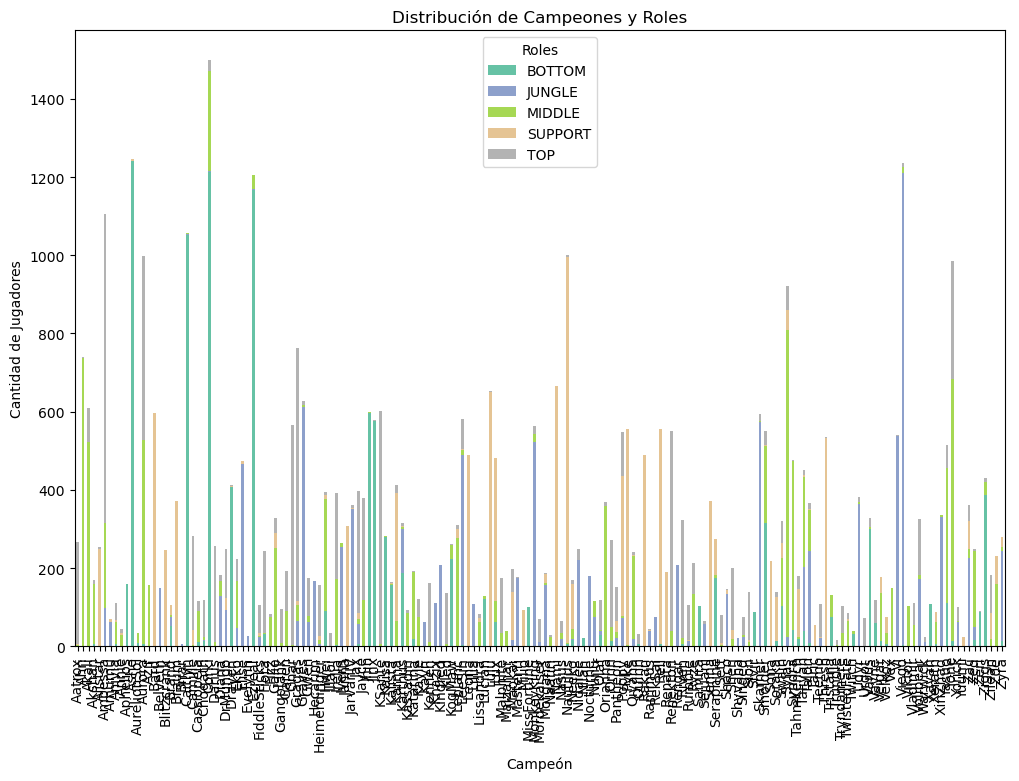

In [132]:
# Pivotar la tabla para que los campeones sean las filas, los roles sean las columnas
champion_role_pivot = champion_role_counts.pivot(index='champion_name', columns='team_position', values='count').fillna(0)

# Graficar la distribución de campeones por rol
plt.figure(figsize=(65, 20))
champion_role_pivot.plot(kind='bar', stacked=True, colormap='Set2', figsize=(12, 8))
plt.title('Distribución de Campeones y Roles')
plt.xlabel('Campeón')
plt.ylabel('Cantidad de Jugadores')
plt.xticks(rotation=90)
plt.legend(title='Roles')
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


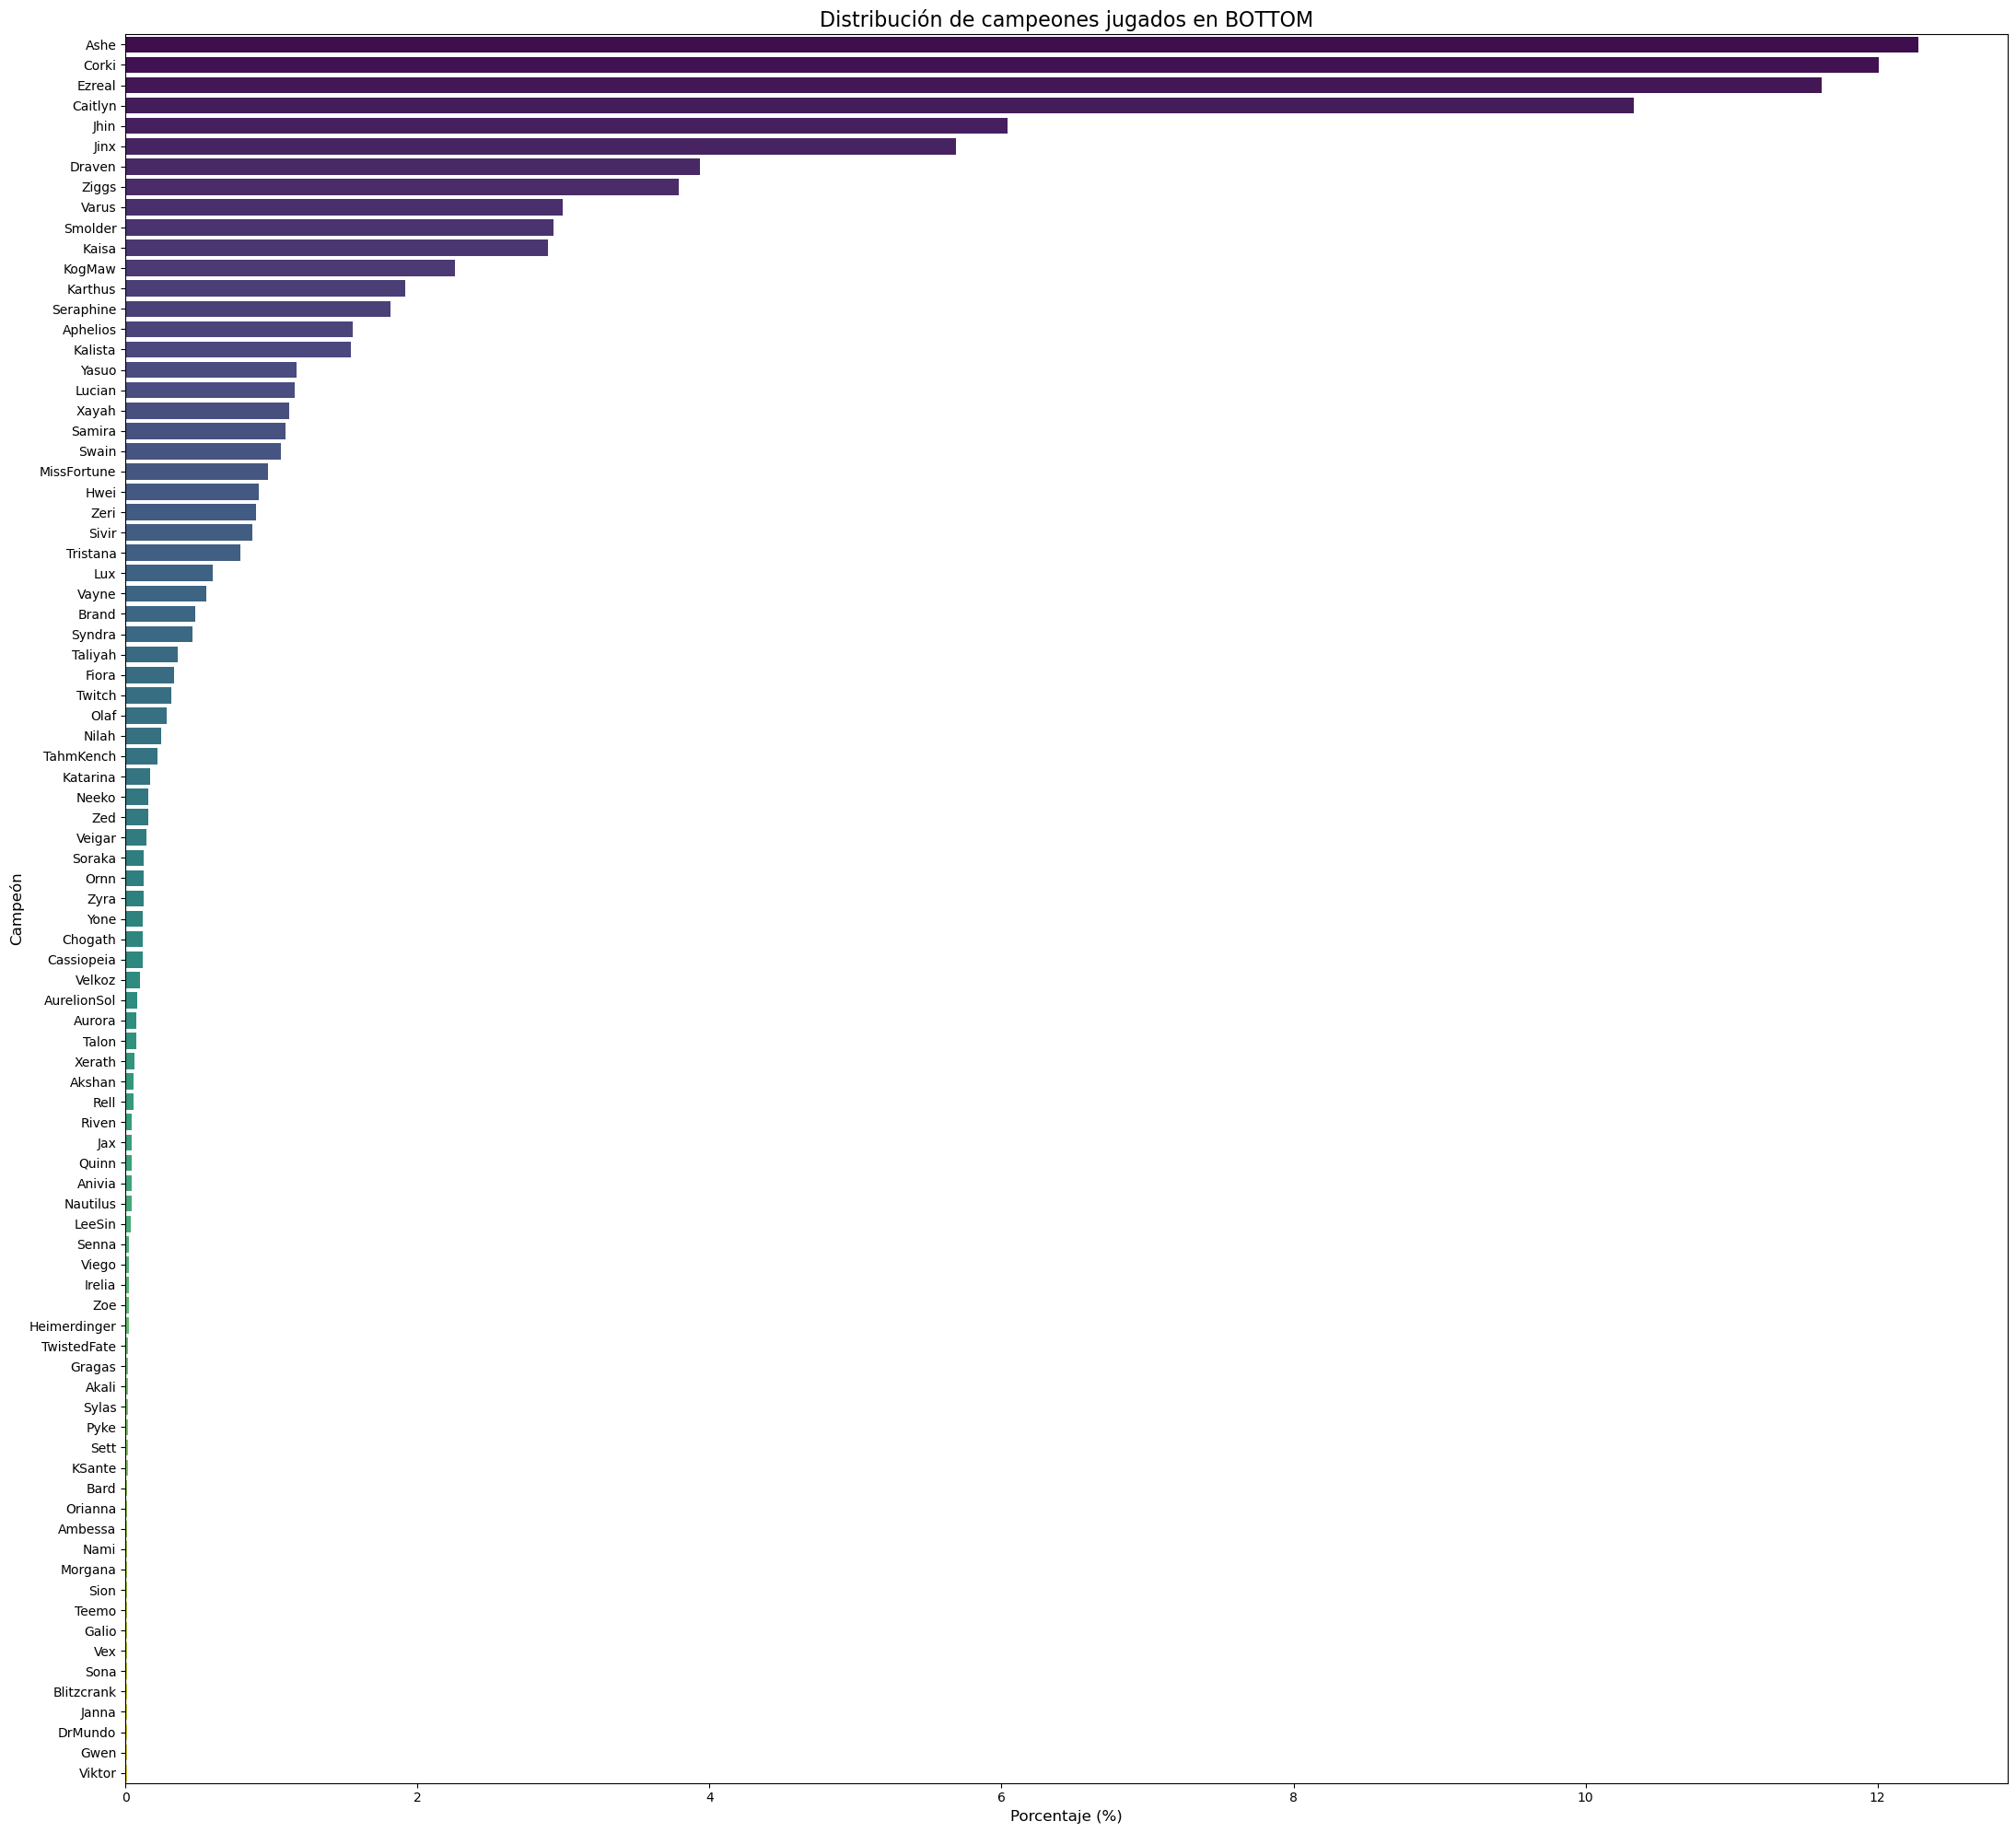

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


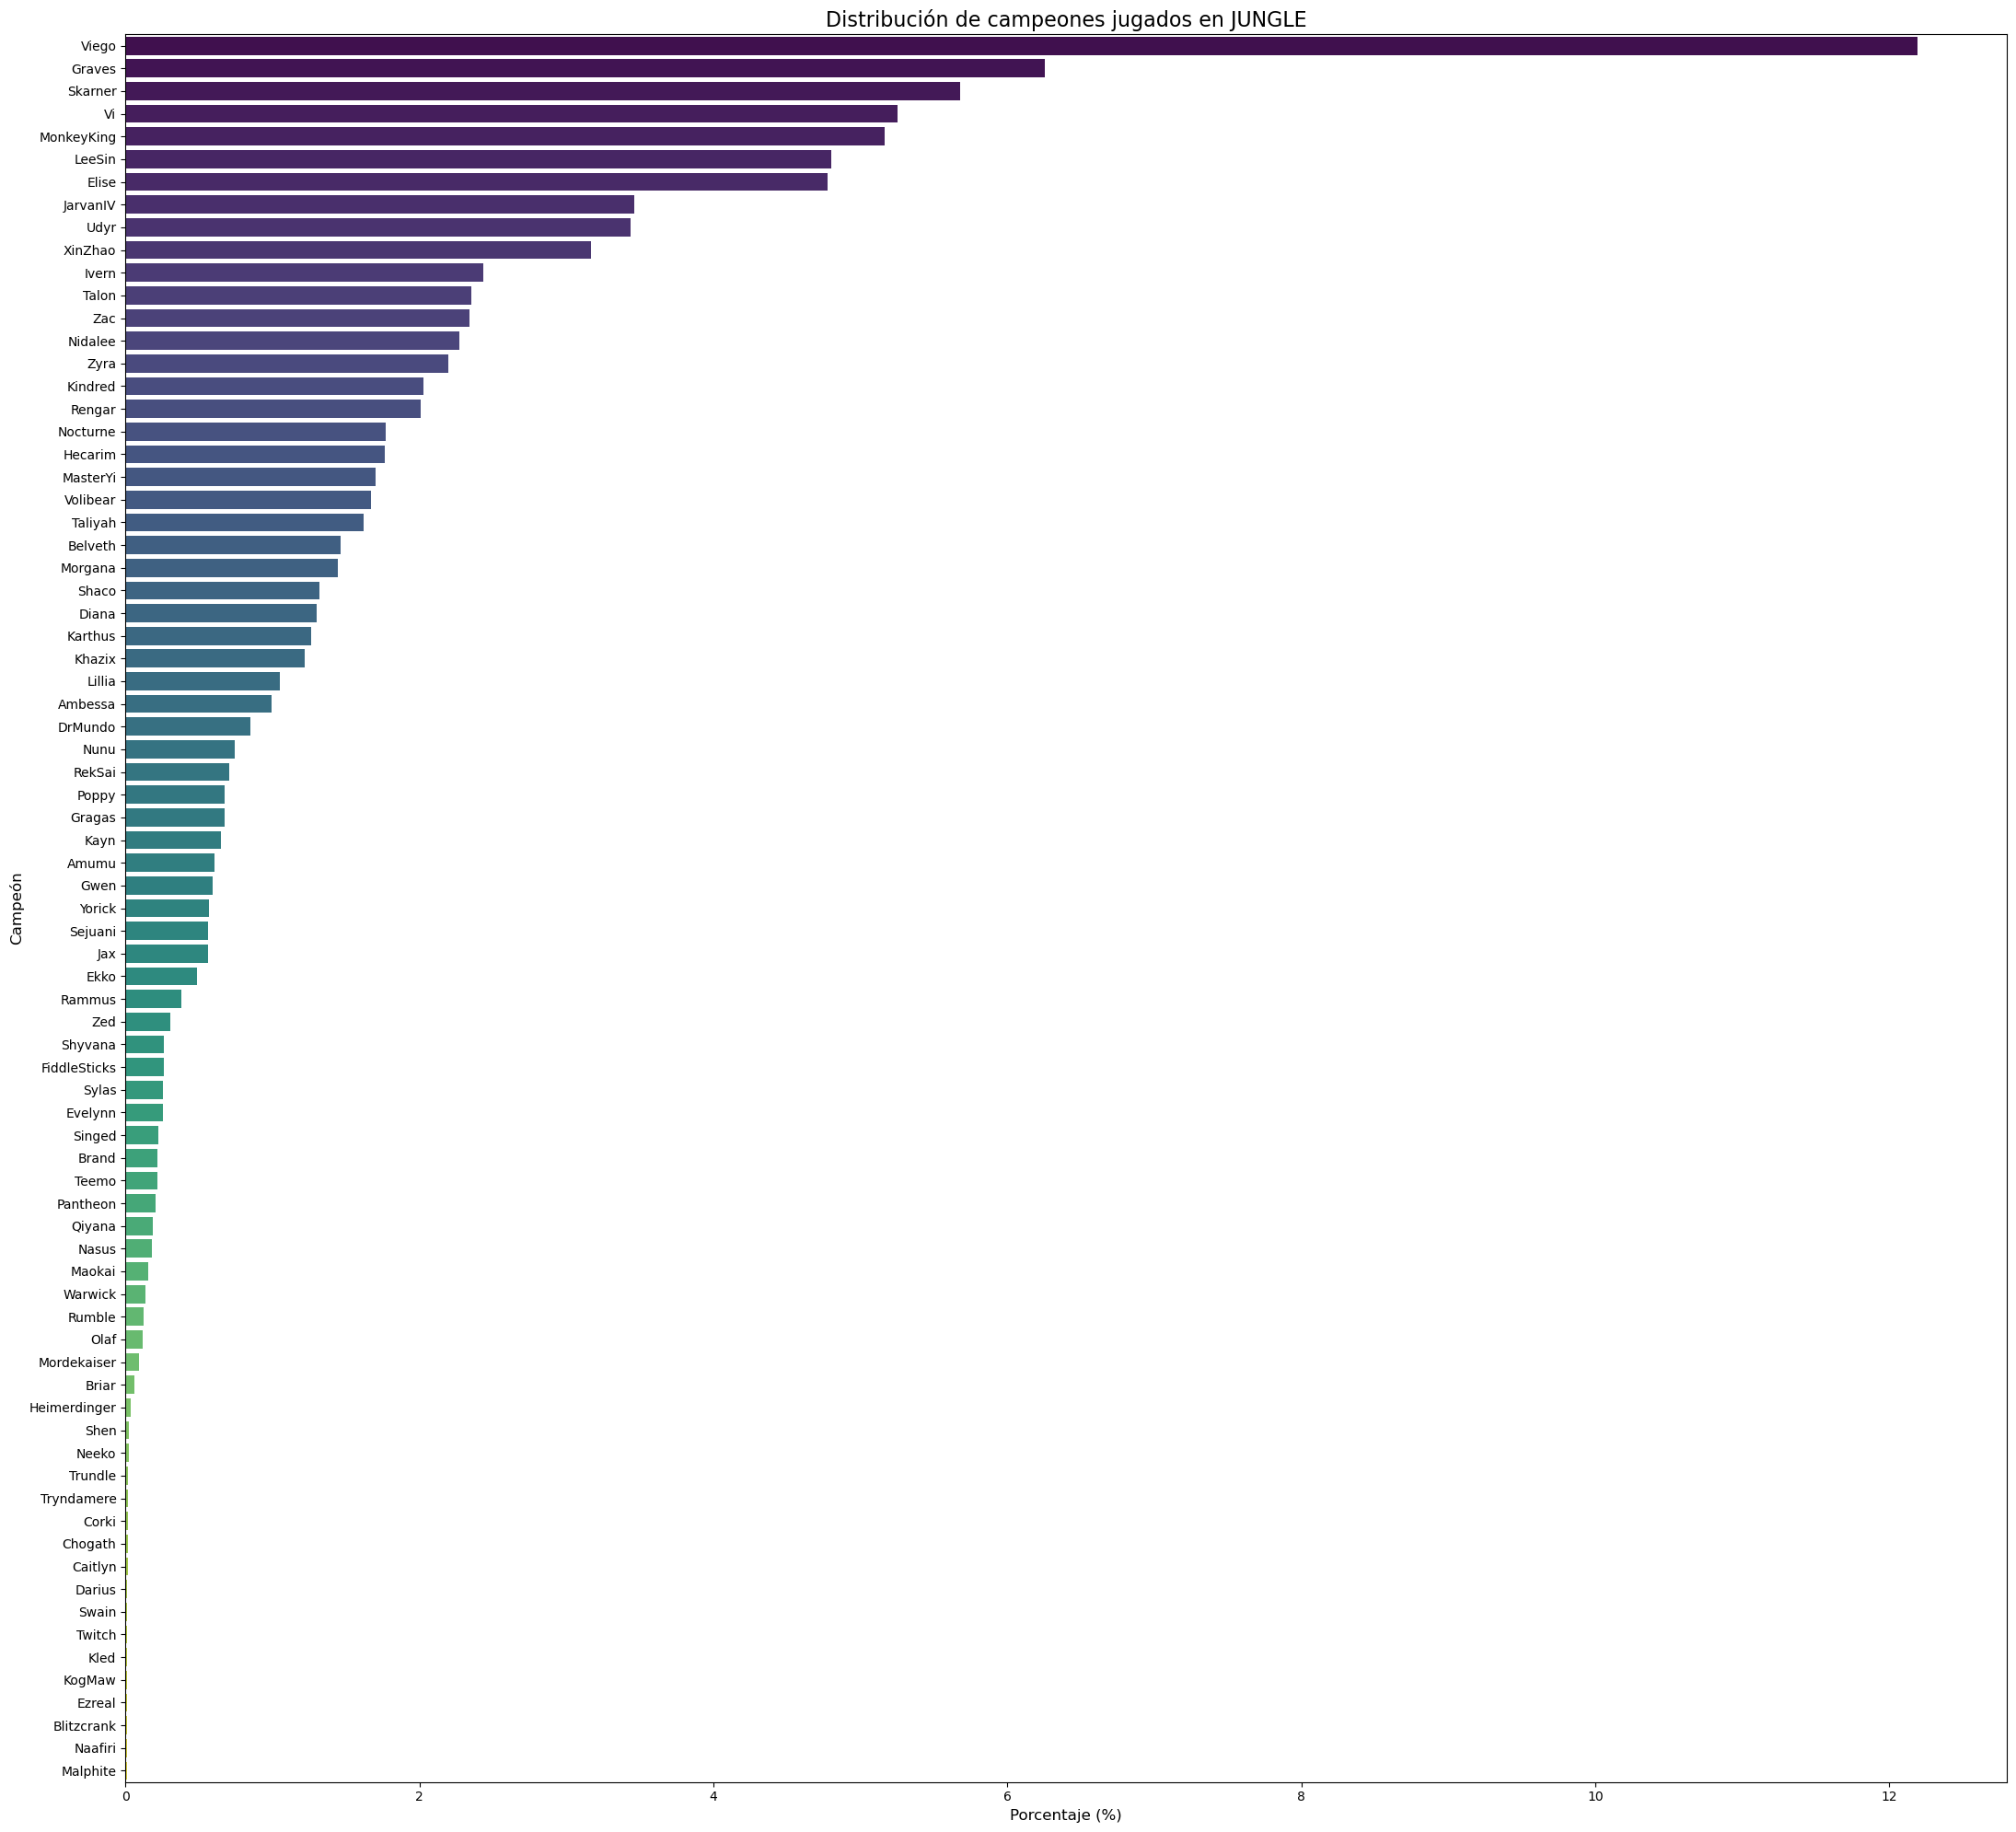

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


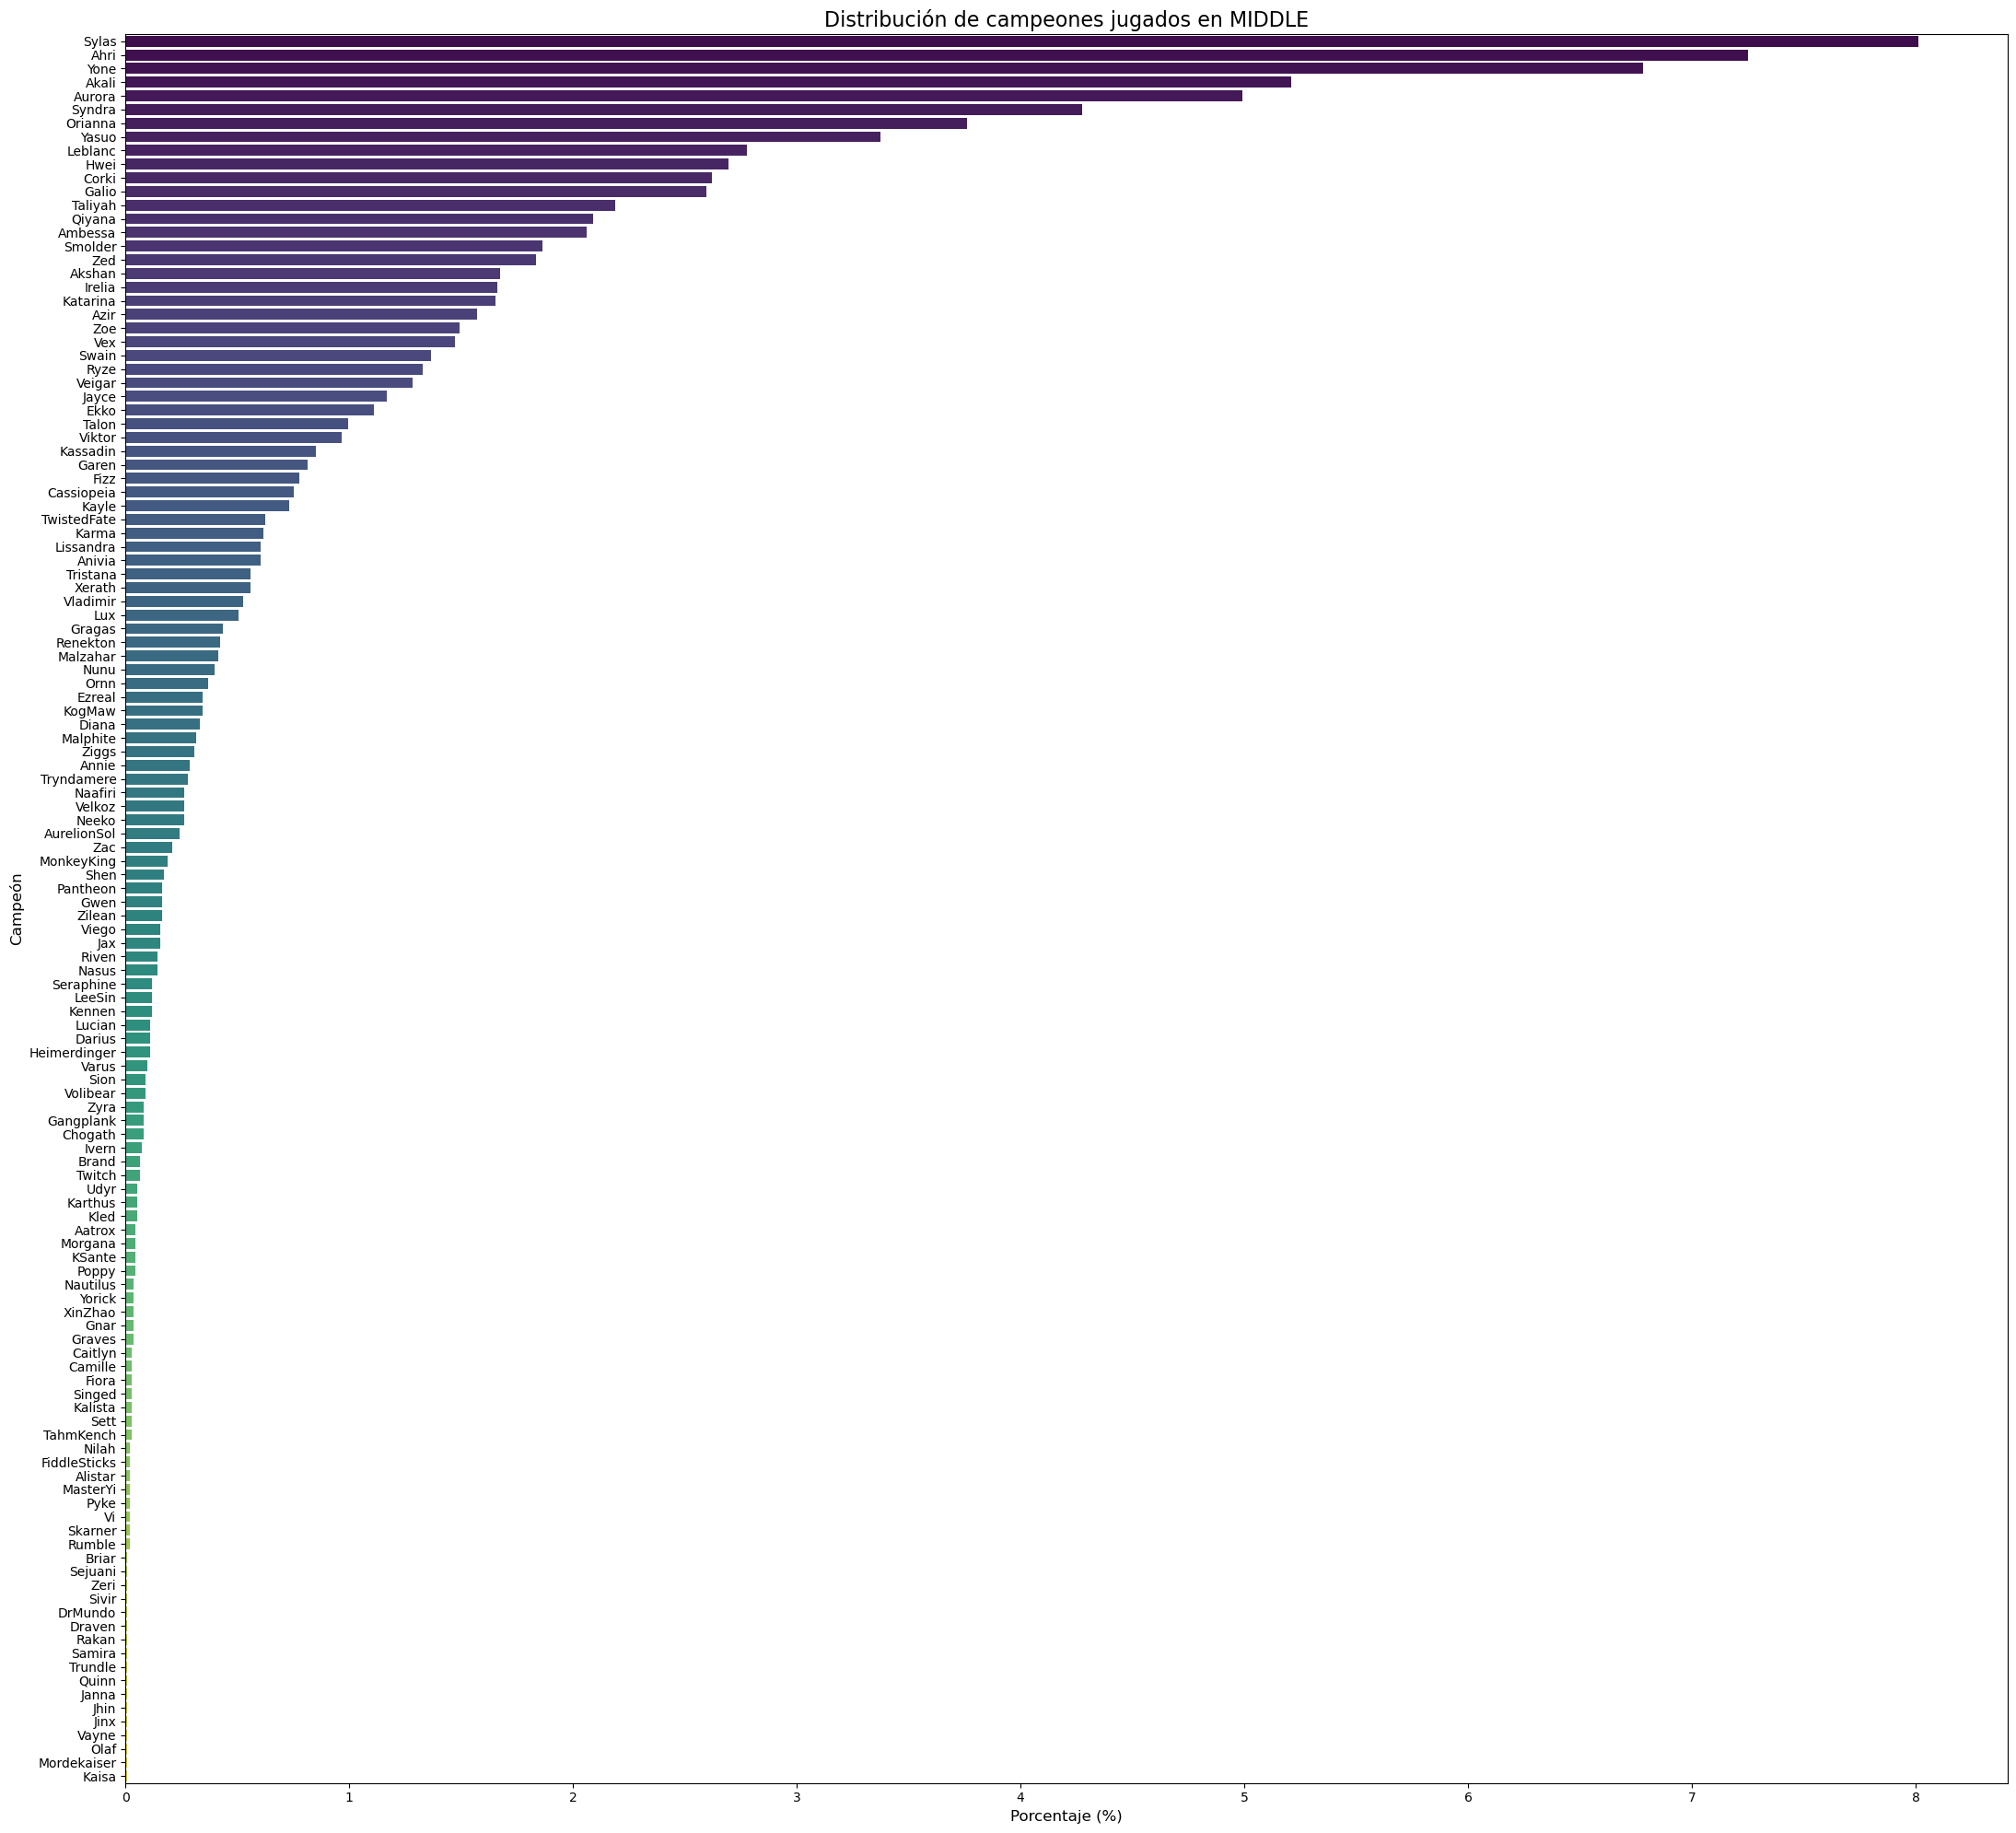

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


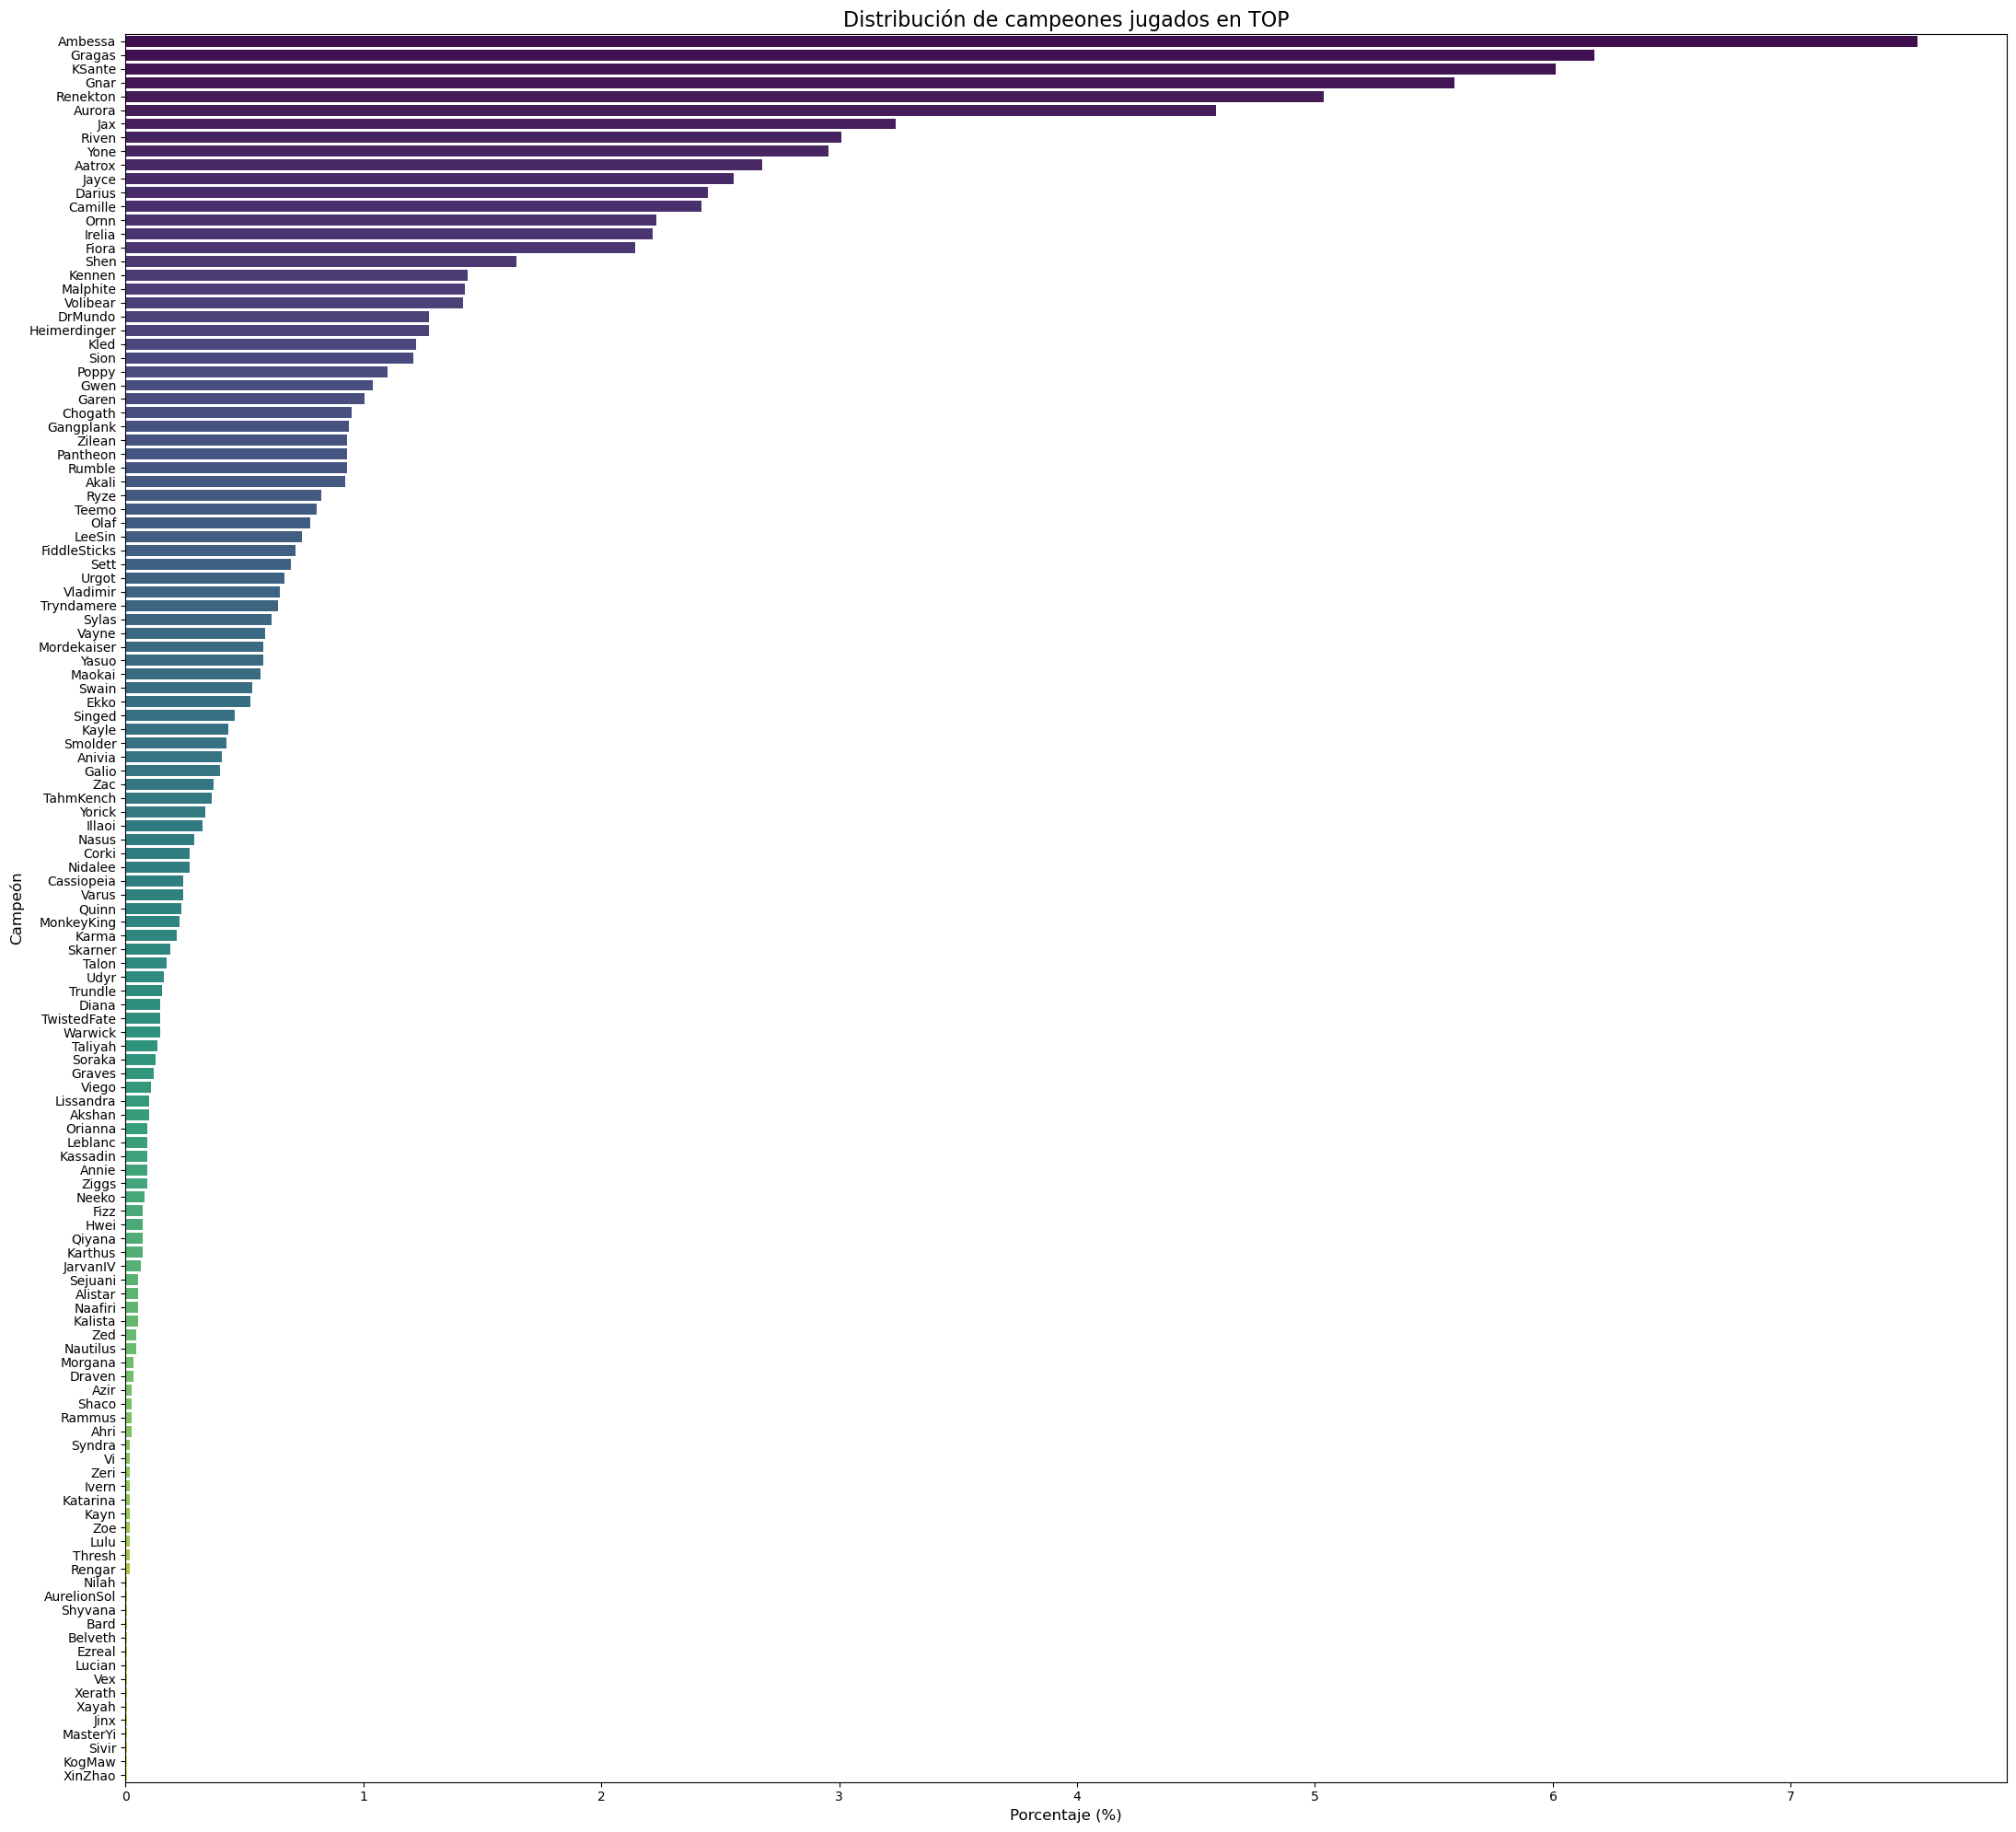

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


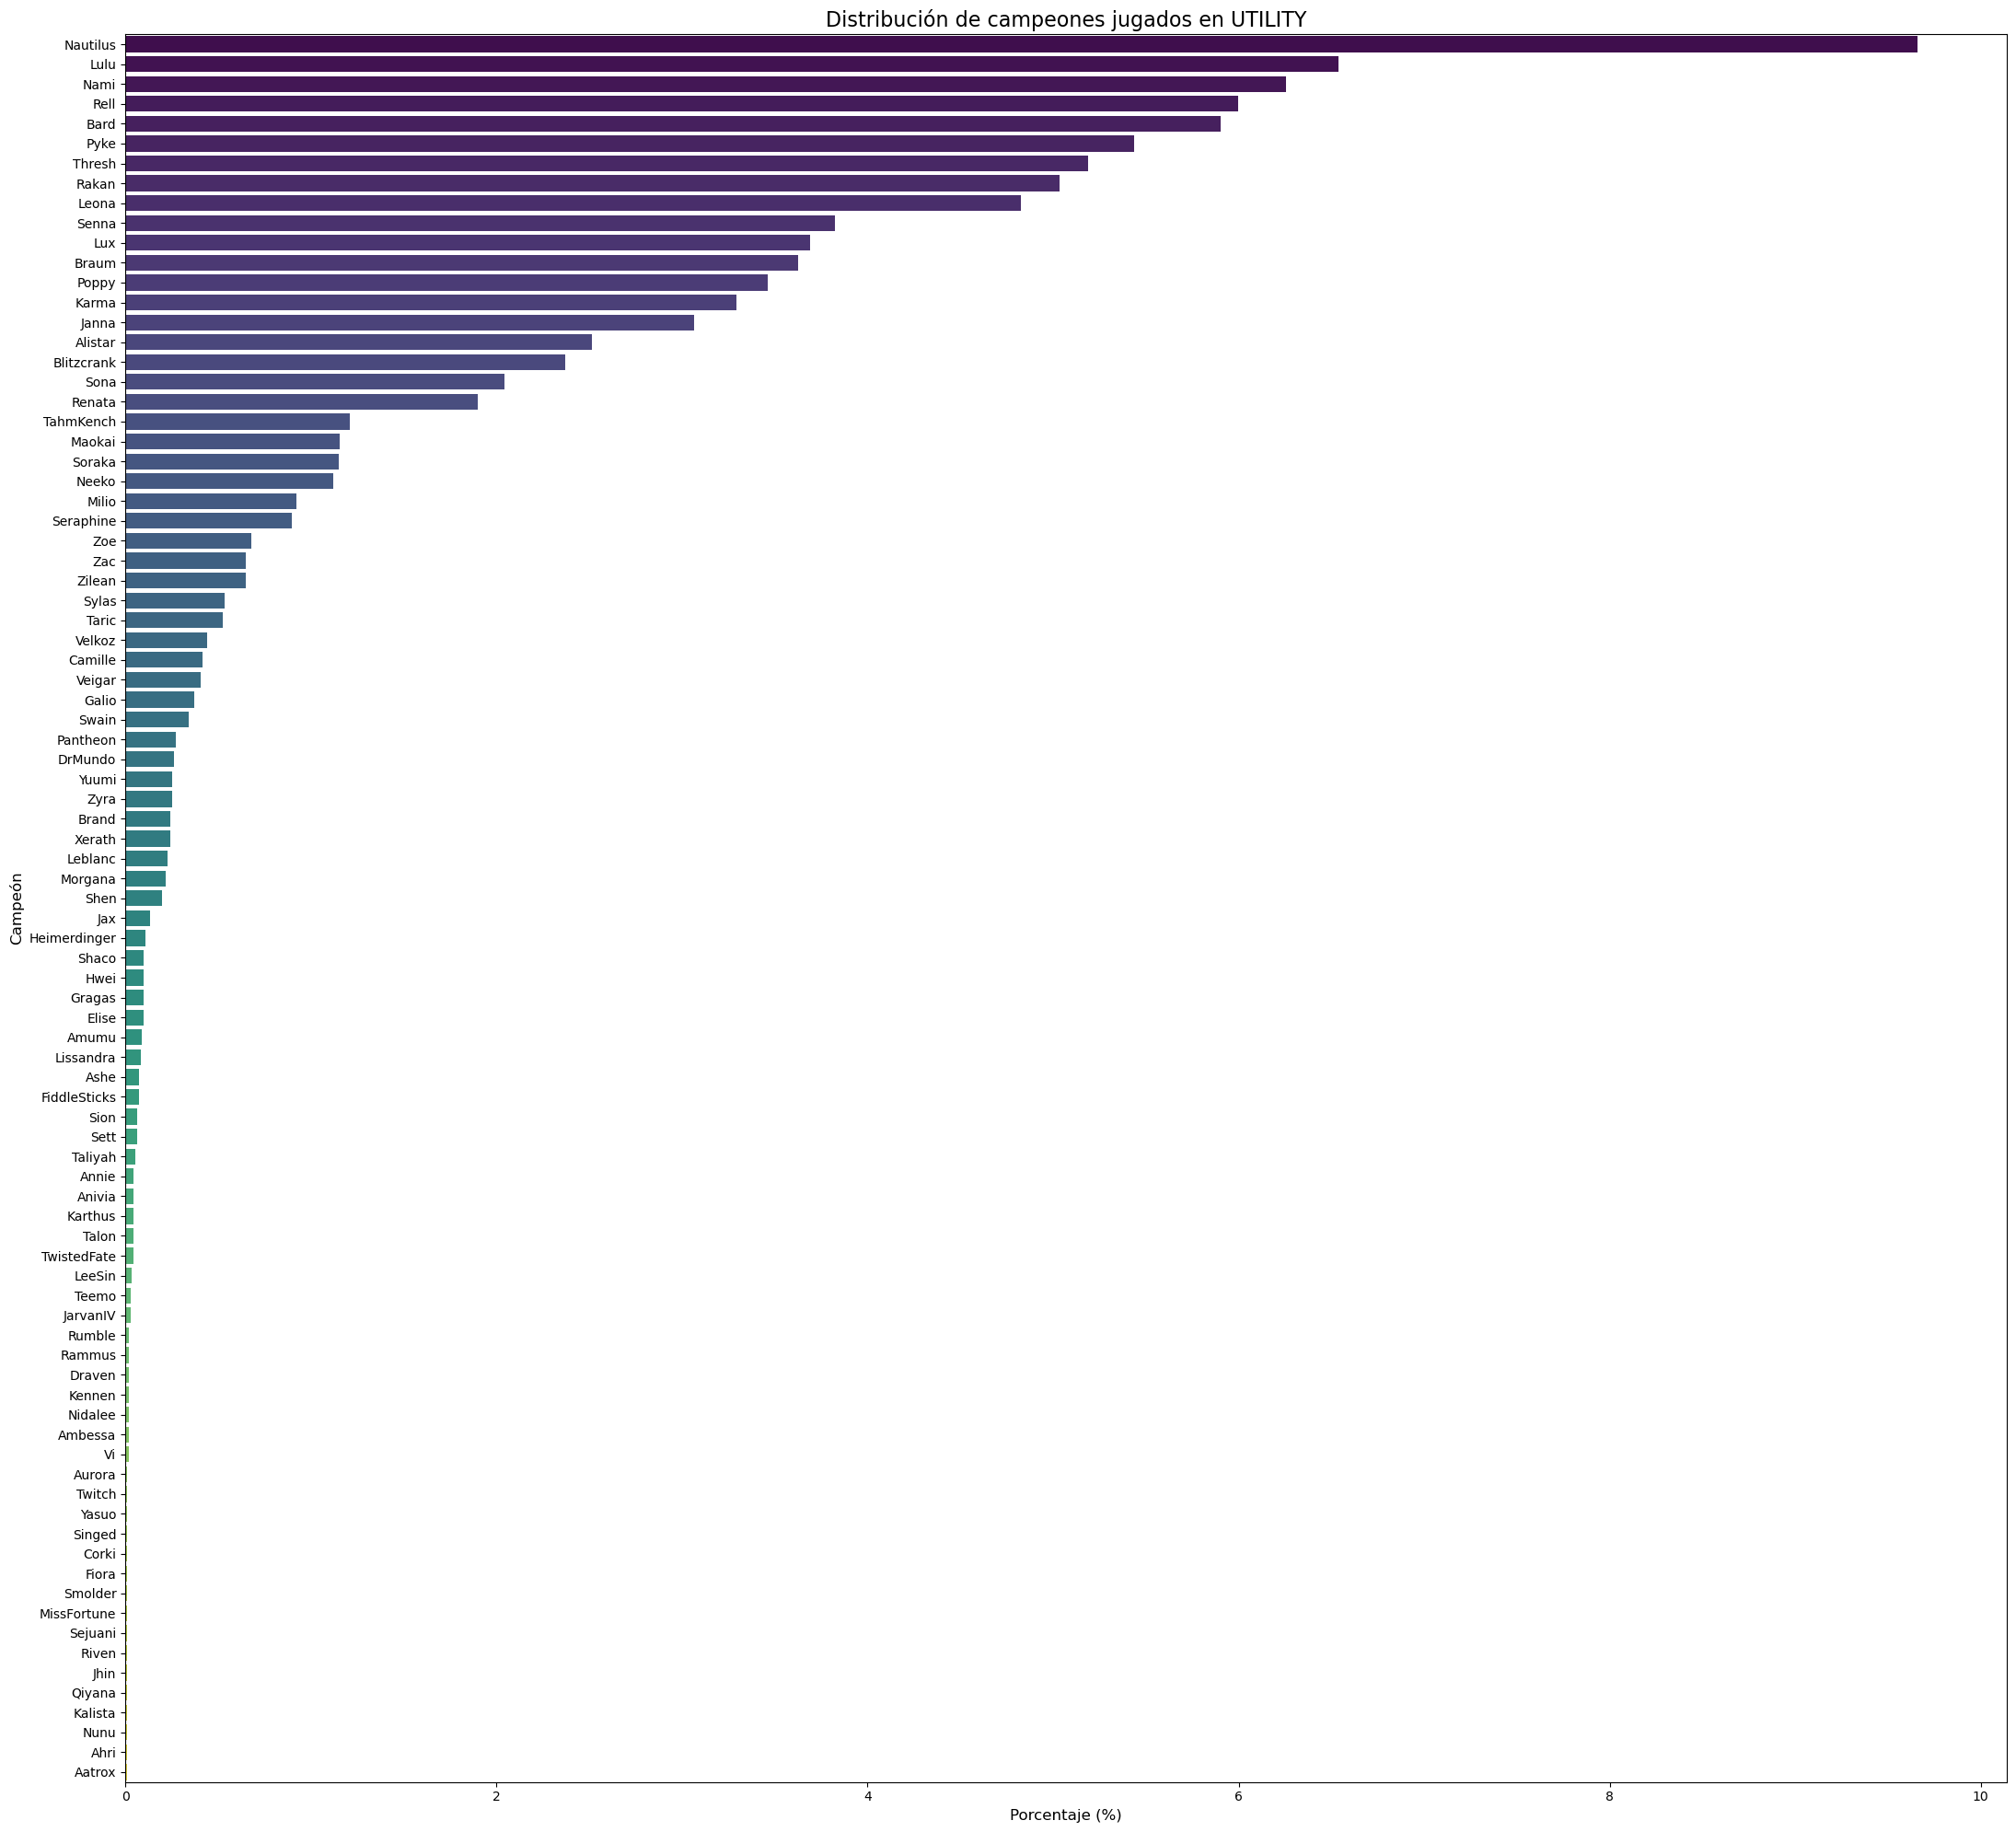

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por rol y campeón, contando las apariciones
role_champion_counts = df.groupby(['team_position', 'champion_name']).size().reset_index(name='count')

# Calcular proporciones por rol
role_champion_counts['proportion'] = role_champion_counts.groupby('team_position')['count'].transform(lambda x: x / x.sum() * 100)

# Roles únicos en el dataset
roles = role_champion_counts['team_position'].unique()

# Crear un gráfico para cada rol
for role in roles:
    plt.figure(figsize=(22, 20))
    data = role_champion_counts[role_champion_counts['team_position'] == role]
    data = data.sort_values('proportion', ascending=False)
    
    sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')
    
    plt.title(f'Distribución de campeones jugados en {role}', fontsize=16)
    plt.xlabel('Porcentaje (%)', fontsize=12)
    plt.ylabel('Campeón', fontsize=12)
    plt.tight_layout()
    plt.show()



KDA
=
Kills
+
Asistencias
/
Muertes

​

In [74]:
# Ejemplo de análisis de KDA
df_ultimo_parche['kda'] = (df_ultimo_parche['kills'] + df_ultimo_parche['assists']) / df_ultimo_parche['deaths']
df_ultimo_parche['kda'] = df_ultimo_parche['kda'].replace([float('inf'), float('-inf')], 'perfecto')
#df_kda_champs = df_ultimo_parche.groupby('champion_name')['kda'].mean().sort_values(ascending=False)

df_ultimo_parche.head(60)

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\2751948136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['kda'] = (df_ultimo_parche['kills'] + df_ultimo_parche['assists']) / df_ultimo_parche['deaths']
C:\Users\chris\AppData\Local\Temp\ipykernel_24088\2751948136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['kda'] = df_ultimo_parche['kda'].replace([float('inf'), float('-inf')], 'perfecto')


match_id  data_version  \
0   EUW1_7210922343             2   
1   EUW1_7210922343             2   
2   EUW1_7210922343             2   
3   EUW1_7210922343             2   
4   EUW1_7210922343             2   
5   EUW1_7210922343             2   
6   EUW1_7210922343             2   
7   EUW1_7210922343             2   
8   EUW1_7210922343             2   
9   EUW1_7210922343             2   
10  EUW1_7210828381             2   
11  EUW1_7210828381             2   
12  EUW1_7210828381             2   
13  EUW1_7210828381             2   
14  EUW1_7210828381             2   
15  EUW1_7210828381             2   
16  EUW1_7210828381             2   
17  EUW1_7210828381             2   
18  EUW1_7210828381             2   
19  EUW1_7210828381             2   
20  EUW1_7210769827             2   
21  EUW1_7210769827             2   
22  EUW1_7210769827             2   
23  EUW1_7210769827             2   
24  EUW1_7210769827             2   
25  EUW1_7210769827             2   
26  EUW1_7210769827             2   
27  EUW1_7210769827             2   
28  EUW1_7210769827             2   
29  EUW1_7210769827             2   
30  EUW1_7210684306             2   
31  EUW1_7210684306             2   
32  EUW1_7210684306             2   
33  EUW1_7210684306             2   
34  EUW1_7210684306             2   
35  EUW1_7210684306             2   
36  EUW1_7210684306             2   
37  EUW1_7210684306             2   
38  EUW1_7210684306             2   
39  EUW1_7210684306             2   
40  EUW1_7209368576             2   
41  EUW1_7209368576             2   
42  EUW1_7209368576             2   
43  EUW1_7209368576             2   
44  EUW1_7209368576             2   
45  EUW1_7209368576             2   
46  EUW1_7209368576             2   
47  EUW1_7209368576             2   
48  EUW1_7209368576             2   
49  EUW1_7209368576             2   
50  EUW1_7209262983             2   
51  EUW1_7209262983             2   
52  EUW1_7209262983             2   
53  EUW1_7209262983             2   
54  EUW1_7209262983             2   
55  EUW1_7209262983             2   
56  EUW1_7209262983             2   
57  EUW1_7209262983             2   
58  EUW1_7209262983             2   
59  EUW1_7209262983             2   

                                         participants  game_creation  \
0   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
1   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
2   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
3   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
4   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
5   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
6   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
7   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
8   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
9   ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
10  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
11  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
12  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
13  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
14  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
15  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
16  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
17  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
18  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
19  ['_SuT_rbb1qp7-dwMtoS_cDSTX1ra_BVaeizDZ_Mw9YfY...  1733084899082   
20  ['oKj8ETLtHV8twTqydFVP1yRG-Kk7LKb2JUOkKkdCtIH8...  1733083212321   
21  ['oKj8ETLtHV8twTqydFVP1yRG-Kk7LKb2JUOkKkdCtIH8...  1733083212321   
22  ['oKj8ETLtHV8twTqydFVP1yRG-Kk7LKb2JUOkKkdCtIH8...  1733083212321   
23  ['oKj8ETLtHV8twTqydFV

### Boxplot de duración de partida según victoria o derrota

In [33]:
df_ultimo_parche['game_duration_minutes'] = df_ultimo_parche['game_duration'] / 60

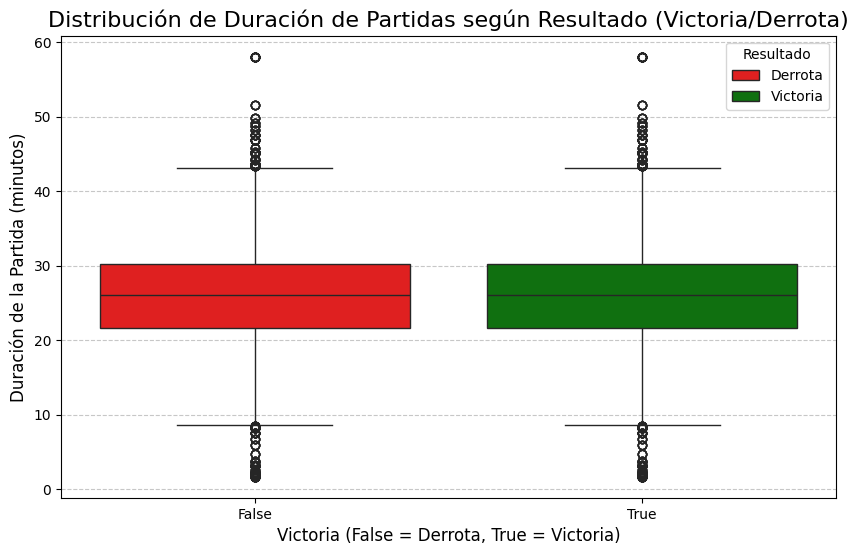

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ultimo_parche, x='win', y='game_duration_minutes', hue='win', 
            palette={True: "green", False: "red"})
plt.title("Distribución de Duración de Partidas según Resultado (Victoria/Derrota)", fontsize=16)
plt.xlabel("Victoria (False = Derrota, True = Victoria)", fontsize=12)
plt.ylabel("Duración de la Partida (minutos)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Resultado", loc="upper right", labels=["Derrota", "Victoria"])
plt.show()

### Top campeones más seleccionados por día.

<Figure size 1400x800 with 0 Axes>

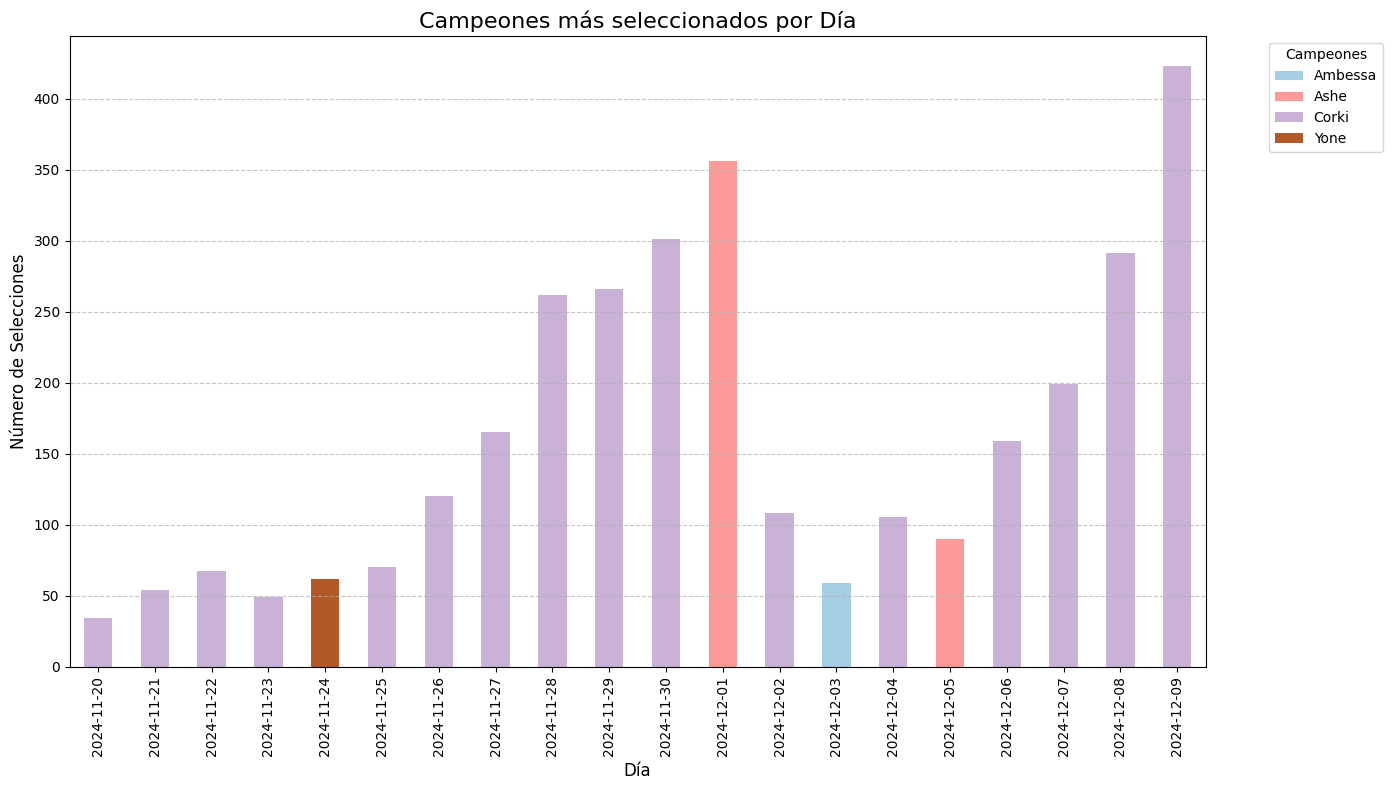

Conteo exacto de campeones por día (Top 10):
champion_name         day  Ambessa   Ashe  Corki  Yone
0              2024-11-20      0.0    0.0   34.0   0.0
1              2024-11-21      0.0    0.0   54.0   0.0
2              2024-11-22      0.0    0.0   67.0   0.0
3              2024-11-23      0.0    0.0   49.0   0.0
4              2024-11-24      0.0    0.0    0.0  62.0
5              2024-11-25      0.0    0.0   70.0   0.0
6              2024-11-26      0.0    0.0  120.0   0.0
7              2024-11-27      0.0    0.0  165.0   0.0
8              2024-11-28      0.0    0.0  262.0   0.0
9              2024-11-29      0.0    0.0  266.0   0.0
10             2024-11-30      0.0    0.0  301.0   0.0
11             2024-12-01      0.0  356.0    0.0   0.0
12             2024-12-02      0.0    0.0  108.0   0.0
13             2024-12-03     59.0    0.0    0.0   0.0
14             2024-12-04      0.0    0.0  105.0   0.0
15             2024-12-05      0.0   90.0    0.0   0.0
16             2024-

In [187]:
df_ultimo_parche['game_start_timestamp'] = pd.to_datetime(df_ultimo_parche['game_start_timestamp'], unit='ms')

df_ultimo_parche['day'] = df_ultimo_parche['game_start_timestamp'].dt.date


# Filtracion de los datos para excluir el día 2024-12-02
df_ultimo_parche = df_ultimo_parche[df_ultimo_parche['day'] != pd.to_datetime('2024-12-10').date()]

# Calcula los campeones más seleccionados por día
top_champions_daily = (
    df_ultimo_parche.groupby(['champion_name', 'day'])
    .size()
    .reset_index(name='count')
    .sort_values(['count'], ascending=False)
)

# Se selecciona el top 10 campeones por día
top_10_champions_daily = top_champions_daily.groupby('day').head(1) #cambiar el head para ver los TOPS

# Reestructura los datos para un gráfico apilado
pivot_data = top_10_champions_daily.pivot(index='day', columns='champion_name', values='count').fillna(0)

plt.figure(figsize=(14, 8))
pivot_data.plot(kind='bar', stacked=True, colormap='Paired', figsize=(14, 8))

plt.title('Campeones más seleccionados por Día', fontsize=16)
plt.xlabel('Día', fontsize=12)
plt.ylabel('Número de Selecciones', fontsize=12)
plt.legend(title='Campeones', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Datos exactos en una tabla sobre los top 10 campeones seleccionados por día
tabla_top_champions = pivot_data.reset_index()

print("Conteo exacto de campeones por día (Top 10):")
print(tabla_top_champions)
tabla_top_champions.to_csv("top10campeones_diario.csv")




In [122]:

df_ultimo_parche['game_date'] = df_ultimo_parche['game_start_timestamp'].dt.floor('D')

C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2646425197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_date'] = df_ultimo_parche['game_start_timestamp'].dt.floor('D')


In [188]:
# Convertir las marcas de tiempo a formato de fecha
fecha_min = pd.to_datetime(df_ultimo_parche['game_end_timestamp'].min(), unit='ms')
fecha_max = pd.to_datetime(df_ultimo_parche['game_end_timestamp'].max(), unit='ms')

print(f"Fecha mínima: {fecha_min}")
print(f"Fecha máxima: {fecha_max}")


Fecha mínima: 2024-11-20 09:25:04.616000
Fecha máxima: 2024-12-10 00:23:01.768000


### Comportamiento de los Jugadores en Días Laborales y Fines de Semana

Número de partidas jugadas en días laborales vs fines de semana.

In [189]:
df_ultimo_parche.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104690 entries, 0 to 113559
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   match_id                         104690 non-null  object        
 1   data_version                     104690 non-null  int64         
 2   participants                     104690 non-null  object        
 3   game_creation                    104690 non-null  int64         
 4   game_duration                    104690 non-null  int64         
 5   game_end_timestamp               104690 non-null  int64         
 6   game_start_timestamp             104690 non-null  datetime64[ns]
 7   game_mode                        104690 non-null  object        
 8   game_version                     104690 non-null  object        
 9   team_id                          104690 non-null  int64         
 10  summoner_name                    98181 non-null  

C:\Users\HP\AppData\Local\Temp\ipykernel_1104\3719205853.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ultimo_parche.groupby(['day_name', 'day_type'])['match_id']


<Figure size 1200x600 with 0 Axes>

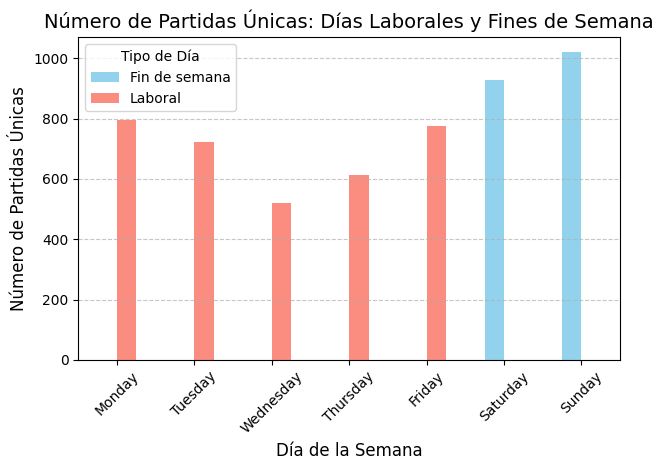

In [42]:
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_creation'].dt.dayofweek

# Crea una nueva columna que categorice los días como laborales (lunes a viernes) o fin de semana (sábado y domingo)
df_ultimo_parche['day_type'] = df_ultimo_parche['day_of_week'].apply(lambda x: 'Laboral' if x < 5 else 'Fin de semana')

df_ultimo_parche['day_name'] = df_ultimo_parche['game_creation'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_ultimo_parche['day_name'] = pd.Categorical(df_ultimo_parche['day_name'], categories=ordered_days, ordered=True)

# cuenta partidas únicas por día de la semana y tipo de día
game_count_by_day_type = (
    df_ultimo_parche.groupby(['day_name', 'day_type'])['match_id']
    .nunique()  # Asegura que cada partida se cuenta una sola vez
    .unstack()  # Divide por tipo de día (Laboral o Fin de semana)
)

plt.figure(figsize=(12, 6))
game_count_by_day_type.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'], alpha=0.9)
plt.title('Número de Partidas Únicas: Días Laborales y Fines de Semana', fontsize=14)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Número de Partidas Únicas', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Tipo de Día', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
plt.show()



In [191]:
tabla_game_count = game_count_by_day_type.reset_index()

print("Número partidas jugadas dias laborales y fin de semana:")
print(tabla_game_count)

Número partidas jugadas dias laborales y fin de semana:
day_type   day_name  Fin de semana  Laboral
0            Monday              0      796
1           Tuesday              0      391
2         Wednesday              0      520
3          Thursday              0      613
4            Friday              0      777
5          Saturday            929        0
6            Sunday           1020        0


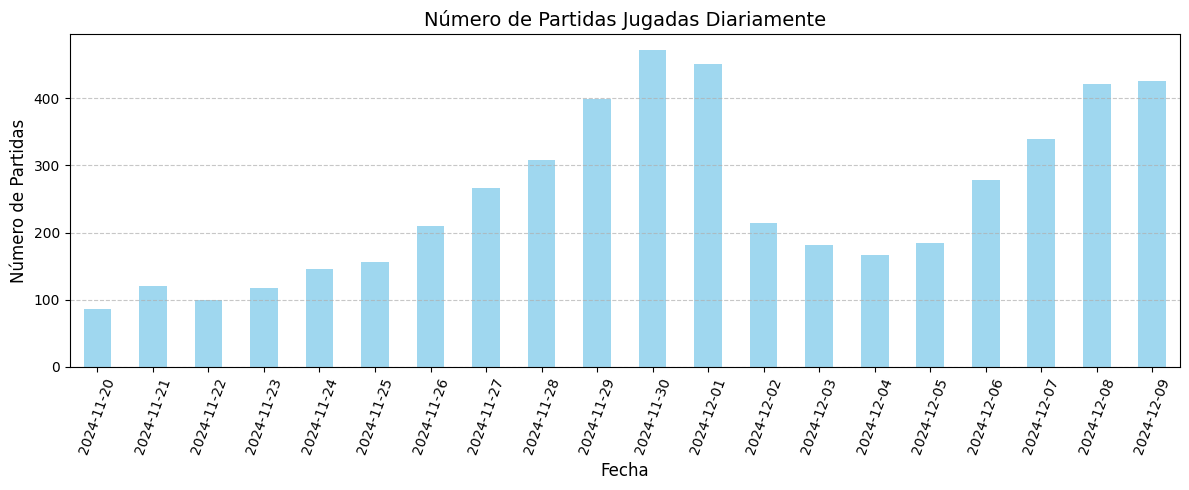

In [195]:
import matplotlib.pyplot as plt

# Convertir la columna 'game_creation' a formato datetime
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Crear una columna con la fecha (sin hora) para agrupar los datos por día
df_ultimo_parche['game_date'] = df_ultimo_parche['game_creation'].dt.date

# Contador de número de partidas únicas por cada día
#game_count_by_date = df_ultimo_parche.groupby('game_date')['match_id'].nunique()

game_count_by_date = (
    df_ultimo_parche.groupby(['game_date'])['match_id']
    .nunique()  # Asegura que cada partida se cuenta una sola vez
    .rename('game_counter')
)

# Crear el gráfico
plt.figure(figsize=(12, 5))
game_count_by_date.plot(kind='bar', color='skyblue', alpha=0.8)

plt.title('Número de Partidas Jugadas Diariamente', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Partidas', fontsize=12)
plt.xticks(rotation=70, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [196]:
tabla_game_count = game_count_by_date.reset_index()

print("Número partidas jugadas por día:")
print(tabla_game_count)


Número partidas jugadas por día:
     game_date  game_counter
0   2024-11-20            86
1   2024-11-21           121
2   2024-11-22           100
3   2024-11-23           117
4   2024-11-24           146
5   2024-11-25           156
6   2024-11-26           210
7   2024-11-27           267
8   2024-11-28           308
9   2024-11-29           399
10  2024-11-30           472
11  2024-12-01           452
12  2024-12-02           214
13  2024-12-03           181
14  2024-12-04           167
15  2024-12-05           184
16  2024-12-06           278
17  2024-12-07           340
18  2024-12-08           422
19  2024-12-09           426


### Distribución de victorias por día de semana y horas

In [129]:
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Extrae el día de la semana (0=lunes, 6=domingo)
#df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_creation'].dt.dayofweek

# Extrae la hora de inicio
df_ultimo_parche['hour_of_day'] = df_ultimo_parche['game_creation'].dt.hour



C:\Users\HP\AppData\Local\Temp\ipykernel_16136\1428698339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\1428698339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['hour_of_day'] = df_ultimo_parche['game_creation'].dt.hour


In [130]:
df_ultimo_parche['win'].value_counts()



win
False    24855
True     24855
Name: count, dtype: int64

In [131]:
# Filtro solo partidas ganadas
df_wins = df_ultimo_parche[df_ultimo_parche['win'] == True]

# Cuenta las partidas únicas ganadas por día de la semana y hora
win_counts = (
    df_wins.groupby(['day_of_week', 'hour_of_day'])['match_id']
    .nunique()  # contador de partidas únicas
    .unstack(fill_value=0)  
)

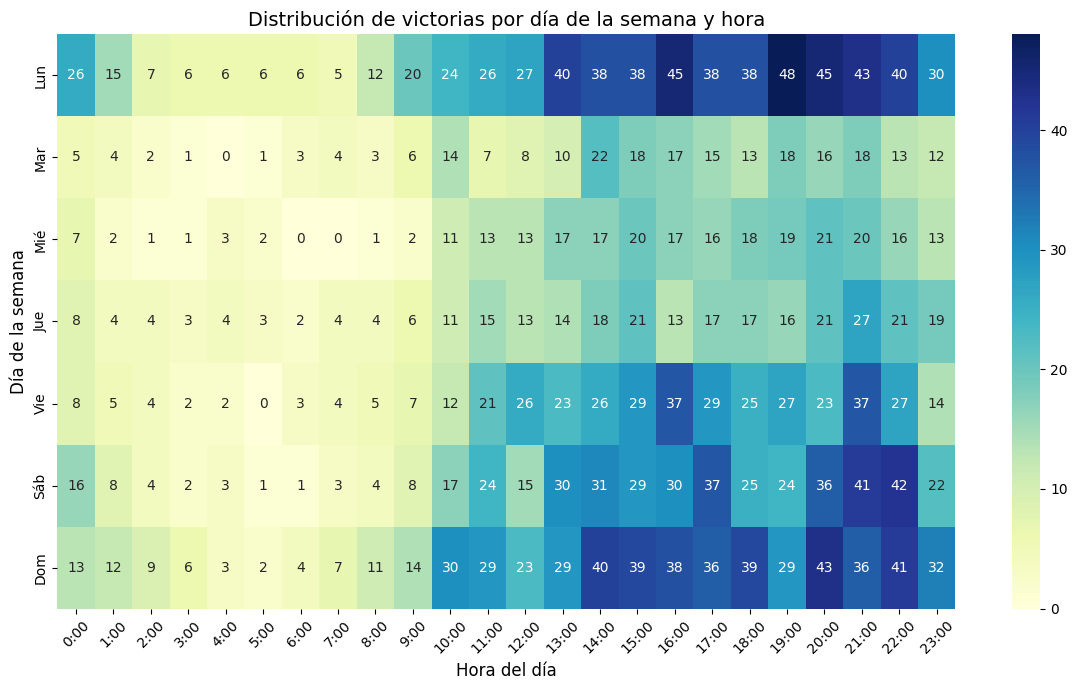

In [132]:
plt.figure(figsize=(12, 7))
sns.heatmap(win_counts, annot=True, fmt="d", cmap="YlGnBu", cbar=True, 
            xticklabels=[f'{h}:00' for h in range(24)],  # Etiquetas para las horas
            yticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])  # Etiquetas para días
plt.title('Distribución de victorias por día de la semana y hora', fontsize=14)
plt.xlabel('Hora del día', fontsize=12)
plt.ylabel('Día de la semana', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout() 
plt.show()

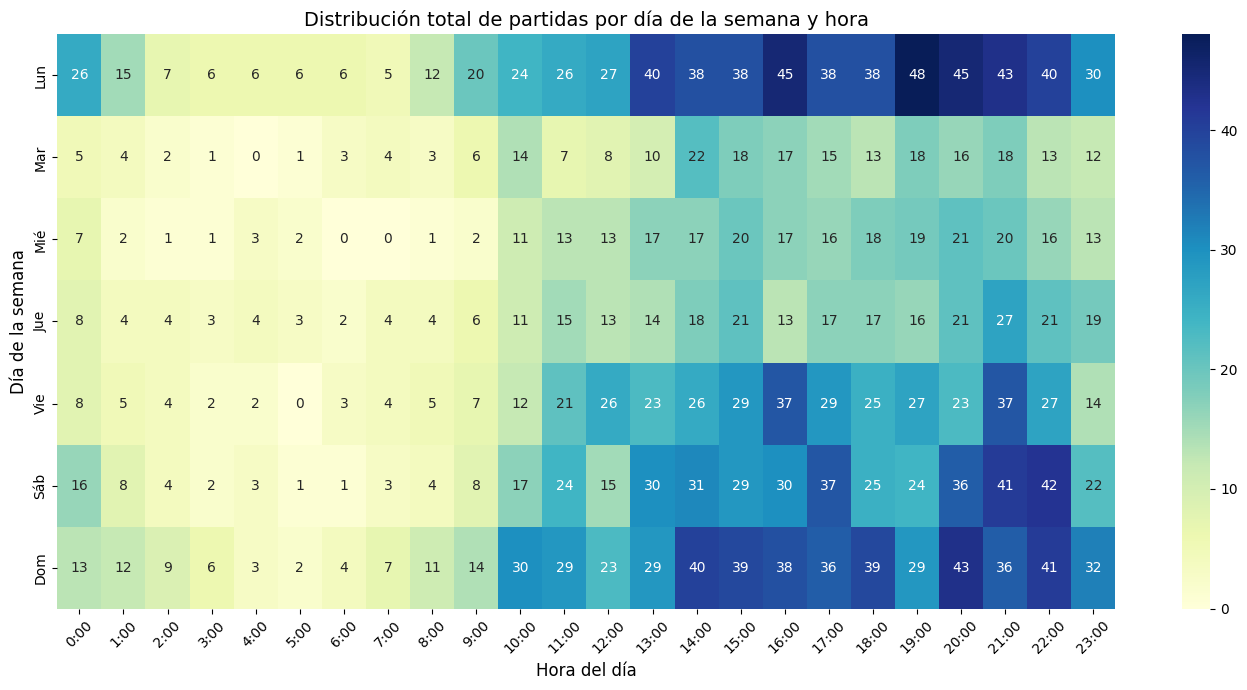

In [78]:
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Extrae el día de la semana (0=lunes, 6=domingo) y la hora del día
#df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_creation'].dt.dayofweek
df_ultimo_parche['hour_of_day'] = df_ultimo_parche['game_creation'].dt.hour

# Conteo total de partidas únicas por día y hora
total_counts = (
    df_ultimo_parche.groupby(['day_of_week', 'hour_of_day'])['match_id']
    .nunique() 
    .unstack(fill_value=0)  
)

# Crear heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(total_counts, annot=True, fmt="d", cmap="YlGnBu", cbar=True, 
            xticklabels=[f'{h}:00' for h in range(24)],  # Etiquetas para las horas
            yticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])  # Etiquetas para días
plt.title('Distribución total de partidas por día de la semana y hora', fontsize=14)
plt.xlabel('Hora del día', fontsize=12)
plt.ylabel('Día de la semana', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  
plt.show()


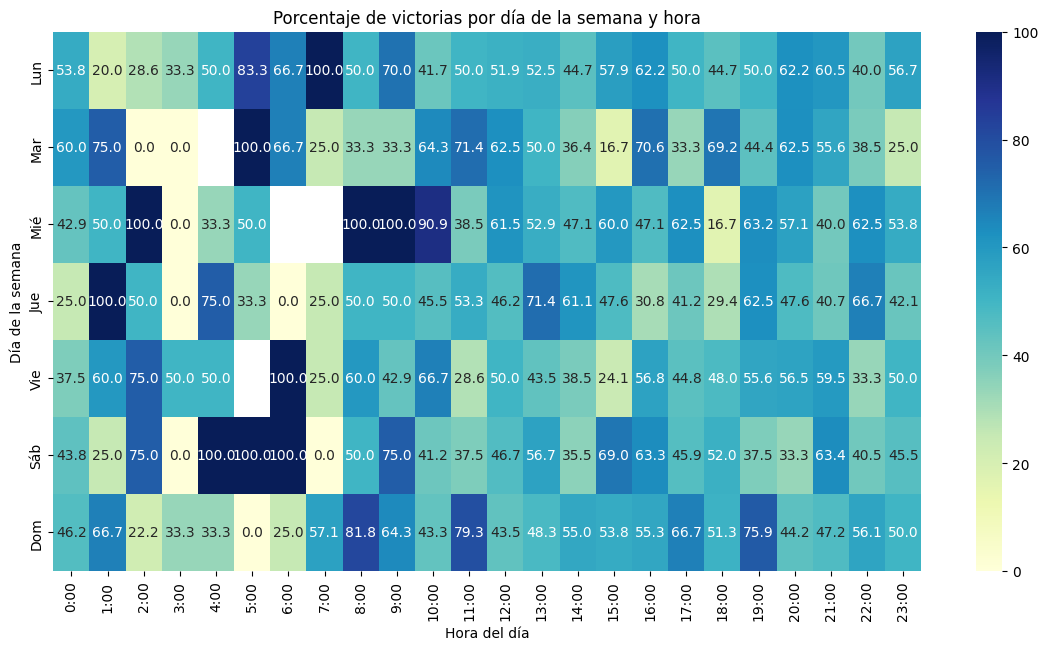

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_unique_matches = df_ultimo_parche.groupby('match_id').first().reset_index()

df_unique_matches['game_creation'] = pd.to_datetime(df_unique_matches['game_creation'], unit='ms')
df_unique_matches['day_of_week'] = df_unique_matches['game_creation'].dt.dayofweek
df_unique_matches['hour_of_day'] = df_unique_matches['game_creation'].dt.hour

# Total de partidas jugadas por día y hora
total_games = (
    df_unique_matches.groupby(['day_of_week', 'hour_of_day'])['match_id']
    .nunique()  # cuenta partidas únicas
    .unstack(fill_value=0)  
)

# Total de partidas ganadas por día y hora
total_wins = (
    df_unique_matches[df_unique_matches['win'] == True]
    .groupby(['day_of_week', 'hour_of_day'])['match_id']
    .nunique()  # cuenta partidas ganadas únicas
    .unstack(fill_value=0)  
)

# Porcentaje de victorias
win_percentage = (total_wins / total_games) * 100

plt.figure(figsize=(14, 7))
sns.heatmap(win_percentage, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, 
            xticklabels=['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00',
                         '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'],
            yticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

plt.title('Porcentaje de victorias por día de la semana y hora')
plt.xlabel('Hora del día')
plt.ylabel('Día de la semana')
plt.show()


In [134]:
df_ultimo_parche['game_end_timestamp'] = pd.to_datetime(df_ultimo_parche['game_end_timestamp'], unit='ms')

# fechas mínima y máxima
fecha_min = df_ultimo_parche['game_end_timestamp'].min()
fecha_max = df_ultimo_parche['game_end_timestamp'].max()

print(f"Fecha mínima: {fecha_min}")
print(f"Fecha máxima: {fecha_max}")

Fecha mínima: 2024-11-20 09:25:04.616000
Fecha máxima: 2024-12-10 00:23:01.768000


C:\Users\HP\AppData\Local\Temp\ipykernel_16136\1349592919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_end_timestamp'] = pd.to_datetime(df_ultimo_parche['game_end_timestamp'], unit='ms')


### Análisis de la relación entre la selección de campeones y la tasa de victoria según el día.

Este análisis ayuda a identificar campeones más efectivos por día. Se podría descubrir que ciertos campeones tienen mayores tasas de victoria en días específicos. Esto podría deberse a que los jugadores que los seleccionan son más experimentados o porque hay menos competencia contra ciertos estilos de juego en esos días.

C:\Users\HP\AppData\Local\Temp\ipykernel_16136\3196448618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')


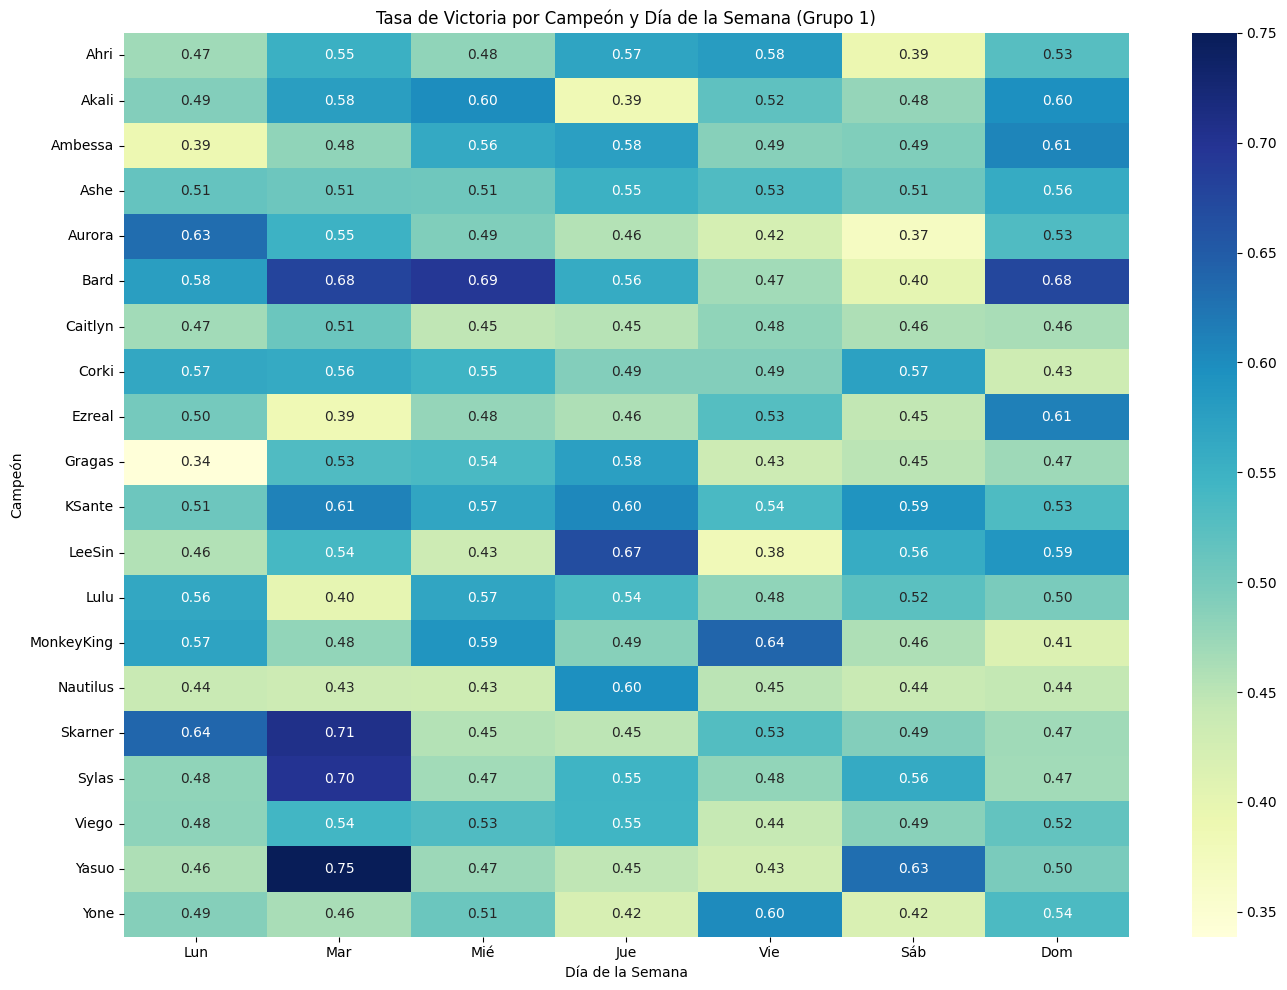

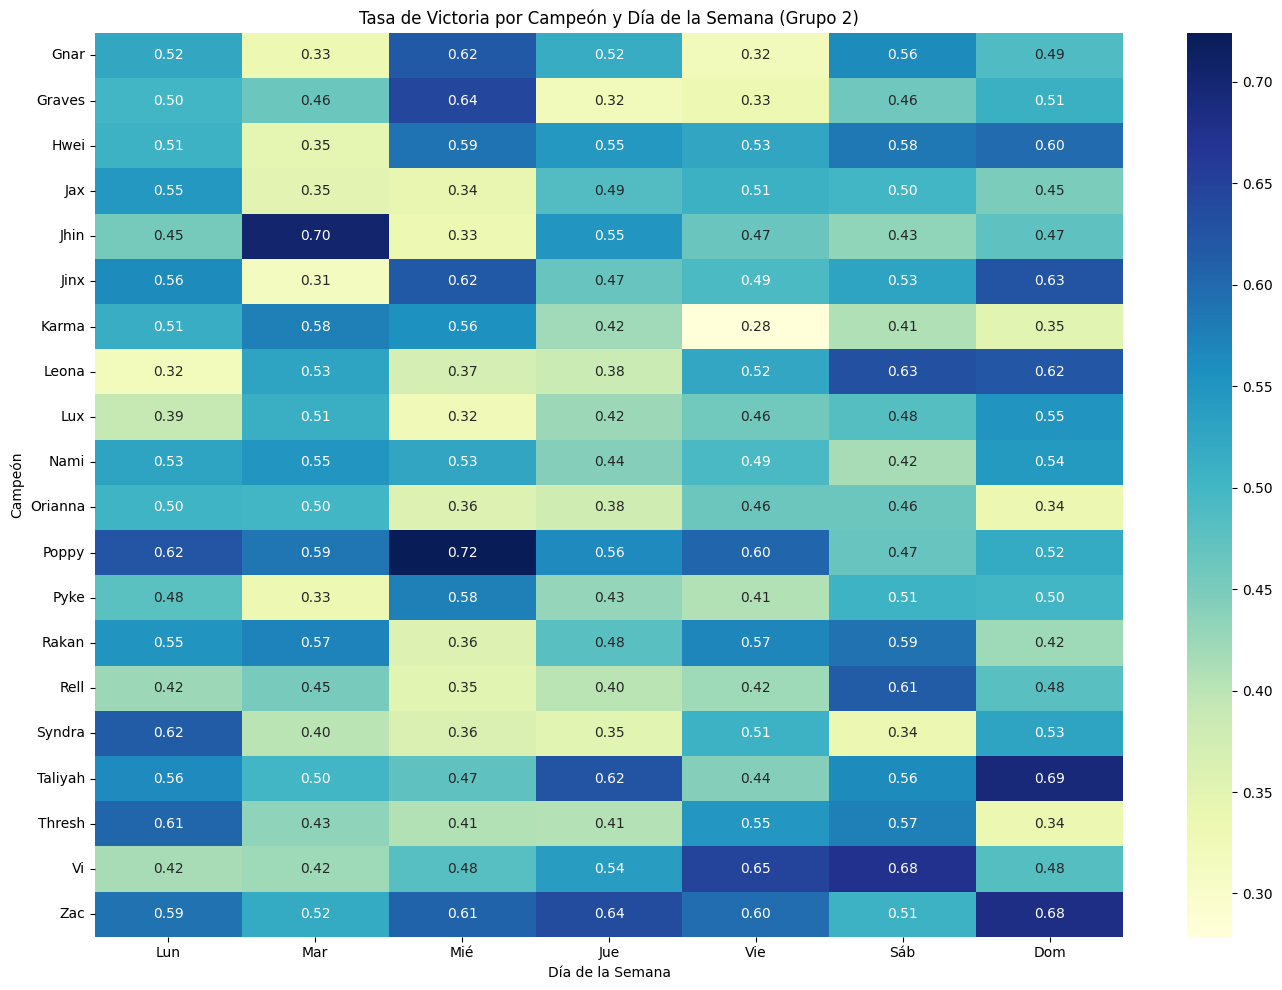

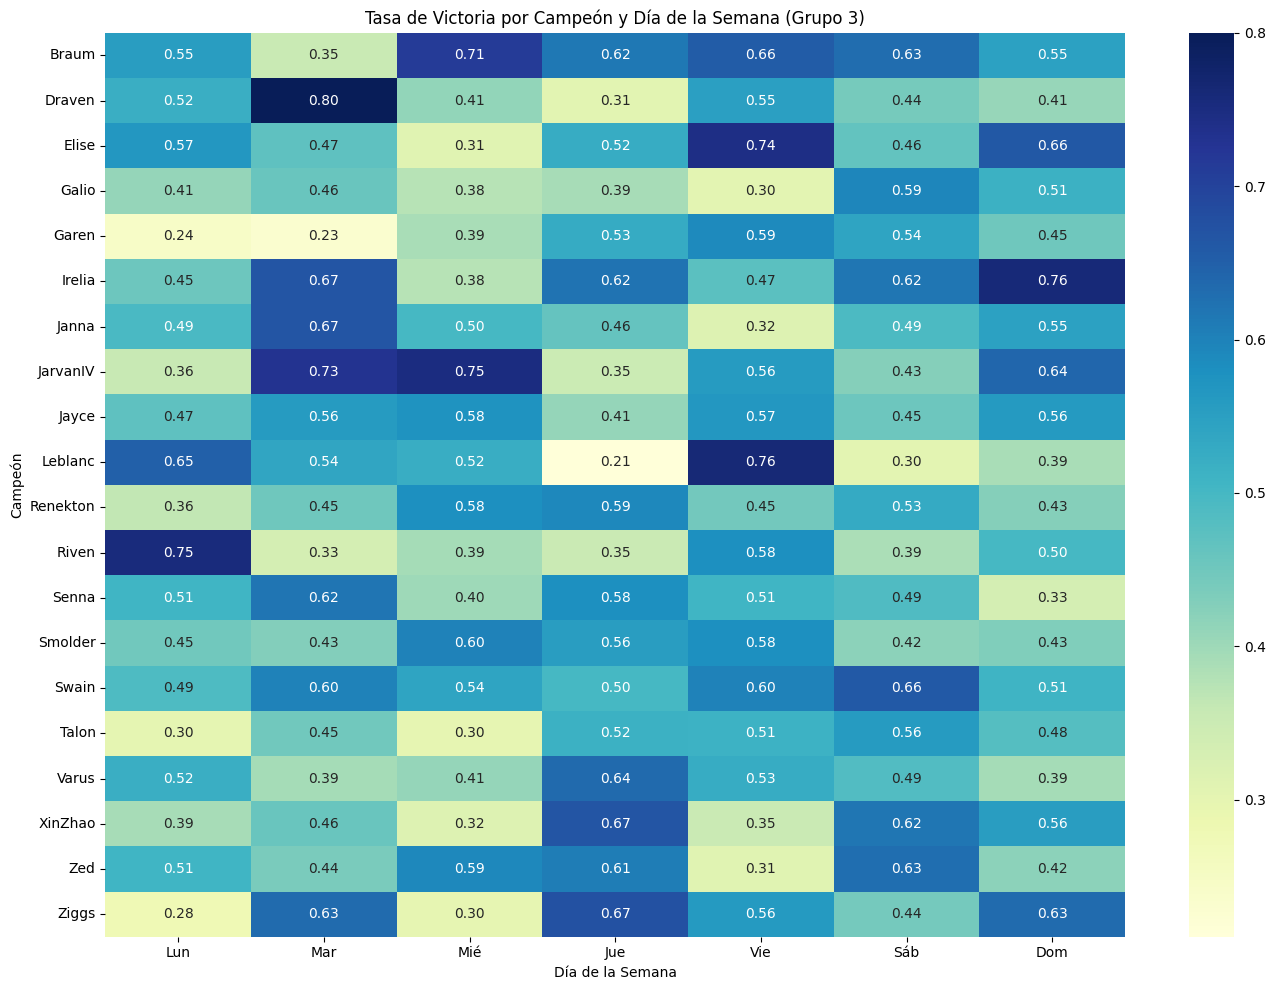

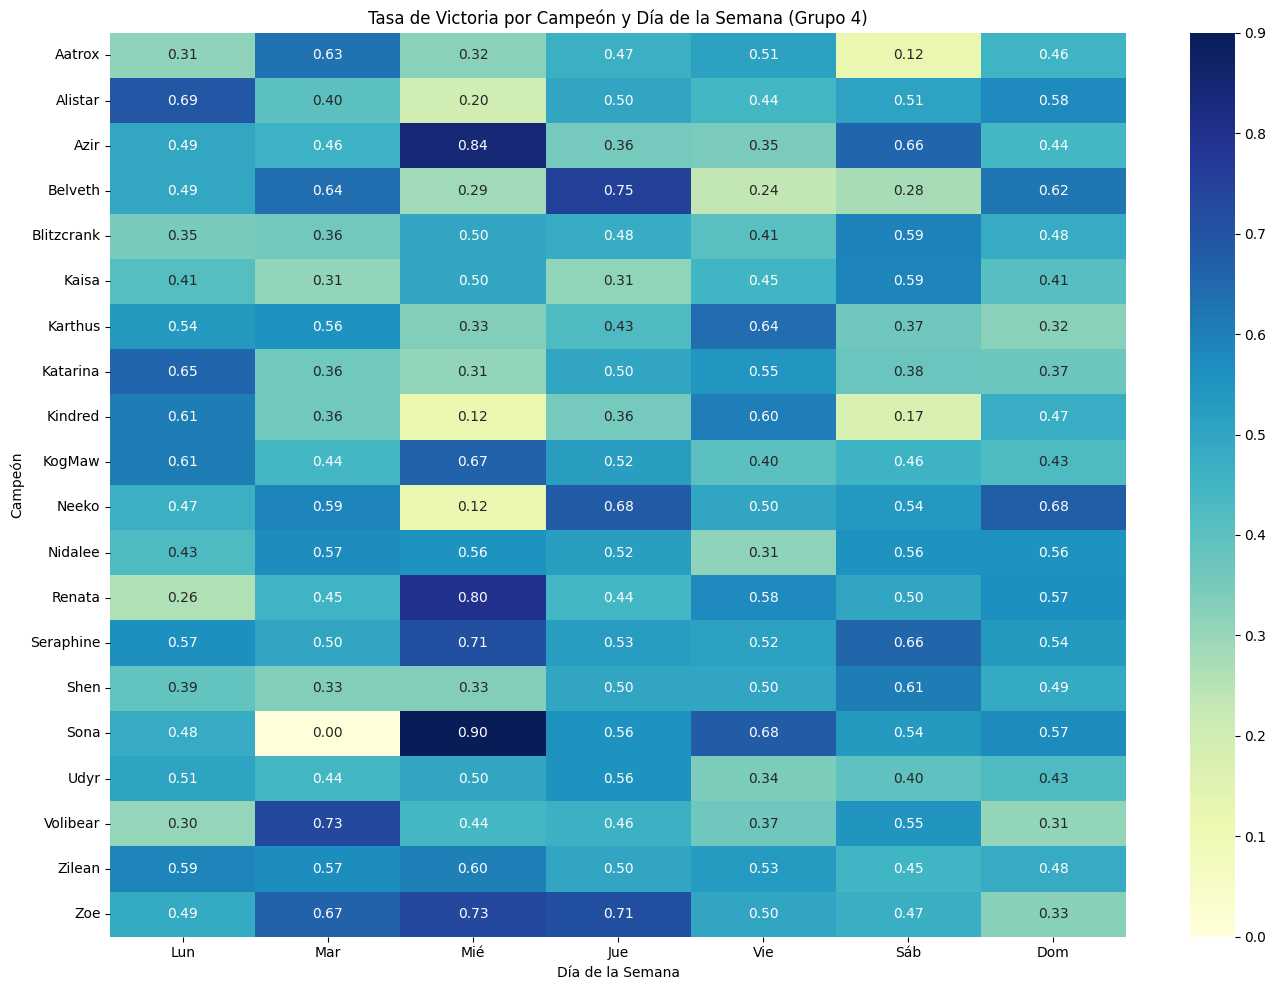

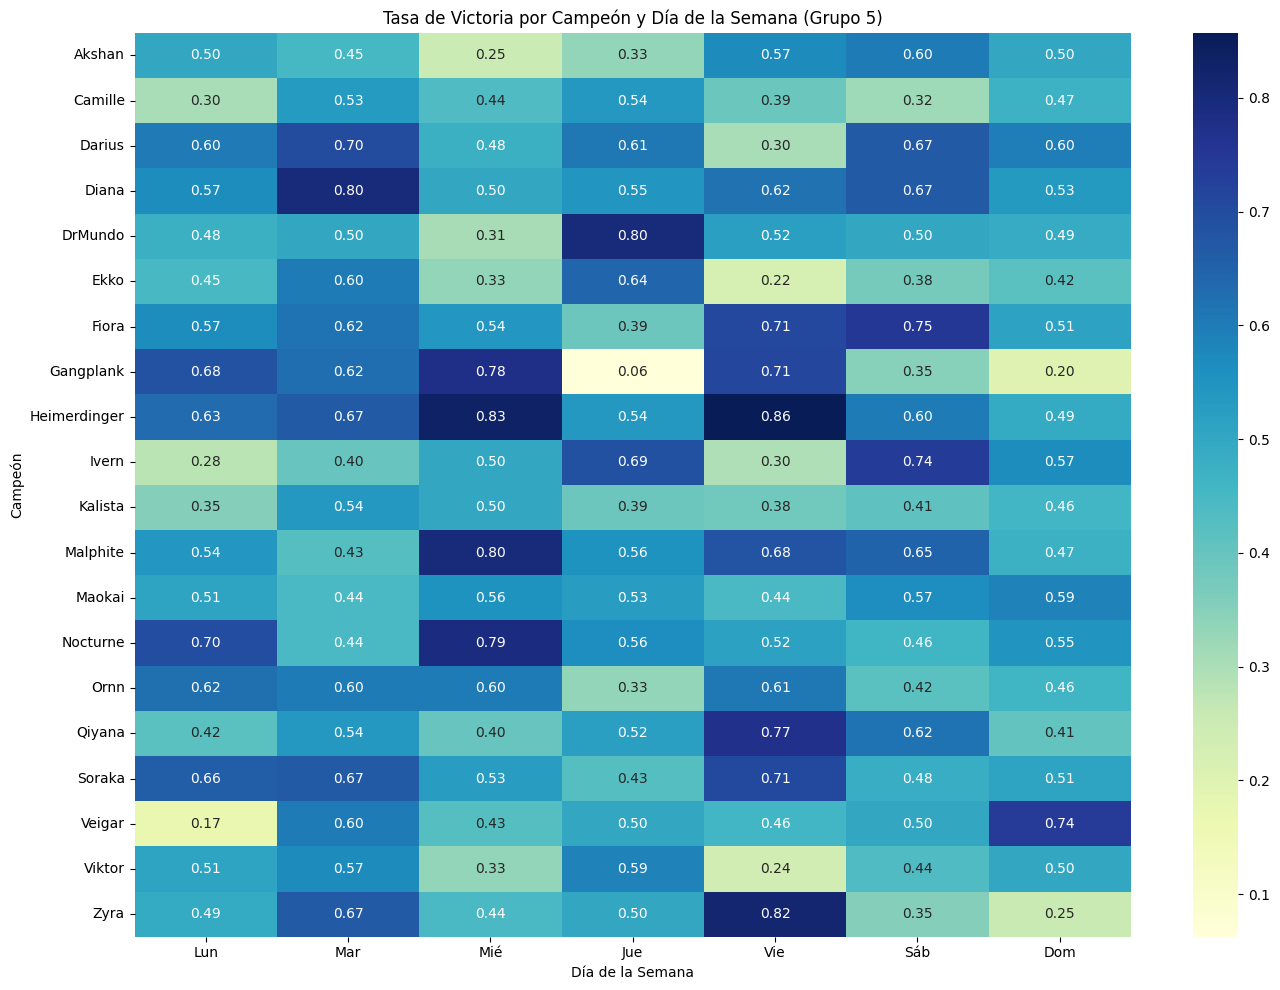

In [135]:
# Se crea una nueva columna para el día de la semana
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Se crea una nueva columna 'day_of_week' que obtenga el día de la semana
#df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_creation'].dt.dayofweek  # 0=lunes, 6=domingo

# Obtiene los campeones más jugados
top_champions = df_ultimo_parche['champion_name'].value_counts().head(100).index  # Ajusta el número si es necesario

# Calcula la tasa de victoria por campeón y día de la semana
# Filtrar solo los campeones más jugados
df_top_champions = df_ultimo_parche[df_ultimo_parche['champion_name'].isin(top_champions)]

# Cuenta el total de partidas y victorias por campeón y día de la semana
champion_day_stats_grouped = df_top_champions.groupby(['champion_name', 'day_of_week']).agg(
    total_games=('win', 'size'),
    wins=('win', 'sum')
).reset_index()

# Calcula la tasa de victoria
champion_day_stats_grouped['win_rate'] = champion_day_stats_grouped['wins'] / champion_day_stats_grouped['total_games']

# Divide los campeones en grupos y crear múltiples gráficos
champions_per_plot = 20  # Puedes ajustar este valor según tus preferencias

# subgráficos para los campeones más jugados
for i in range(0, len(top_champions), champions_per_plot):
    plt.figure(figsize=(14, 10))
    
    # Selecciona el grupo de campeones para este gráfico
    sub_group = top_champions[i:i + champions_per_plot]
    
    # Filtra los datos para el grupo de campeones actual
    temp_stats = champion_day_stats_grouped[champion_day_stats_grouped['champion_name'].isin(sub_group)]
    
    # tabla pivote para la tasa de victoria por campeón y día
    pivot_table = temp_stats.pivot(index='champion_name', columns='day_of_week', values='win_rate')
    
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, 
                xticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'],
                yticklabels=pivot_table.index)
    
    plt.title(f'Tasa de Victoria por Campeón y Día de la Semana (Grupo {i // champions_per_plot + 1})')
    plt.xlabel('Día de la Semana')
    plt.ylabel('Campeón')
    plt.tight_layout()
    plt.show()



## Regresión Lineal

### Matriz de correlacion

C:\Users\HP\AppData\Local\Temp\ipykernel_16136\3584773360.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_start_timestamp'] = pd.to_datetime(df_ultimo_parche['game_start_timestamp'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\3584773360.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_end_timestamp'] = pd.to_datetime(df_ultimo_parche['game_end_timestamp'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\3584773360.py:13: SettingW

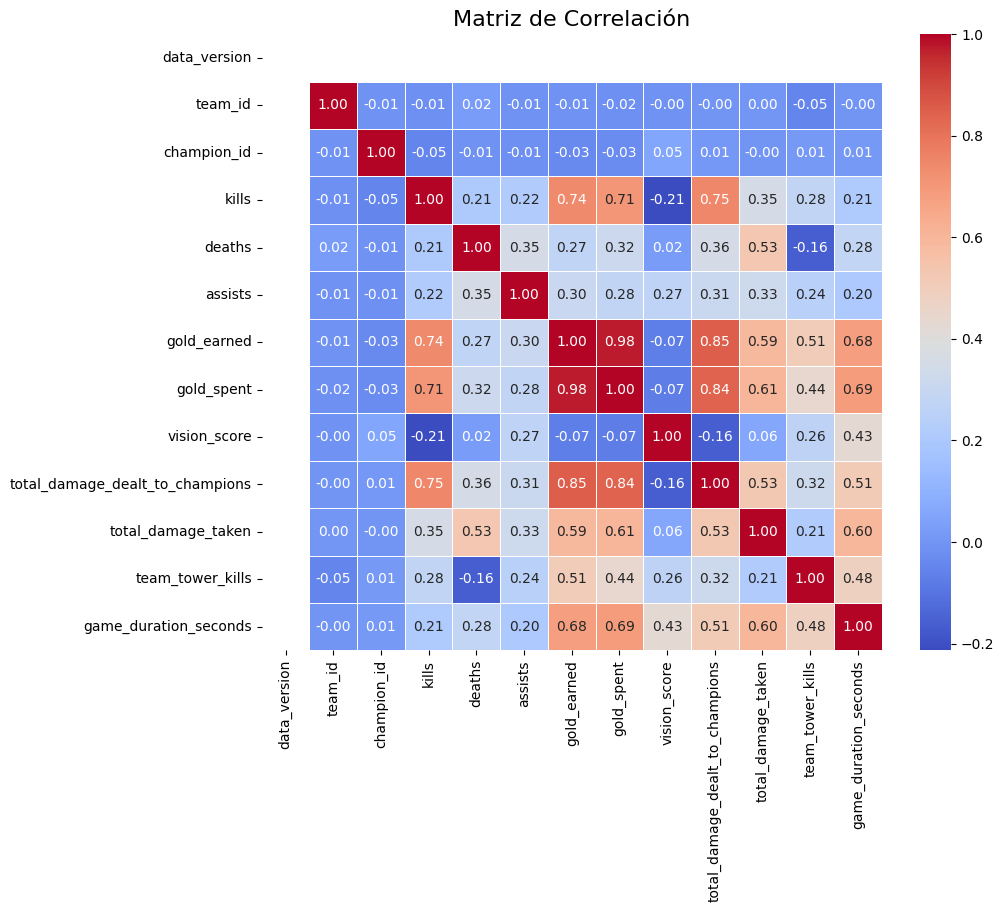

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_ultimo_parche['game_start_timestamp'] = pd.to_datetime(df_ultimo_parche['game_start_timestamp'], unit='ms')
df_ultimo_parche['game_end_timestamp'] = pd.to_datetime(df_ultimo_parche['game_end_timestamp'], unit='ms')

# Calcula la duración en segundos de la partida
df_ultimo_parche['game_duration_seconds'] = (df_ultimo_parche['game_end_timestamp'] - df_ultimo_parche['game_start_timestamp']).dt.total_seconds()

# modifica variable 'win' como un entero
df_ultimo_parche['win_encoded'] = df_ultimo_parche['win'].astype(int)

# elimino columnas no necesarias para el análisis
df_cleaned = df_ultimo_parche.drop(columns=['match_id', 'participants', 'summoner_name', 'champion_name', 'game_mode', 'game_version', 'lane', 'role', 'day_name', 'game_date', 'day', 'time_played', 'game_duration'])

# Selecciona solo columnas numéricas
df_numeric = df_cleaned.select_dtypes(include=['float64', 'int64'])

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.show()



Correlacion de variables:
gold_earned y kills: 0.742 => un mayor número de asesinatos está relacionado con más oro ganado.

gold_earned y total_damage_dealt_to_champions: 0.843 => indica que hay una relación fuerte entre el oro ganado y el daño infligido a los campeones.

kills y total_damage_dealt_to_champions: 0.751 => los jugadores que hacen más asesinatos tienden a infligir más daño a los campeones.

deaths y total_damage_taken => 0.531, lo que sugiere que los jugadores que mueren más suelen recibir más daño.

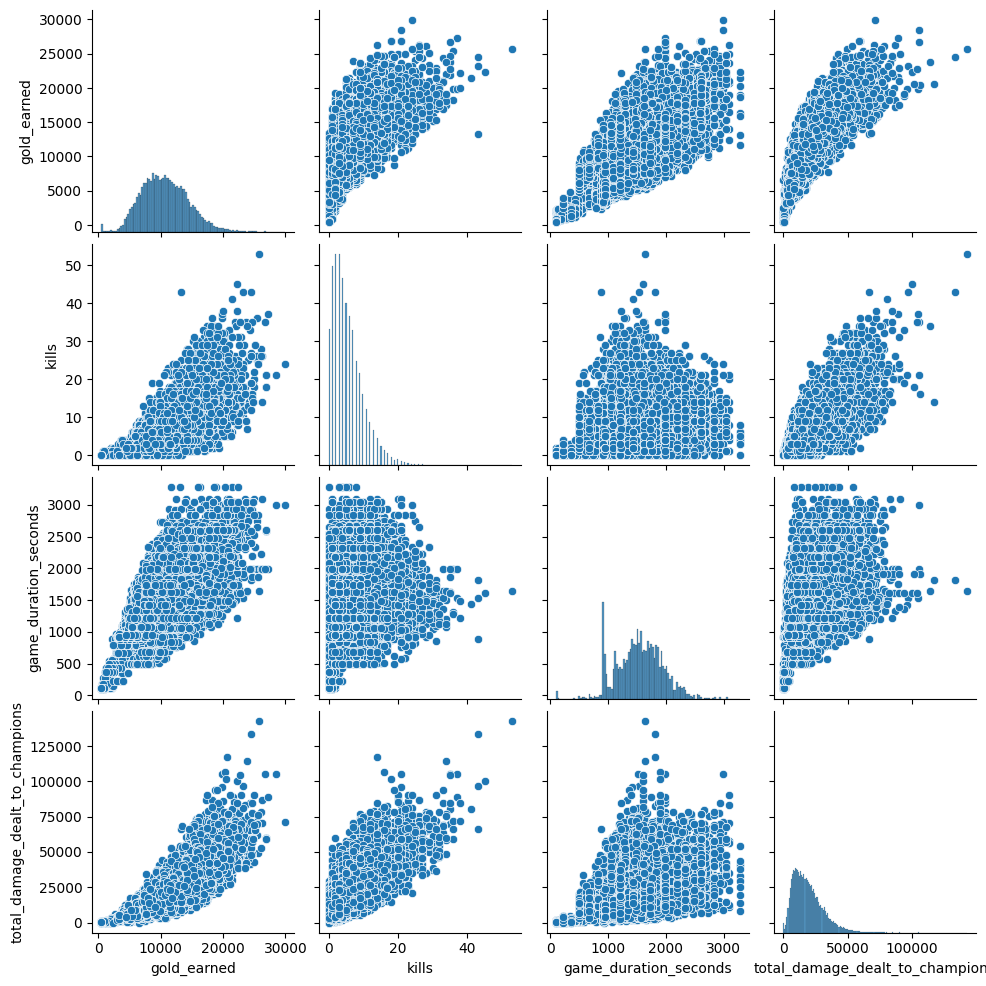

In [137]:
sns.pairplot(df_numeric[['gold_earned', 'kills', 'game_duration_seconds', 'total_damage_dealt_to_champions']])
plt.show()


#### Pruebas no relacionadas

In [83]:
# Se va predecir 'game_duration_seconds' (Y) en función de 'gold_earned' (X)
X = df_numeric[['gold_earned','kills','game_duration_seconds']]  # Variable independiente (predictora)
Y = df_numeric['total_damage_dealt_to_champions']  # Variable dependiente (objetivo)

# Divido los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crea el modelo de regresión lineal
model = LinearRegression()

# Se entrena el modelo
model.fit(X_train, Y_train)

# hace las predicciones
Y_pred = model.predict(X_test)

# Calcula el R² y el error cuadrático medio (MSE)
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print(f"R² (Coeficiente de Determinación): {r2:.4f}")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")

R² (Coeficiente de Determinación): 0.7524
Error Cuadrático Medio (MSE): 33108511.3870


In [84]:
print("Rango de Y_test:", Y_test.min(), "-", Y_test.max())
print("Media de Y_test:", Y_test.mean())

rmse = np.sqrt(mse)
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")

baseline_pred = Y_train.mean()  # Predice siempre el promedio
baseline_mse = mean_squared_error(Y_test, [baseline_pred] * len(Y_test))
print(f"MSE del modelo promedio: {baseline_mse:.4f}")

#ME DEMUESTRA QUE NO ES ALTAMENTE EFICIENTE. MUESTRA UN MARGEN DE ERROR DE 30% DE LA MEDIA DE Y_TEST


Rango de Y_test: 0 - 84310
Media de Y_test: 19178.84268758801
Raíz del Error Cuadrático Medio (RMSE): 5753.9996
MSE del modelo promedio: 133731585.6435


##### Comprobaremos si las relaciones en las variables es no lineal, por lo tanto hacemos una regresion polinomica

In [85]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)  # Cambia el grado según sea necesario
X_poly = poly.fit_transform(X)  # Genera términos polinómicos

X_train_poly, X_test_poly, Y_train, Y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train_poly, Y_train)

Y_pred_poly = model.predict(X_test_poly)

r2_poly = r2_score(Y_test, Y_pred_poly)
mse_poly = mean_squared_error(Y_test, Y_pred_poly)
print(f"R² (Regresión Polinómica): {r2_poly:.4f}")
print(f"MSE (Regresión Polinómica): {mse_poly:.4f}")


R² (Regresión Polinómica): 0.7594
MSE (Regresión Polinómica): 32169090.5305


### Análisis de regresión de número de partidas que van a jugar el resto de semanas del mes de Diciembre

In [138]:
df_ultimo_parche['game_date'] = pd.to_datetime(df_ultimo_parche['game_date'], errors='coerce')

#ayudara a capturar patrones de comportamiento semanal y mensual
df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_date'].dt.dayofweek
df_ultimo_parche['day_of_month'] = df_ultimo_parche['game_date'].dt.day


C:\Users\HP\AppData\Local\Temp\ipykernel_16136\529815408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_date'] = pd.to_datetime(df_ultimo_parche['game_date'], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\529815408.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_date'].dt.dayofweek
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\529815408.py:5: SettingWithCopyWarning: 
A value is trying to be set on a c

In [139]:
tabla_game_count = game_count_by_date.reset_index()

print("Número partidas jugadas por día:")
print(tabla_game_count)


Número partidas jugadas por día:
     game_date  match_id
0   2024-11-20        24
1   2024-11-21        32
2   2024-11-22        45
3   2024-11-23        21
4   2024-11-24        37
5   2024-11-25        45
6   2024-11-26        49
7   2024-11-27        59
8   2024-11-28        69
9   2024-11-29        73
10  2024-11-30        92
11  2024-12-01       106
12  2024-12-02       158
13  2024-12-03       181
14  2024-12-04       167
15  2024-12-05       184
16  2024-12-06       278
17  2024-12-07       340
18  2024-12-08       422
19  2024-12-09       426


C:\Users\HP\AppData\Local\Temp\ipykernel_16136\3835599330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_name'] = df_ultimo_parche['game_creation'].dt.day_name()
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\3835599330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_name'] = pd.Categorical(df_ultimo_parche['day_name'], categories=ordered_days, ordered=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\3835599330.py:13: FutureWarning: The default of ob

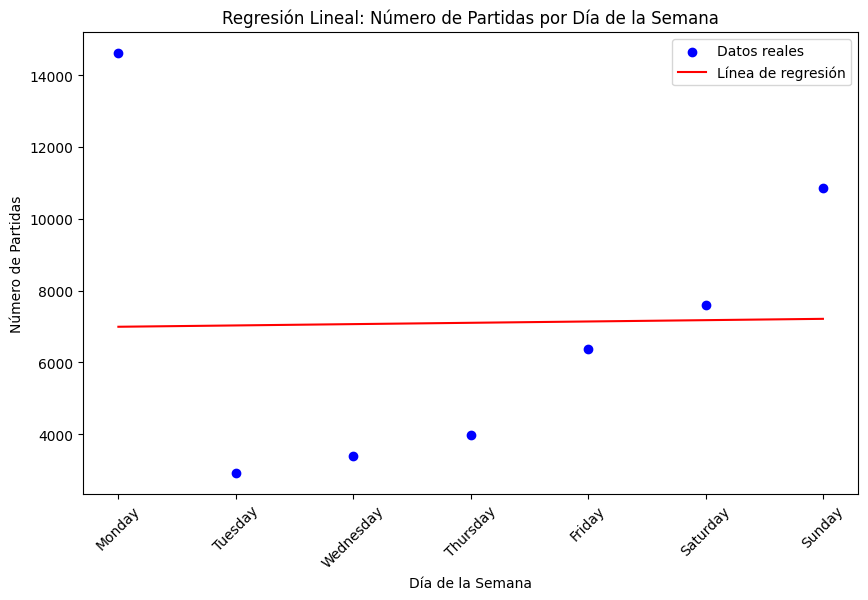

R² : 0.00


In [140]:
from sklearn.linear_model import LinearRegression
import numpy as np

#df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Creacion de la columna con el día de la semana (nombres)
df_ultimo_parche['day_name'] = df_ultimo_parche['game_creation'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_ultimo_parche['day_name'] = pd.Categorical(df_ultimo_parche['day_name'], categories=ordered_days, ordered=True)

# DataFrame con el número de partidas por día
game_count_by_day = df_ultimo_parche.groupby('day_name').size().reindex(ordered_days)

# se convierte los días de la semana a números (0: Lunes, ..., 6: Domingo)
X = np.arange(len(ordered_days)).reshape(-1, 1)  # Variable independiente: 0 a 6
y = game_count_by_day.values  # Variable dependiente: número de partidas

# Ajuste del modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predicciones
y_pred = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Datos reales')  # Puntos reales
plt.plot(X, y_pred, color='red', label='Línea de regresión')  # Línea de regresión
plt.xticks(ticks=range(7), labels=ordered_days, rotation=45)
plt.title('Regresión Lineal: Número de Partidas por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Partidas')
plt.legend()
plt.show()

r2_score = model.score(X, y)
print(f"R² : {r2_score:.2f}")


In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Errores de predicción en datos de entrenamiento
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"Error absoluto medio (MAE): {mae:.2f}")
print(f"Error cuadrático medio (MSE): {mse:.2f}")


Error absoluto medio (MAE): 3337.76
Error cuadrático medio (MSE): 16063028.06


MAE = 530.82, el modelo tiene un error de 530 partidas por día. Esto puede ser aceptable ya que el numero de partidas en los días de la semana escala desde 2000 hasta 14000, así que el error representa un bajo porcentaje del total.

MSE = 443595.41, sugiere que algunos errores pueden ser grandes (debido al cuadrado en su fórmula). Esto se confirma con un grafico de residuos para ver si hay patrones o outliers que el modelo no está capturando bien.

### Predicción para el resto del mes de Diciembre

In [ ]:
future_days = np.arange(3, 32).reshape(-1, 1)  # Días de la semana extendidos
future_predictions = model.predict(future_days)

print("Predicciones para la semana siguiente:")
for i, pred in enumerate(future_predictions):
    print(f"Día {i + 3}: {int(pred)} partidas")


### Predicción diaria del mes de Diciembre

In [143]:
df_ultimo_parche['date'] = df_ultimo_parche['game_creation'].dt.date

# Cuenta el número de partidas jugadas por cada día
game_count_by_date = df_ultimo_parche.groupby('date')['match_id'].nunique()

game_count_by_date

C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2127549409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['date'] = df_ultimo_parche['game_creation'].dt.date


date
2024-11-20     24
2024-11-21     32
2024-11-22     45
2024-11-23     21
2024-11-24     37
2024-11-25     45
2024-11-26     49
2024-11-27     59
2024-11-28     69
2024-11-29     73
2024-11-30     92
2024-12-01    106
2024-12-02    158
2024-12-03    181
2024-12-04    167
2024-12-05    184
2024-12-06    278
2024-12-07    340
2024-12-08    422
2024-12-09    426
Name: match_id, dtype: int64

C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2044263959.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2044263959.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['date'] = df_ultimo_parche['game_creation'].dt.date


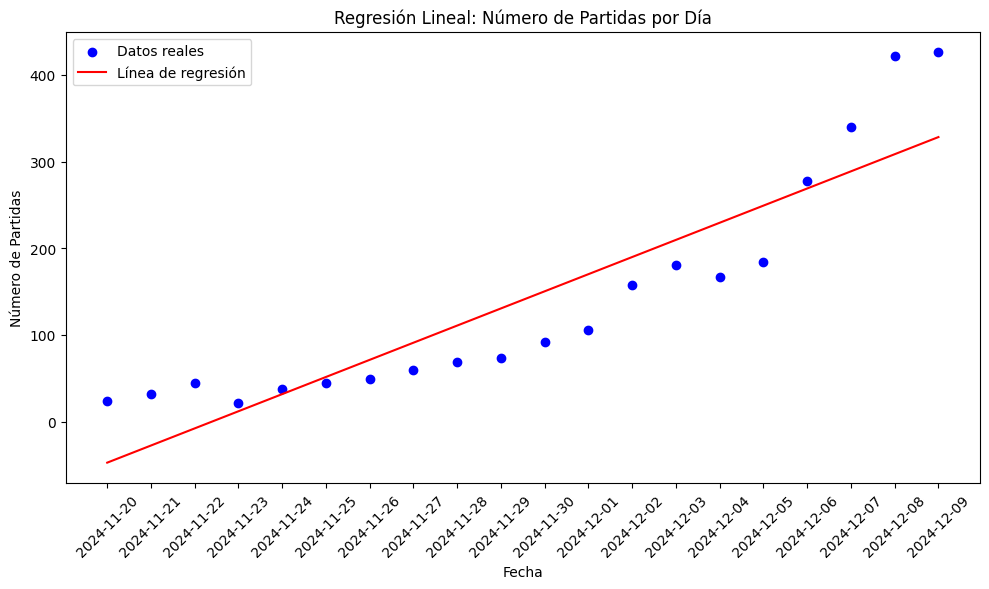

MAE: 47.02
MSE: 3040.43
R²: 0.81

Predicciones futuras:
Fecha: 2024-12-01, Predicción de partidas: 348
Fecha: 2024-12-02, Predicción de partidas: 368
Fecha: 2024-12-03, Predicción de partidas: 388
Fecha: 2024-12-04, Predicción de partidas: 407
Fecha: 2024-12-05, Predicción de partidas: 427
Fecha: 2024-12-06, Predicción de partidas: 447
Fecha: 2024-12-07, Predicción de partidas: 467
Fecha: 2024-12-08, Predicción de partidas: 486
Fecha: 2024-12-09, Predicción de partidas: 506


In [144]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Conversión de timestamps y creación de columnas
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')
df_ultimo_parche['date'] = df_ultimo_parche['game_creation'].dt.date

# Conteo de partidas por fecha
game_count_by_date = df_ultimo_parche.groupby('date')['match_id'].nunique()

# Preparar datos para regresión
X = np.arange(len(game_count_by_date)).reshape(-1, 1)  # Variable independiente
y = game_count_by_date.values  # Variable dependiente

# Ajustar modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predicciones sobre los datos actuales
y_pred = model.predict(X)

# Graficar datos reales y predicción
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Datos reales')  # Puntos reales
plt.plot(X, y_pred, color='red', label='Línea de regresión')  # Línea de regresión
plt.xticks(ticks=np.arange(len(game_count_by_date)), labels=game_count_by_date.index, rotation=45)
plt.title('Regresión Lineal: Número de Partidas por Día')
plt.xlabel('Fecha')
plt.ylabel('Número de Partidas')
plt.legend()
plt.tight_layout()
plt.show()

# Métricas del modelo
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
r2_score = model.score(X, y)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2_score:.2f}")

# Predicciones futuras desde el 1 de diciembre hasta el 9 de diciembre
start_prediction_date = datetime(2024, 12, 1)
end_prediction_date = datetime(2024, 12, 9)

# Última fecha en los datos df_ultimo_parche###
#last_date = game_count_by_date.index[-1]
#dates_to_predict = [last_date + timedelta(days=i) for i in range(1, 31 - last_date.day + 1)]
#X_future = np.arange(len(X), len(X) + len(dates_to_predict)).reshape(-1, 1)
###############################################

# Generar rango de fechas y preparar valores futuros para predicción
dates_to_predict = pd.date_range(start=start_prediction_date, end=end_prediction_date)
X_future = np.arange(len(X), len(X) + len(dates_to_predict)).reshape(-1, 1)

# Predicciones futuras
y_future_pred = model.predict(X_future)

# Mostrar predicciones futuras
print("\nPredicciones futuras:")
for date, pred in zip(dates_to_predict, y_future_pred):
    print(f"Fecha: {date.date()}, Predicción de partidas: {pred:.0f}")


### Otra alternativa de predicción lineal

#### Entrenamiento del modelo

In [145]:
df_ultimo_parche['game_date'] = pd.to_datetime(df_ultimo_parche['game_date'], errors='coerce')

#ayudara a capturar patrones de comportamiento semanal y mensual
df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_date'].dt.dayofweek
df_ultimo_parche['day_of_month'] = df_ultimo_parche['game_date'].dt.day


C:\Users\HP\AppData\Local\Temp\ipykernel_16136\529815408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_date'] = pd.to_datetime(df_ultimo_parche['game_date'], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\529815408.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_date'].dt.dayofweek
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\529815408.py:5: SettingWithCopyWarning: 
A value is trying to be set on a c

In [146]:
train = df_ultimo_parche[df_ultimo_parche['game_date'] < '2024-12-01']
test = df_ultimo_parche[df_ultimo_parche['game_date'] >= '2024-12-01']


In [147]:
# Agrupar por fecha (sin considerar la hora) y contar el número de partidas por día
df_ultimo_parche['game_date'] = df_ultimo_parche['game_creation'].dt.date  # Obtener solo la fecha sin hora
partidas_por_dia = df_ultimo_parche.groupby('game_date')['match_id'].nunique().reset_index()

# Renombrar las columnas para mayor claridad
partidas_por_dia.columns = ['game_date', 'match_count']

# Mostrar el resultado
print(partidas_por_dia)


     game_date  match_count
0   2024-11-20           24
1   2024-11-21           32
2   2024-11-22           45
3   2024-11-23           21
4   2024-11-24           37
5   2024-11-25           45
6   2024-11-26           49
7   2024-11-27           59
8   2024-11-28           69
9   2024-11-29           73
10  2024-11-30           92
11  2024-12-01          106
12  2024-12-02          158
13  2024-12-03          181
14  2024-12-04          167
15  2024-12-05          184
16  2024-12-06          278
17  2024-12-07          340
18  2024-12-08          422
19  2024-12-09          426


C:\Users\HP\AppData\Local\Temp\ipykernel_16136\3740689339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_date'] = df_ultimo_parche['game_creation'].dt.date  # Obtener solo la fecha sin hora


In [149]:
partidas_por_dia

game_date  match_count
0   2024-11-20           24
1   2024-11-21           32
2   2024-11-22           45
3   2024-11-23           21
4   2024-11-24           37
5   2024-11-25           45
6   2024-11-26           49
7   2024-11-27           59
8   2024-11-28           69
9   2024-11-29           73
10  2024-11-30           92
11  2024-12-01          106
12  2024-12-02          158
13  2024-12-03          181
14  2024-12-04          167
15  2024-12-05          184
16  2024-12-06          278
17  2024-12-07          340
18  2024-12-08          422
19  2024-12-09          426

In [150]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# se la columna 'game_date' a datetime si no lo hemos hecho ya
df_ultimo_parche['game_date'] = pd.to_datetime(df_ultimo_parche['game_date'])

# Crea columnas 'day_of_week' y 'day_of_month'
df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_date'].dt.dayofweek  # 0 = lunes, 6 = domingo
df_ultimo_parche['day_of_month'] = df_ultimo_parche['game_date'].dt.day  # Día del mes

# Agrupa los datos por fecha para obtener el número de partidas por día
partidas_por_dia = df_ultimo_parche.groupby('game_date')['match_id'].nunique().reset_index()

# Renombra la columna de partidas para mayor claridad
partidas_por_dia.columns = ['game_date', 'daily_game_counter']

# Crea el conjunto de entrenamiento y prueba
# las fechas antes del 1 de diciembre estan en el conjunto de entrenamiento
train = partidas_por_dia[partidas_por_dia['game_date'] < '2024-12-01']
test = partidas_por_dia[partidas_por_dia['game_date'] >= '2024-12-01']

# Añade las columnas de 'day_of_week' y 'day_of_month' a los datos de entrenamiento y prueba
train['day_of_week'] = train['game_date'].dt.dayofweek
train['day_of_month'] = train['game_date'].dt.day

test['day_of_week'] = test['game_date'].dt.dayofweek
test['day_of_month'] = test['game_date'].dt.day

# Variables predictoras (X) y variable dependiente (y)
X_train = train[['day_of_week', 'day_of_month']]  # Variables predictoras
#X_train = train[['day_of_month']]  # Variables predictoras
y_train = train['daily_game_counter']  # Número de partidas jugadas cada día

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# se realiza las predicciones en el conjunto de prueba (para diciembre)
X_test = test[['day_of_week', 'day_of_month']]  # Variables predictoras para diciembre
#X_test = test[['day_of_month']]  # Variables predictoras para diciembre
y_test = test['daily_game_counter']  # Número de partidas reales en diciembre

y_pred = model.predict(X_test)

# rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')

# las predicciones para diciembre
predictions = test[['game_date', 'daily_game_counter']].copy()
predictions['predicted_daily_game_counter'] = y_pred
print(predictions)


MSE: 113440.1424
R²: -7.9063
    game_date  daily_game_counter  predicted_daily_game_counter
11 2024-12-01                 106                    -94.119481
12 2024-12-02                 158                    -89.810390
13 2024-12-03                 181                    -83.501299
14 2024-12-04                 167                    -77.192208
15 2024-12-05                 184                    -70.883117
16 2024-12-06                 278                    -64.574026
17 2024-12-07                 340                    -58.264935
18 2024-12-08                 422                    -51.955844
19 2024-12-09                 426                    -47.646753


C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2270206385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_date'] = pd.to_datetime(df_ultimo_parche['game_date'])
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2270206385.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_date'].dt.dayofweek  # 0 = lunes, 6 = domingo
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2270206385.py:9: SettingWithCopyWarning: 
A value is trying to b

#### Prediccion para diciembre

In [151]:
import pandas as pd
import numpy as np

# Crea un DataFrame con las fechas de diciembre
diciembre_fechas = pd.date_range(start="2024-12-01", end="2024-12-31", freq='D')

# Extrae el día de la semana y el día del mes de cada fecha
diciembre_df = pd.DataFrame({
    'game_date': diciembre_fechas,
    'day_of_week': diciembre_fechas.dayofweek,  # 0 = Monday, 6 = Sunday
    'day_of_month': diciembre_fechas.day
})

# Predicciones para diciembre
X_diciembre = diciembre_df[['day_of_week', 'day_of_month']]
#X_diciembre = diciembre_df[['day_of_month']]
predicciones_diciembre = model.predict(X_diciembre)

# se agrega las predicciones al DataFrame
diciembre_df['predicted_daily_game_counter'] = predicciones_diciembre

print(diciembre_df[['game_date', 'predicted_daily_game_counter']])


    game_date  predicted_daily_game_counter
0  2024-12-01                    -94.119481
1  2024-12-02                    -89.810390
2  2024-12-03                    -83.501299
3  2024-12-04                    -77.192208
4  2024-12-05                    -70.883117
5  2024-12-06                    -64.574026
6  2024-12-07                    -58.264935
7  2024-12-08                    -51.955844
8  2024-12-09                    -47.646753
9  2024-12-10                    -41.337662
10 2024-12-11                    -35.028571
11 2024-12-12                    -28.719481
12 2024-12-13                    -22.410390
13 2024-12-14                    -16.101299
14 2024-12-15                     -9.792208
15 2024-12-16                     -5.483117
16 2024-12-17                      0.825974
17 2024-12-18                      7.135065
18 2024-12-19                     13.444156
19 2024-12-20                     19.753247
20 2024-12-21                     26.062338
21 2024-12-22                   

# Predictor

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

partidas_por_dia['game_date'] = pd.to_datetime(partidas_por_dia['game_date'])

# la creacion de nuevas características
partidas_por_dia['day_of_week'] = partidas_por_dia['game_date'].dt.dayofweek
partidas_por_dia['day_of_month'] = partidas_por_dia['game_date'].dt.day
partidas_por_dia['cumulative_games'] = partidas_por_dia['daily_game_counter'].cumsum()
partidas_por_dia['is_weekend'] = partidas_por_dia['game_date'].dt.dayofweek >= 5
partidas_por_dia['days_since_start'] = (partidas_por_dia['game_date'] - partidas_por_dia['game_date'].min()).dt.days

# divido el conjunto de entrenamiento y prueba
train = partidas_por_dia[partidas_por_dia['game_date'] < '2024-12-01']
test = partidas_por_dia[partidas_por_dia['game_date'] >= '2024-12-01']

# variables independientes y dependientes
X_train = train[['day_of_week', 'day_of_month', 'is_weekend', 'days_since_start', 'cumulative_games']]
y_train = train['daily_game_counter']

X_test = test[['day_of_week', 'day_of_month', 'is_weekend', 'days_since_start', 'cumulative_games']]
y_test = test['daily_game_counter']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrena el modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predicciones
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')

predictions = test[['game_date', 'daily_game_counter']].copy()
predictions['predicted_daily_game_counter'] = y_pred
print(predictions)


MSE: 10054.3149
R²: 0.2106
    game_date  daily_game_counter  predicted_daily_game_counter
11 2024-12-01                 106                    173.924200
12 2024-12-02                 158                    207.220396
13 2024-12-03                 181                    241.954650
14 2024-12-04                 167                    273.713917
15 2024-12-05                 184                    309.085668
16 2024-12-06                 278                    364.432331
17 2024-12-07                 340                    424.142308
18 2024-12-08                 422                    510.088837
19 2024-12-09                 426                    600.334783


In [153]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R² promedio en validación cruzada: {scores.mean():.4f}")


R² promedio en validación cruzada: -16.7654


### ------------------------------------------------------------------------------------------------------

### KDA + asistencias / muertes

In [7]:
# Ejemplo de análisis de KDA
df_ultimo_parche['kda'] = (df_ultimo_parche['kills'] + df_ultimo_parche['assists']) / df_ultimo_parche['deaths']
#df_ultimo_parche['kda'] = df_ultimo_parche['kda'].replace([float('inf'), float('-inf')], 'perfecto')
#df_kda_champs = df_ultimo_parche.groupby('champion_name')['kda'].mean().sort_values(ascending=False)

#df_ultimo_parche.head(60)

# Manejar valores infinitos (por muertes = 0)
df_ultimo_parche['kda'] = df_ultimo_parche['kda'].replace([float('inf'), float('-inf')], float('nan'))

In [8]:
# Filtrar filas sin nombre de invocador o con valores nulos en KDA
df_valid_kda = df_ultimo_parche.dropna(subset=['summoner_name', 'kda'])

# Opcional: Filtrar jugadores con al menos 10 partidas jugadas
player_counts = df_valid_kda['summoner_name'].value_counts()
valid_players = player_counts[player_counts >= 10].index
df_valid_kda = df_valid_kda[df_valid_kda['summoner_name'].isin(valid_players)]

# Calcular KDA promedio por jugador
top_players_kda = df_valid_kda.groupby('summoner_name')['kda'].mean().sort_values(ascending=False)



In [9]:
# Obtener el top 10
top_10_kda = top_players_kda.head(10)

# Mostrar el resultado
top_10_kda


summoner_name
itsalreadyjggap    15.232071
Ruck Fıto          10.958929
Stealyourcreeps    10.117424
Fleshyy             9.072057
SK Nenrislol        8.929323
Remy Albers         8.785000
al Asad             8.625000
Bardie3             8.486310
eltuko              8.446310
zoed                8.382653
Name: kda, dtype: float64

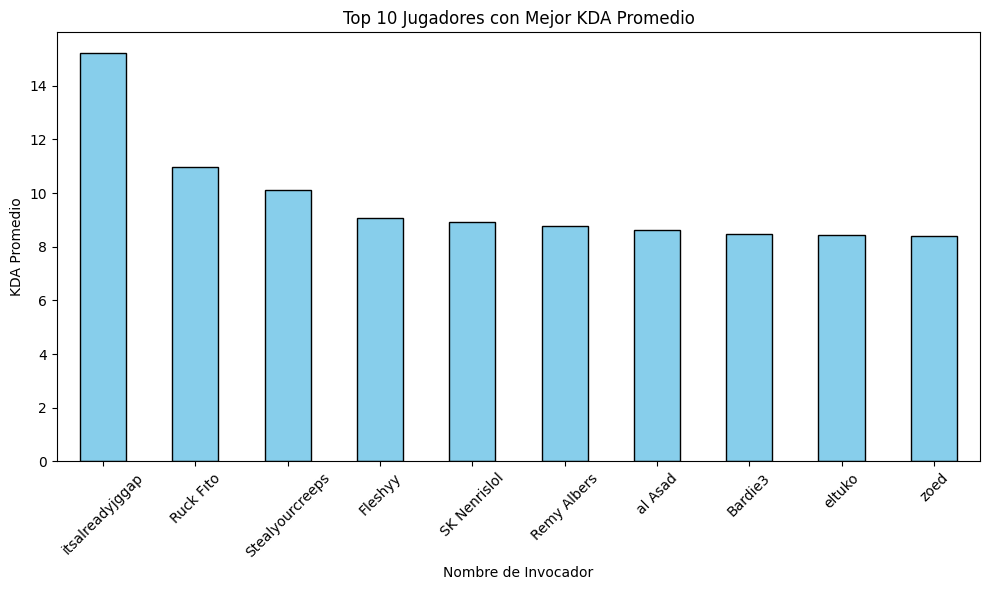

In [10]:
# Crear un gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_10_kda.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Jugadores con Mejor KDA Promedio')
plt.xlabel('Nombre de Invocador')
plt.ylabel('KDA Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Obtener el top 10
top_10_kda = top_players_kda.head(10).reset_index()

# Mostrar el resultado
top_10_kda

summoner_name        kda
0  itsalreadyjggap  15.232071
1        Ruck Fıto  10.958929
2  Stealyourcreeps  10.117424
3          Fleshyy   9.072057
4     SK Nenrislol   8.929323
5      Remy Albers   8.785000
6          al Asad   8.625000
7          Bardie3   8.486310
8           eltuko   8.446310
9             zoed   8.382653

##### Pasos
- Primero el dataset de top_kda debo buscar por nombre del usuario y obtener sus regristros y ponerlo en un dataset nuevo
- Luego debo obtener cuántas horas le han dedicado cada jugador a las partidas
- Hacer la regresion polinomica , para hacer predicciones de si en diciembre van a mantener el numero de horas igual, superior o menor.

In [12]:
# filtracion de los datos de df_ultimo_parche usando el top 10 de jugadores kda
player_data_top = df_ultimo_parche[df_ultimo_parche['summoner_name'].isin(top_10_kda['summoner_name'])]
player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'], unit='ms')

# Mostrar el resultado filtrado
player_data_top.head(8)


C:\Users\HP\AppData\Local\Temp\ipykernel_9036\1090575120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'], unit='ms')


match_id  data_version  \
573   EUW1_7218556505             2   
1969  EUW1_7222413267             2   
2343  EUW1_7218974320             2   
2359  EUW1_7222474023             2   
3221  EUW1_7219889830             2   
3536  EUW1_7203969313             2   
5014  EUW1_7197771956             2   
5614  EUW1_7221938098             2   

                                           participants  \
573   ['GKipOcl3O7U4mALHDeCrLn9u8PRZLmaciwjKUo5_gMtK...   
1969  ['j5qdu1YD-dwi0Cpbkq-sHOfIr2fjvSClMlx7_hLQxC_V...   
2343  ['LdYO6Gtw8oAdh5N9brxQtIF_Vhsqy1XbSw0_vJv82pw6...   
2359  ['_c-fAK2amEHol8eCdCqHz2CaKyVG8-x6_xyp_aWrTxLI...   
3221  ['r7ivDzcti2wF-8vDAWkQYWQQOdy9C6UFBpHauRZE6UuY...   
3536  ['m3aWDxHo18QoWU-7wn6tOjUb10MWgD8xVIurtTDEY6Qm...   
5014  ['LiaWn_06b_Xj5KkhZwZSqvubPS5kZNDu7lLLdjAbi0O4...   
5614  ['CegH4t2SForgOC3yONLPcQFCagOdeDL2Zzd9mouV4s9V...   

               game_creation  game_duration  game_end_timestamp  \
573  2024-12-07 16:27:32.256            924       1733589799139   
1969 2024-12-10 16:25:44.577           2077       1733850043694   
2343 2024-12-07 21:16:07.359           1578       1733607760310   
2359 2024-12-10 17:13:52.913           2129       1733853021742   
3221 2024-12-08 15:36:10.752           1105       1733673319574   
3536 2024-11-27 13:09:47.152           1706       1732714721489   
5014 2024-11-23 13:40:55.397           1700       1732370969917   
5614 2024-12-10 00:42:20.938           1436       1733792798367   

      game_start_timestamp game_mode    game_version  team_id  ...  \
573          1733588874751   CLASSIC  14.23.636.9832      100  ...   
1969         1733847966766   CLASSIC  14.23.636.9832      200  ...   
2343         1733606182275   CLASSIC  14.23.636.9832      100  ...   
2359         1733850892535   CLASSIC  14.23.636.9832      200  ...   
3221         1733672214016   CLASSIC  14.23.636.9832      100  ...   
3536         1732713015186   CLASSIC  14.23.636.9832      200  ...   
5014         1732369270014   CLASSIC  14.23.636.9832      100  ...   
5614         1733791362011   CLASSIC  14.23.636.9832      100  ...   

     time_played team_position  team_win  team_first_blood  team_first_tower  \
573          924        MIDDLE      True             False             False   
1969        2077       UTILITY      True             False             False   
2343        1578        BOTTOM      True             False             False   
2359        2129       UTILITY      True             False             False   
3221        1105        JUNGLE      True             False             False   
3536        1706        JUNGLE      True             False             False   
5014        1700       UTILITY      True             False             False   
5614        1436       UTILITY      True             False             False   

      first_baron  first_dragon  first_inhibitor team_tower_kills        kda  
573         False         False            False                4   8.000000  
1969         True          True             True                7   8.666667  
2343         True         False             True               10  24.000000  
2359         True          True             True                9   9.000000  
3221        False         False            False                4   3.750000  
3536         True          True             True                9  11.666667  
5014         True          True             True                8  21.000000  
5614        False         False            False                5  23.000000  

[8 rows x 33 columns]

In [13]:
player_data_top.columns

Index(['match_id', 'data_version', 'participants', 'game_creation',
       'game_duration', 'game_end_timestamp', 'game_start_timestamp',
       'game_mode', 'game_version', 'team_id', 'summoner_name',
       'champion_name', 'champion_id', 'kills', 'deaths', 'assists',
       'gold_earned', 'win', 'lane', 'role', 'vision_score',
       'total_damage_dealt_to_champions', 'total_damage_taken', 'time_played',
       'team_position', 'team_win', 'team_first_blood', 'team_first_tower',
       'first_baron', 'first_dragon', 'first_inhibitor', 'team_tower_kills',
       'kda'],
      dtype='object')

In [14]:
player_data_top['summoner_name'].unique()

array(['SK Nenrislol', 'Bardie3', 'Fleshyy', 'eltuko', 'al Asad',
       'Ruck Fıto', 'Stealyourcreeps', 'zoed', 'itsalreadyjggap',
       'Remy Albers'], dtype=object)

In [15]:
# se elimina los duplicados basados en match_id y summoner_name
#player_data_top_info = player_data_top.drop_duplicates(subset=['match_id', 'summoner_name'])

# Agrupar por summoner_name y sumar el tiempo jugado
player_time_played = (
    player_data_top
    .groupby('summoner_name')['time_played']
    .sum()
    .reset_index()
)

# se convierte a minutos
player_time_played['time_played_minuts'] = player_time_played['time_played'] / 60

#player_time_played.drop('time_played', axis=1, inplace=True)


#lo paso a serie para hacer el grafico
time_played_series = player_time_played.set_index('summoner_name')['time_played_minuts']

time_played_series #obtengo los minutos totales que ha jugado cada jugador de todas sus partidas.


summoner_name
Bardie3            1042.700000
Fleshyy            1030.616667
Remy Albers         312.700000
Ruck Fıto           346.833333
SK Nenrislol        433.566667
Stealyourcreeps     265.083333
al Asad             315.866667
eltuko              450.133333
itsalreadyjggap     395.216667
zoed                389.166667
Name: time_played_minuts, dtype: float64

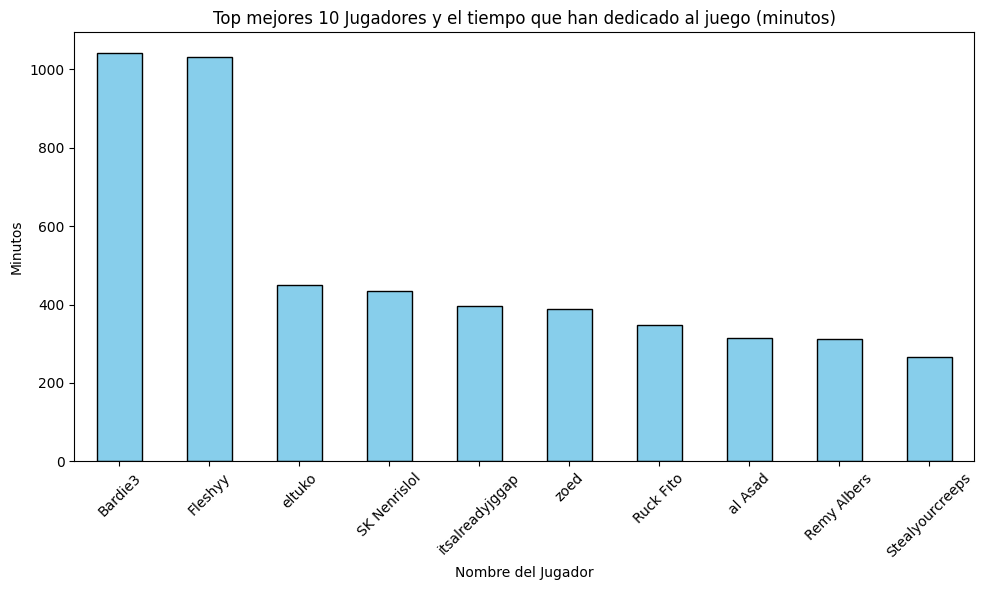

In [16]:
time_played_series = time_played_series.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
time_played_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top mejores 10 Jugadores y el tiempo que han dedicado al juego (minutos)')
plt.xlabel('Nombre del Jugador')
plt.ylabel('Minutos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
#el dataframe player_data_top tengo todas las columnas de df_ultimo_parche, pero está filtrado por los jugadores top 10 de kda.
player_data_top = player_data_top.copy()
player_data_top['time_played_minuts'] = player_data_top['time_played'] / 60

player_data_top.head(6).to_csv("borrar2.csv")

In [18]:
#Obtengo el numero de partidas totales por día

# Convertir la columna 'game_creation' a formato datetime
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Crear una columna con la fecha (sin hora) para agrupar los datos por día
df_ultimo_parche['game_date'] = df_ultimo_parche['game_creation'].dt.date

# Contador de número de partidas únicas por cada día
game_count_by_date = df_ultimo_parche.groupby('game_date')['match_id'].nunique()

game_count_by_date

game_date
2024-11-20     86
2024-11-21    121
2024-11-22    100
2024-11-23    117
2024-11-24    146
2024-11-25    156
2024-11-26    210
2024-11-27    267
2024-11-28    308
2024-11-29    399
2024-11-30    472
2024-12-01    452
2024-12-02    214
2024-12-03    181
2024-12-04    167
2024-12-05    184
2024-12-06    278
2024-12-07    340
2024-12-08    422
2024-12-09    426
2024-12-10    333
Name: match_id, dtype: int64

In [111]:
player_data_top

match_id  data_version  \
573     EUW1_7218556505             2   
1969    EUW1_7222413267             2   
2343    EUW1_7218974320             2   
2359    EUW1_7222474023             2   
3221    EUW1_7219889830             2   
...                 ...           ...   
110903  EUW1_7208785296             2   
111836  EUW1_7209930267             2   
111841  EUW1_7209882382             2   
112472  EUW1_7209714645             2   
113439  EUW1_7211224912             2   

                                             participants  \
573     ['GKipOcl3O7U4mALHDeCrLn9u8PRZLmaciwjKUo5_gMtK...   
1969    ['j5qdu1YD-dwi0Cpbkq-sHOfIr2fjvSClMlx7_hLQxC_V...   
2343    ['LdYO6Gtw8oAdh5N9brxQtIF_Vhsqy1XbSw0_vJv82pw6...   
2359    ['_c-fAK2amEHol8eCdCqHz2CaKyVG8-x6_xyp_aWrTxLI...   
3221    ['r7ivDzcti2wF-8vDAWkQYWQQOdy9C6UFBpHauRZE6UuY...   
...                                                   ...   
110903  ['JjVqCckqt9IceqraOtpUYlLVP1NeffcAAmcCsuYk8MRd...   
111836  ['_AeHhfM78rzjxs-Ym3xXO8glQe6S-cLQGlmVZV03AZlK...   
111841  ['aKGO3bBxBOL17jVls0FhzNpPXTD7hlTnY12ccK1E8mVk...   
112472  ['FPnIPAZbbSRffXRF43umhWBkajmklwFbZ4rhuJ9-WF0O...   
113439  ['AI7l9VVcJQe0Z7TXBu9wGbHknnL_AjHtJGAN0PKzDAWE...   

                 game_creation  game_duration  game_end_timestamp  \
573    2024-12-07 16:27:32.256            924       1733589799139   
1969   2024-12-10 16:25:44.577           2077       1733850043694   
2343   2024-12-07 21:16:07.359           1578       1733607760310   
2359   2024-12-10 17:13:52.913           2129       1733853021742   
3221   2024-12-08 15:36:10.752           1105       1733673319574   
...                        ...            ...                 ...   
110903 2024-11-30 17:11:21.010           1802       1732988498150   
111836 2024-12-01 12:13:13.864           1500       1733056725561   
111841 2024-12-01 11:35:10.853           1836       1733054775801   
112472 2024-12-01 07:14:09.807           1096       1733038371567   
113439 2024-12-02 00:53:50.890           1695       1733102553849   

        game_start_timestamp game_mode    game_version  team_id  ...  \
573            1733588874751   CLASSIC  14.23.636.9832      100  ...   
1969           1733847966766   CLASSIC  14.23.636.9832      200  ...   
2343           1733606182275   CLASSIC  14.23.636.9832      100  ...   
2359           1733850892535   CLASSIC  14.23.636.9832      200  ...   
3221           1733672214016   CLASSIC  14.23.636.9832      100  ...   
...                      ...       ...             ...      ...  ...   
110903         1732986695695   CLASSIC  14.23.636.9832      100  ...   
111836         1733055225055   CLASSIC  14.23.636.9832      200  ...   
111841         1733052939321   CLASSIC  14.23.636.9832      100  ...   
112472         1733037275428   CLASSIC  14.23.636.9832      100  ...   
113439         1733100858483   CLASSIC  14.23.636.9832      200  ...   

       team_first_blood team_first_tower  first_baron  first_dragon  \
573               False            False        False         False   
1969              False            False         True          True   
2343              False            False         True         False   
2359              False            False         True          True   
3221              False            False        False         False   
...                 ...              ...          ...           ...   
110903            False            False         True         False   
111836            False            False         True          True   
111841            False            False        False         False   
112472            False            False        False          True   
113439            False            False         True          True   

        first_inhibitor  team_tower_kills        kda   game_date day_of_week  \
573               False                 4   8.000000  2024-12-07           5   
1969               True                 7   8.666667  2024-12-10           1   
23

In [112]:
import pandas as pd
player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'], unit='ms')

fecha_minima = player_data_top['game_creation'].min()
fecha_maxima = player_data_top['game_creation'].max()

# Filtra el DataFrame entre las fechas
print(fecha_minima,"  ",fecha_maxima)

2024-11-20 22:21:37.620000    2024-12-10 19:25:36.460000


In [ ]:
player_data_top[['game_creation', 'days_since_start']].head().to_csv("borrar3")


In [19]:
player_data_top.columns

Index(['match_id', 'data_version', 'participants', 'game_creation',
       'game_duration', 'game_end_timestamp', 'game_start_timestamp',
       'game_mode', 'game_version', 'team_id', 'summoner_name',
       'champion_name', 'champion_id', 'kills', 'deaths', 'assists',
       'gold_earned', 'win', 'lane', 'role', 'vision_score',
       'total_damage_dealt_to_champions', 'total_damage_taken', 'time_played',
       'team_position', 'team_win', 'team_first_blood', 'team_first_tower',
       'first_baron', 'first_dragon', 'first_inhibitor', 'team_tower_kills',
       'kda', 'time_played_minuts'],
      dtype='object')

<Axes: xlabel='day_of_week', ylabel='time_played_minuts'>

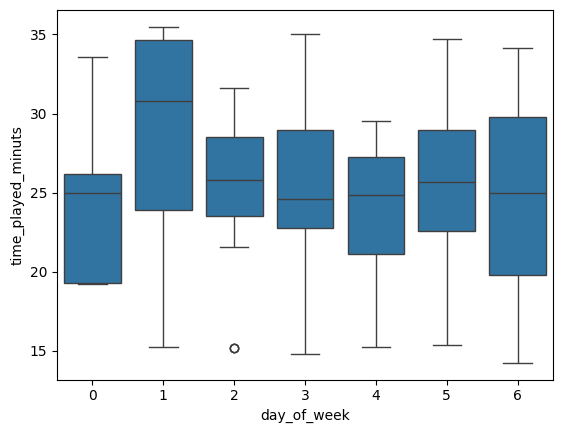

In [20]:
# Extraer el día de la semana de la columna 'game_creation'
player_data_top['day_of_week'] = player_data_top['game_creation'].dt.dayofweek

# Crear un gráfico para analizar si existe una relación
import seaborn as sns
sns.boxplot(x='day_of_week', y='time_played_minuts', data=player_data_top)


In [21]:
# Crear un nuevo dataframe con el número total de partidas por jugador
players_top_game_counter = player_data_top.groupby('summoner_name')['match_id'].nunique().reset_index()

# Renombrar la columna
players_top_game_counter.rename(columns={'match_id': 'game_counter_total'}, inplace=True)

# Verificar el dataframe
print(players_top_game_counter)

     summoner_name  game_counter_total
0          Bardie3                  17
1          Fleshyy                  11
2      Remy Albers                   7
3        Ruck Fıto                   9
4     SK Nenrislol                  11
5  Stealyourcreeps                   9
6          al Asad                   4
7           eltuko                  11
8  itsalreadyjggap                   7
9             zoed                  14


In [22]:
#Promedio de tiempo de juego dedicado por cada jugador.

avg_time_per_game = player_data_top.groupby('summoner_name')['time_played_minuts'].mean().reset_index()


avg_time_per_game.rename(columns={'time_played_minuts': 'avg_time_per_game'}, inplace=True)
print(avg_time_per_game)


     summoner_name  avg_time_per_game
0          Bardie3          28.963889
1          Fleshyy          28.628241
2      Remy Albers          28.427273
3        Ruck Fıto          24.773810
4     SK Nenrislol          22.819298
5  Stealyourcreeps          24.098485
6          al Asad          26.322222
7           eltuko          22.506667
8  itsalreadyjggap          26.347778
9             zoed          21.620370


In [24]:
# Calcular la media del tiempo jugado por partida
mean_play_time = player_data_top['time_played_minuts'].mean()

# Añadir la columna indicando si es un juego largo o corto, es el promedio total(partida en minutos) de los challengers
player_data_top['long_game'] = player_data_top['time_played_minuts'] > mean_play_time
# Convertir la columna booleana a numérica (1 para True, 0 para False)
player_data_top['long_game'] = player_data_top['long_game'].astype(int)


In [209]:
player_data_top.to_csv("borrar2.csv")

#### Regresion Polinomica: Me da error (Intento 1)

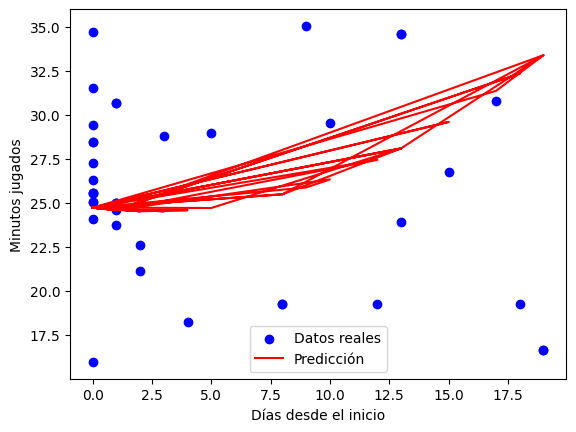

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'])

# Calcula los días desde la primera partida para cada jugador
player_data_top['days_since_start'] = player_data_top.groupby('summoner_name')['game_creation'].transform(lambda x: (x - x.min()).dt.days)

# Seleccionar las variables
X = player_data_top[['days_since_start']]  # Días desde el inicio
y = player_data_top['time_played_minuts']  # Minutos jugados

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo polinómico
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Predecir
X_poly_test = poly.transform(X_test)
y_pred = model.predict(X_poly_test)

# Visualizar los resultados
plt.scatter(X_test, y_test, color='blue', label='Datos reales')
plt.plot(X_test, y_pred, color='red', label='Predicción')
plt.xlabel('Días desde el inicio')
plt.ylabel('Minutos jugados')
plt.legend()
plt.show()


In [239]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluar el rendimiento en los datos de prueba
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')


MSE: 39.28905135428667
RMSE: 6.268097905607942
R²: -0.48871873368360297


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Regresion Polinomica: ¿? (Intento 2)

In [218]:
print(X_train.dtypes)
print(future_data.dtypes)

game_counter_total    float64
avg_time_per_game     float64
day_of_year             int32
dtype: object
day_of_year             int32
game_counter_total    float64
avg_time_per_game     float64
dtype: object


In [256]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

filtered_data = player_data_top.copy()

# Convertir fechas y filtrar rango específico
filtered_data['game_creation'] = pd.to_datetime(filtered_data['game_creation'])
filtered_data = filtered_data[(filtered_data['game_creation'] >= '2024-11-20') & (filtered_data['game_creation'] <= '2024-12-10')]


# Calcula los días desde la primera partida para cada jugador
player_data_top['days_since_start'] = player_data_top.groupby('summoner_name')['game_creation'].transform(lambda x: (x - x.min()).dt.days)


# Agregar características adicionales
players_top_game_counter = player_data_top.groupby('summoner_name')['match_id'].nunique().reset_index()
players_top_game_counter.rename(columns={'match_id': 'game_counter_total'}, inplace=True)
avg_time_per_game = player_data_top.groupby('summoner_name')['time_played_minuts'].mean().reset_index()
avg_time_per_game.rename(columns={'time_played_minuts': 'avg_time_per_game'}, inplace=True)

# Merge de las nuevas características con el DataFrame principal
filtered_data = filtered_data.merge(players_top_game_counter, on='summoner_name', how='left')
filtered_data = filtered_data.merge(avg_time_per_game, on='summoner_name', how='left')
filtered_data = filtered_data.merge(player_data_top[['summoner_name', 'days_since_start']], on='summoner_name', how='left')

# Variables predictoras y objetivo
X = filtered_data[['game_counter_total', 'avg_time_per_game', 'days_since_start_x', 'game_creation']].copy()
X['day_of_year'] = X['game_creation'].dt.dayofyear  # Convertir fecha en ordinal para regresión
X.drop('game_creation', axis=1, inplace=True)  # Eliminar columnas no numéricas después de extraer día del año

X['game_counter_total'] = X['game_counter_total'].astype(float)
y = filtered_data['time_played_minuts']

# Paso 2: Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 3: Ajustar modelo de regresión polinómica
grade = 2  # Grado del polinomio
poly = PolynomialFeatures(degree=grade)
X_train_poly = poly.fit_transform(X_train)

# Ajustar el modelo
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Transformar los datos de prueba y predecir
X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)

# Evaluación del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, R2: {r2:.2f}")

# Paso 4: Predicciones para el resto de diciembre
future_dates = pd.date_range(start='2024-12-10', end='2024-12-31')
future_days = future_dates.dayofyear

# Crear un DataFrame con valores promedio para las otras características
future_data = pd.DataFrame({
    'game_counter_total': [X['game_counter_total'].mean()] * len(future_days),
    'avg_time_per_game': [X['avg_time_per_game'].mean()] * len(future_days),
    'days_since_start_x': [X['days_since_start_x'].max()] * len(future_days),  # Use days_since_start_x
    'day_of_year': future_days
})
future_days_poly = poly.transform(future_data)

# Predicciones para cada día restante
future_predictions = model.predict(future_days_poly)
prediction_df = pd.DataFrame({
    'game_date': future_dates,
    'predicted_time_played': future_predictions
})

# Mostrar las predicciones para cada día restante
print(prediction_df)


# Visualizar los resultados
#plt.scatter(X_test, y_test, color='blue', label='Datos reales')
#plt.plot(X_test, y_pred, color='red', label='Predicción')
#plt.xlabel('Días desde el inicio')
#plt.ylabel('Minutos jugados')
#plt.legend()
#plt.show()

RMSE: 4.51, R2: 0.21
    game_date  predicted_time_played
0  2024-12-10              20.890808
1  2024-12-11              18.818713
2  2024-12-12              16.815595
3  2024-12-13              14.881455
4  2024-12-14              13.016292
5  2024-12-15              11.220106
6  2024-12-16               9.492897
7  2024-12-17               7.834666
8  2024-12-18               6.245412
9  2024-12-19               4.725135
10 2024-12-20               3.273836
11 2024-12-21               1.891513
12 2024-12-22               0.578168
13 2024-12-23              -0.666199
14 2024-12-24              -1.841590
15 2024-12-25              -2.948003
16 2024-12-26              -3.985439
17 2024-12-27              -4.953897
18 2024-12-28              -5.853379
19 2024-12-29              -6.683883
20 2024-12-30              -7.445410
21 2024-12-31              -8.137959


In [46]:
player_data_top.columns

Index(['match_id', 'data_version', 'participants', 'game_creation',
       'game_duration', 'game_end_timestamp', 'game_start_timestamp',
       'game_mode', 'game_version', 'team_id', 'summoner_name',
       'champion_name', 'champion_id', 'kills', 'deaths', 'assists',
       'gold_earned', 'win', 'lane', 'role', 'vision_score',
       'total_damage_dealt_to_champions', 'total_damage_taken', 'time_played',
       'team_position', 'team_win', 'team_first_blood', 'team_first_tower',
       'first_baron', 'first_dragon', 'first_inhibitor', 'team_tower_kills',
       'kda', 'time_played_minuts'],
      dtype='object')

### ¿? : Intento 03

In [ ]:
## Columnas para el entrenamiento:
(Primero matriz de correlacion)
-kda, gold_earned, total_damage_dealt_to_champions, (objetivo) time_played_minuts

#elimina
-kills, assists, win,

In [26]:
player_data_top.info()


<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 573 to 113439
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         192 non-null    object        
 1   data_version                     192 non-null    int64         
 2   participants                     192 non-null    object        
 3   game_creation                    192 non-null    datetime64[ns]
 4   game_duration                    192 non-null    int64         
 5   game_end_timestamp               192 non-null    int64         
 6   game_start_timestamp             192 non-null    int64         
 7   game_mode                        192 non-null    object        
 8   game_version                     192 non-null    object        
 9   team_id                          192 non-null    int64         
 10  summoner_name                    192 non-null    object       

#### Matriz de correlacion de las caracteristicas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#player_data_top['game_start_timestamp'] = pd.to_datetime(player_data_top['game_start_timestamp'], unit='ms')
#player_data_top['game_end_timestamp'] = pd.to_datetime(player_data_top['game_end_timestamp'], unit='ms')

# Calcula la duración en segundos de la partida
#player_data_top['game_duration_seconds'] = (player_data_top['game_end_timestamp'] - player_data_top['game_start_timestamp']).dt.total_seconds()

# modifica variable 'win' como un entero
player_data_top['win_encoded'] = player_data_top['win'].astype(int)

# elimino columnas no necesarias para el análisis
df_cleaned = player_data_top.drop(columns=['match_id', 'participants', 'summoner_name', 'champion_name', 'game_mode', 'game_version', 'lane', 'role', 'day_name', 'game_date', 'day', 'time_played', 'game_duration'])

# Selecciona solo columnas numéricas
df_numeric = df_cleaned.select_dtypes(include=['float64', 'int64'])

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.show()



In [119]:
# Filtra de las columnas necesarias
columns_to_keep = [
    'game_creation', 'summoner_name', 'kills', 'deaths', 'assists',
    'gold_earned', 'win', 'lane', 'role', 'vision_score', 'time_played_minuts', 'kda'
]

filtered_data = player_data_top[columns_to_keep]

# ordena fechas
filtered_data = filtered_data.sort_values(by='game_creation')

# Definicion X (características) y y (variable objetivo)
X = filtered_data.drop(columns=['time_played_minuts'])
y = filtered_data['time_played_minuts']




In [120]:
# Seleccion de las columnas de características
features_columns = ['kills', 'deaths', 'assists', 'gold_earned', 'total_damage_dealt_to_champions', 
                    'total_damage_taken', 'vision_score', 'team_tower_kills', 'kda']

# divide en características (X) y variable objetivo (y)
X = player_data_top[features_columns]
y = player_data_top['time_played_minuts']

X['kda'] = X['kda'].fillna(X['kda'].mean()) # si hay valores faltantes en 'kda', se rellena con el promedio.


C:\Users\HP\AppData\Local\Temp\ipykernel_1104\2329423780.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['kda'] = X['kda'].fillna(X['kda'].mean()) # si hay valores faltantes en 'kda', se rellena con el promedio.


In [121]:
#Se comprueba si hay valores nulos y las dimensiones (fila) sean iguales

print(X.shape, y.shape)

print(X.isnull().sum())
print(y.isnull().sum())

(192, 9) (192,)
kills                              0
deaths                             0
assists                            0
gold_earned                        0
total_damage_dealt_to_champions    0
total_damage_taken                 0
vision_score                       0
team_tower_kills                   0
kda                                0
dtype: int64
0


In [122]:
from sklearn.model_selection import train_test_split

# division de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# verificacion de las dimensiones de los conjuntos divididos
print("Tamaño del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape, y_test.shape)


Tamaño del conjunto de entrenamiento: (153, 9) (153,)
Tamaño del conjunto de prueba: (39, 9) (39,)


In [123]:
# NORMALIZACIÓN DE LAS CARACTERÍSTICAS

from sklearn.preprocessing import StandardScaler

# Crea el escalador
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y transformar
X_train_scaled = scaler.fit_transform(X_train)

# Transforma los datos de prueba (usando los parámetros calculados con el entrenamiento)
X_test_scaled = scaler.transform(X_test)

# verificaion de los datos escalaods.
print("Media de las características escaladas (entrenamiento):", X_train_scaled.mean(axis=0))
print("Desviación estándar de las características escaladas (entrenamiento):", X_train_scaled.std(axis=0))


Media de las características escaladas (entrenamiento): [-2.90254386e-17  8.70763157e-18 -2.90254386e-18 -4.06356140e-17
  1.24809386e-16 -2.03178070e-17 -3.91843420e-17  4.78919736e-17
 -9.86864911e-17]
Desviación estándar de las características escaladas (entrenamiento): [1. 1. 1. 1. 1. 1. 1. 1. 1.]


MSE del modelo en el conjunto de prueba: 5.893336214769873
R² del modelo en el conjunto de prueba: 0.7766930041728616


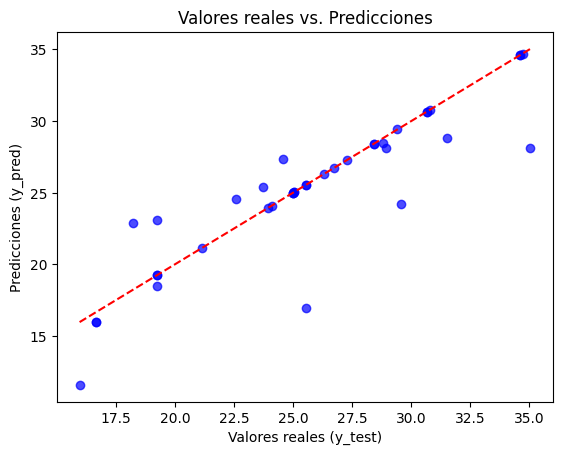

In [144]:
# MODELO DE REGRESIÓN POLINOMICA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Grado del polinomio
degree = 3  

# Crea el pipeline para la regresión polinómica
model = make_pipeline(
    PolynomialFeatures(degree),
    LinearRegression()
)

# Entrenamiento del modelo con los datos de entrenamiento
model.fit(X_train_scaled, y_train)

# Predice en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Evaluacion del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE del modelo en el conjunto de prueba: {mse}")
print(f"R² del modelo en el conjunto de prueba: {r2}")

#VISUALIZACIÓN:
plt.scatter(y_test, y_pred, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Valores reales vs. Predicciones")
plt.show()


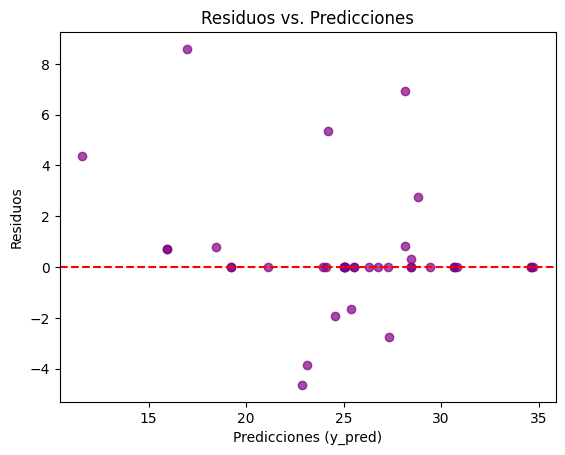

In [ ]:
# Residuos
residuals = y_test - y_pred

# Grafica de los residuos
plt.scatter(y_pred, residuals, alpha=0.7, color="purple")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicciones (y_pred)")
plt.ylabel("Residuos")
plt.title("Residuos vs. Predicciones")
plt.show()


In [ ]:

player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'])

filtered_data_december = player_data_top[
    (player_data_top['game_creation'] >= '2024-12-01') & 
    (player_data_top['game_creation'] <= '2024-12-31')
]

filtered_data_december['date'] = filtered_data_december['game_creation'].dt.date


print(filtered_data_december.head())


             match_id  data_version  \
573   EUW1_7218556505             2   
1969  EUW1_7222413267             2   
2343  EUW1_7218974320             2   
2359  EUW1_7222474023             2   
3221  EUW1_7219889830             2   

                                           participants  \
573   ['GKipOcl3O7U4mALHDeCrLn9u8PRZLmaciwjKUo5_gMtK...   
1969  ['j5qdu1YD-dwi0Cpbkq-sHOfIr2fjvSClMlx7_hLQxC_V...   
2343  ['LdYO6Gtw8oAdh5N9brxQtIF_Vhsqy1XbSw0_vJv82pw6...   
2359  ['_c-fAK2amEHol8eCdCqHz2CaKyVG8-x6_xyp_aWrTxLI...   
3221  ['r7ivDzcti2wF-8vDAWkQYWQQOdy9C6UFBpHauRZE6UuY...   

               game_creation  game_duration  game_end_timestamp  \
573  2024-12-07 16:27:32.256            924       1733589799139   
1969 2024-12-10 16:25:44.577           2077       1733850043694   
2343 2024-12-07 21:16:07.359           1578       1733607760310   
2359 2024-12-10 17:13:52.913           2129       1733853021742   
3221 2024-12-08 15:36:10.752           1105       1733673319574   

      g

In [68]:
# Creacion las características de diciembre
X_december = filtered_data_december[features_columns]

X_december['kda'] = X_december['kda'].fillna(X_december['kda'].mean())

# Escalar los datos de diciembre
X_december_scaled = scaler.transform(X_december)


C:\Users\HP\AppData\Local\Temp\ipykernel_1104\3388442408.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_december['kda'] = X_december['kda'].fillna(X_december['kda'].mean())


In [69]:
# Realiza las predicciones para diciembre
y_pred_december = model.predict(X_december_scaled)

print(y_pred_december[:10])


[15.4        34.61666667 26.3        35.48333333 18.41666667 23.93333333
 30.8        30.8        28.16666667 26.3       ]


In [140]:
y_pred_december = model.predict(X_december_scaled)

print(y_pred_december[:30])


[15.4        34.61666667 26.3        35.48333333 18.41666667 23.93333333
 30.8        30.8        28.16666667 26.3        34.61666667 26.75
 11.59149452 15.9494522  28.91666667 19.23333333 22.8554589  19.23333333
 26.15       15.2        35.48333333 25.         19.23333333 33.56666667
 34.61666667 24.95       15.21666667 26.75       23.91666667 27.597006  ]


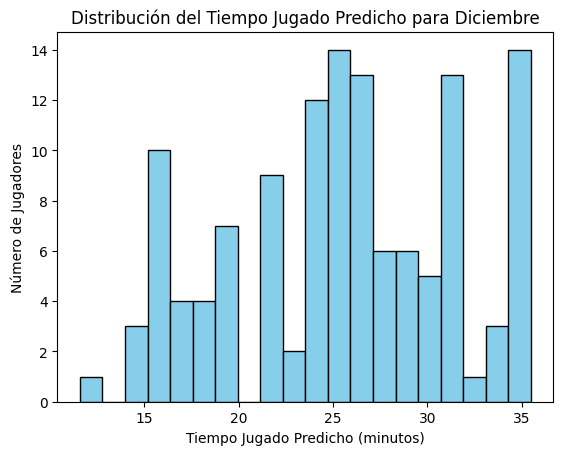

In [141]:
import matplotlib.pyplot as plt

# Graficao la distribución de las predicciones de tiempo jugado en mes diciembre
plt.hist(y_pred_december, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Tiempo Jugado Predicho (minutos)")
plt.ylabel("Número de Jugadores")
plt.title("Distribución del Tiempo Jugado Predicho para Diciembre")
plt.show()


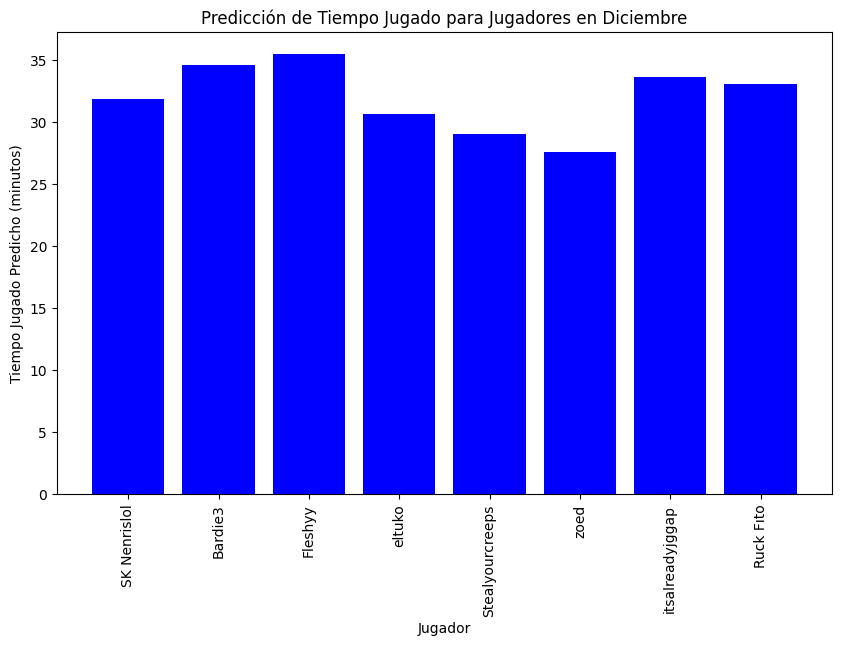

In [72]:
plt.figure(figsize=(10, 6))
plt.bar(filtered_data_december['summoner_name'], y_pred_december, color='blue')
plt.xticks(rotation=90)
plt.xlabel("Jugador")
plt.ylabel("Tiempo Jugado Predicho (minutos)")
plt.title("Predicción de Tiempo Jugado para Jugadores en Diciembre")
plt.show()


#### entrenamiento hecho

#### Prediccion diaria (Intento 1)

In [126]:
player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'])

filtered_data_december = player_data_top[
    (player_data_top['game_creation'] >= '2024-12-01') & 
    (player_data_top['game_creation'] <= '2024-12-31')
]

filtered_data_december['date'] = filtered_data_december['game_creation'].dt.date


C:\Users\HP\AppData\Local\Temp\ipykernel_1104\2423642109.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_december['date'] = filtered_data_december['game_creation'].dt.date


In [127]:
daily_data = filtered_data_december.groupby('date')[features_columns].mean()

# Rellena valores nulo de kda con el promedio
daily_data['kda'] = daily_data['kda'].fillna(daily_data['kda'].mean())

# primeras filas de los datos diarios
print(daily_data.head())


                kills    deaths    assists   gold_earned  \
date                                                       
2024-12-01  11.235294  1.941176   8.470588  11814.352941   
2024-12-02   7.000000  4.750000  15.500000  10066.000000   
2024-12-03   5.800000  1.800000   7.600000  10627.400000   
2024-12-04   6.000000  4.000000   7.500000   8329.500000   
2024-12-05   3.714286  5.142857  10.000000   9431.285714   

            total_damage_dealt_to_champions  total_damage_taken  vision_score  \
date                                                                            
2024-12-01                     18527.235294        22615.529412     20.647059   
2024-12-02                     17360.500000        15998.250000     35.250000   
2024-12-03                     21962.000000        12303.800000     16.000000   
2024-12-04                     14313.500000        15899.500000     57.250000   
2024-12-05                     15518.571429        24453.714286     37.857143   

           

In [128]:
# Escalar los datos diarios
daily_data_scaled = scaler.transform(daily_data)

daily_predictions = model.predict(daily_data_scaled)

# dataframe con las fechas y las predicciones
daily_predictions_df = pd.DataFrame({
    'date': daily_data.index,
    'predicted_time_played': daily_predictions
})

# primeras lineas de las predicciones diarias
print(daily_predictions_df.head())


         date  predicted_time_played
0  2024-12-01              21.606421
1  2024-12-02              25.812961
2  2024-12-03              25.494429
3  2024-12-04              24.704927
4  2024-12-05              27.294484


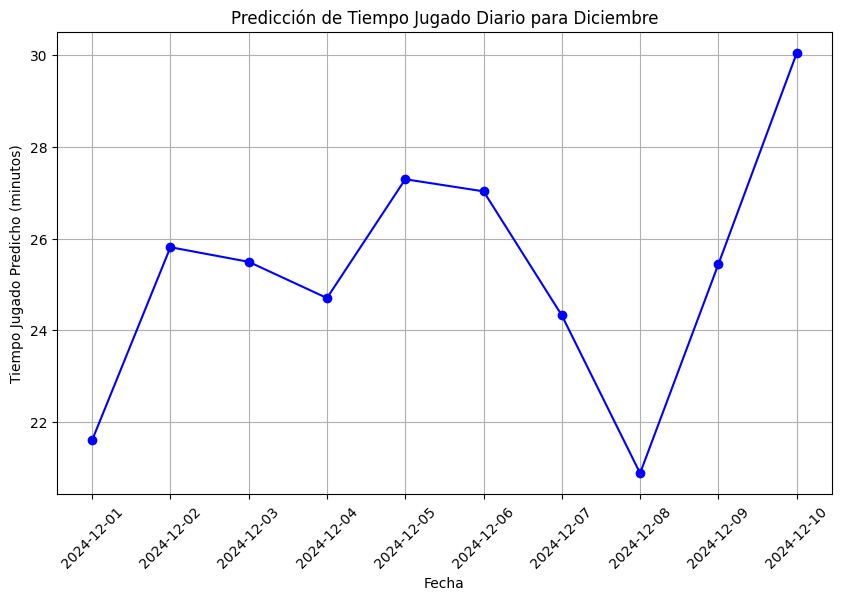

In [ ]:
# Grafica de las predicciones diarias
plt.figure(figsize=(10, 6))
plt.plot(daily_predictions_df['date'], daily_predictions_df['predicted_time_played'], marker='o', color='blue')
plt.xlabel("Fecha")
plt.ylabel("Tiempo Jugado Predicho (minutos)")
plt.title("Predicción de Tiempo Jugado Diario para Diciembre")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
